# Multi-Scale Anti-Correlated Neural States Dominate Naturalistic Whole-Brain Activity

**Paper Authors**

Dora Gozukara, Djamari Oetringer, Nasir Ahmad, Linda Geerligs

**Notebook Authors**

Dora Gozukara, Nasir Ahmad

**Contact**

Dora Gozukara

**Product of**

[DyNaC-Lab](https://www.dynac-lab.com), 2025

## Setup

### Imports

In [ ]:
!pip install nilearn
!pip install diptest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from nilearn import plotting, image, surface, datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import nibabel as nib
from matplotlib import cm, colormaps, colors
import matplotlib.colors
from matplotlib.gridspec import GridSpec
from tqdm import trange, tqdm
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from nilearn.input_data import NiftiMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.contrasts import compute_contrast
from nilearn.plotting import plot_contrast_matrix
import statsmodels.api as sm
from nilearn.glm.first_level import make_first_level_design_matrix
import psutil
import diptest
import seaborn as sns
from scipy import stats
import scipy.io
from ipywidgets import widgets
from IPython.display import display
from datetime import datetime
from scipy.spatial.distance import pdist, squareform


/tmp/ipython-input-1568116811.py:14: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiMasker


### Google Drive

In [ ]:
# connect your google drive, for google colab
from google.colab import drive
drive.mount('/content/drive/') #, force_remount=True

Mounted at /content/drive/


### Functions and Utilities

In [ ]:
cscale = ["#B78D64", "#A4B161", "#3F6871", "#764177","#754C24", '#657123','#4A184C','#183F48']

In [ ]:
def plot_data_with_template(title,roi_averaged_data,roi_template_timeseries_projection,imvmin=-1, imvmax=1,start=None,until=None,multicolor=False,figsize=None,scale=15,y_label='ROIs'):


  if start is None:
    start =0
  if until is None:
    until = roi_template_timeseries_projection.shape[0]

  if figsize is None:
    figsize = (scale*2,scale*1)
  fig, axs = plt.subplots(2,1, figsize=figsize, dpi=500/scale, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
  fig.suptitle(title)

  if roi_averaged_data.shape[0] == roi_averaged_data.shape[1]:
    aspect='equal'
  else:
    aspect='auto'

  im = axs[0].imshow(roi_averaged_data[:,start:until],aspect=aspect,alpha=0.95, cmap='Spectral_r', interpolation="None",vmin=imvmin, vmax=imvmax)
  axs[0].tick_params(top=False, bottom=True, labelbottom=True, labeltop=False)
  axs[0].spines[['top', 'right', 'left']].set_visible(False)
  axs[0].spines[['bottom']].set_visible(False)
  axs[0].set_yticks([])

  axs[0].set_ylabel(y_label)
  axs[1].axhline(0, color='k', alpha=0.25)
  axs[1].plot(roi_template_timeseries_projection[start:until],label='Template',c=cscale[2])
  axs[1].set_xticks([])
  axs[1].yaxis.set_ticks_position("right")
  axs[1].set_xlabel('Timepoints')
  axs[1].spines[['top', 'right', 'left', 'bottom']].set_visible(False)

  pos = axs[1].get_position()
  new_pos = [pos.x0, pos.y0-0.075, pos.width, pos.height]
  axs[1].set_position(new_pos)
  axs[1].patch.set_alpha(0.75)
  axs[1].tick_params(axis='y', labelsize=6)
  if multicolor:
    colors = [cscale[0], cscale[1], cscale[2]]
    # Create x values based on indices
    string_series = roi_template_timeseries_projection[start:until]
    x = np.arange(len(string_series))

    # Get unique strings and convert series to numeric values
    unique_strings = list(dict.fromkeys(string_series))
    y_numeric = [unique_strings.index(s) for s in string_series]
    color_map = dict(zip(unique_strings, colors))
    # Plot each segment using the color for that string
    for i in range(len(string_series)-1):
        current_string = string_series[i]
        axs[1].plot(x[i:i+2], y_numeric[i:i+2],
                color=color_map[current_string],
                linewidth=2)

    # Set y-axis ticks to show original strings
    axs[1].set_yticks(range(len(unique_strings)))
    axs[1].set_yticklabels(unique_strings)
  #axs[1].legend(loc='upper right')

  fig.tight_layout()
  return fig

In [ ]:
def get_sl_data(sl_idx, whole_brain_data,atlas_resampled):
    '''
    Args:
    sl_idx --> index of the ROI you want to get
    whole_brain_data ---> 4d whole brain data of shape (x,y,z,n_timepoints)
    Returns:
    sl_data --> 2d array of shape (n_voxels,n_timepoints)
    '''

    atlas_data = atlas_resampled.get_fdata()
    sl_array = whole_brain_data[atlas_data == sl_idx,:]
    sl_array = np.nan_to_num(sl_array)
    return sl_array

def roi_pattern_to_nifti(template,saving=False,output_path=''):
  # Load the template NIfTI file
  template_img = atlas_resampled
  template_data = template_img.get_fdata()

  # Create an empty array for the new image
  new_data = np.zeros_like(template_data)

  # Project ROI values onto the template
  unique_rois = np.unique(template_data)
  for roi_label in unique_rois:
      if roi_label == 0:  # Assuming 0 is the background
          continue
      if int(roi_label) - 1 < len(template):  # Ensure ROI index is within range
          new_data[template_data == roi_label] = template[int(roi_label) - 1]

  # Save the new NIfTI image
  new_img = nib.Nifti1Image(new_data, affine=template_img.affine, header=template_img.header)
  if saving:
    nib.save(new_img, output_path)
    print("New NIfTI image saved")
  return new_img


def nifti_to_surface(nifti_image):
  # load the fsaverage surface mesh
  fsaverage = datasets.fetch_surf_fsaverage()

  # smooth the volumetric image using
  # nifti_image = image.smooth_img(nifti_image, fwhm=5)


  # project the smooth 3D data onto the brain surface
  texture_left = surface.vol_to_surf(nifti_image, fsaverage.pial_left, interpolation='nearest', radius=3.0, n_samples=20)
  texture_right = surface.vol_to_surf(nifti_image, fsaverage.pial_right, interpolation='nearest', radius=3.0, n_samples=20)

  # set the values close to 0 to NaN for transparency
  lower_bound = -0.0005
  upper_bound = 0.0005
  texture_left[(texture_left >= lower_bound) & (texture_left <= upper_bound)] = np.nan
  texture_right[(texture_right >= lower_bound) & (texture_right <= upper_bound)] = np.nan
  return texture_left, texture_right

def long_plot(texture_left,texture_right,title='Title',colorbarlabel='',saving=True,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True):
  fsaverage = datasets.fetch_surf_fsaverage()
  # create a figure
  fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'projection': '3d'})
  fig.suptitle(title, fontsize=12,x=0.45)

  # Define the views and hemispheres
  # views = ['lateral', 'medial']#, 'dorsal', 'ventral', 'anterior', 'posterior']
  hemispheres = ['left', 'right']
  from_left_to_right = [(views[0],hemispheres[0]), (views[0],hemispheres[1]), (views[1],hemispheres[0]), (views[1],hemispheres[1])]

  titles = {
      'lateral': 'Lateral View',
      'medial': 'Medial View',
      'dorsal': 'Dorsal View',
      'ventral': 'Ventral View',
      'anterior': 'Anterior View',
      'posterior': 'Posterior View'
  }

  if norm is None:
    norm = plt.Normalize(vmin=min_val, vmax=max_val)  # normalize based on min and max values


  # plot each view and hemisphere in subplots
  for i, (view, hemi) in enumerate(from_left_to_right):
      texture = texture_left if hemi == 'left' else texture_right
      ax = axes[i]
      plotting.plot_surf_stat_map(
          fsaverage.infl_left if hemi == 'left' else fsaverage.infl_right,
          texture,
          hemi=hemi,
          view=view,
          colorbar=False,  # Disable individual colorbars for a cleaner look
          bg_map=fsaverage.sulc_left if hemi == 'left' else fsaverage.sulc_right,
          cmap=cmap,
          axes=ax,
          vmax=max_val,
          vmin=min_val,
          bg_on_data = True
      )

  fig.subplots_adjust(top=1, right=0.85, wspace=0, hspace=0.00002, left=0.05, bottom=0)  # Adjust spacing

  cbar_ax = fig.add_axes([0.95, 0.05, 0.02, 0.8])  # (left, bottom, width, height)
  sm = plt.cm.ScalarMappable(cmap=cmap , norm=norm)
  sm.set_array([min_val, max_val])
  cbar = plt.colorbar(sm, cax=cbar_ax)
  cbar.set_label(colorbarlabel, rotation=270, labelpad=15)  # Customize colorbar label

  if saving == True:
    plt.savefig('/content/drive/My Drive/Flipping/BrainMaps/'+str(now).replace(' ','_').replace(':','_').split('.')[0]+'SurfaceMap_'+title, transparent=True, dpi=300)
  if show:
    plt.show()


In [ ]:
def run_diptest(data):
  '''
  Arguments
  - Data: 2d multivariate timeseries of shape (n_features,n_timepoints)
  Returns
  - dips:
  - dip_pvals:
  '''

  TbyT_corr = np.corrcoef(data.T)
  meta_TbyT_corr = np.corrcoef(TbyT_corr)
  n_timepoints = len(meta_TbyT_corr)

  dips, dip_pvals = [], []
  for i in range(n_timepoints):
    dip, pval = diptest.diptest(meta_TbyT_corr[i,:].flatten())
    dips.append(dip)
    dip_pvals.append(pval)

  dips, dip_pvals = np.asarray(dips), np.asarray(dip_pvals)
  return dips, dip_pvals

def template_creation(data, with_dip=True):
    if with_dip:
      dips, dip_pvals = run_diptest(data)
      template_data = data[:,dip_pvals<.05]
    else:
      template_data = data

    template_mean = np.mean(template_data, axis=1)
    template_data = template_data - template_mean[:,None]

    template_correlations = np.corrcoef(template_data.T)
    correlation_signs = np.sign(template_correlations[:,0])

    # # Scaling all vectors to the same length
    # template_data = template_data / np.linalg.norm(template_data, axis=0)

    template = np.mean(template_data*correlation_signs[None,:], axis=1)

    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, template_data)

    if np.corrcoef(np.mean(data,axis=0), template_timeseries_projection)[0][1]<0:
      template = template*-1
      template_mean = template_mean * -1

    return template_mean, template

def template_projection(template_mean, template, data):
    template_timeseries_projection = data - template_mean[:,None]

    # Projecting the template vector on to the roi signal
    # 1) measure the dot product
    template_timeseries_projection = (np.einsum('in,i->n', template_timeseries_projection, template))
    # 2) Divide the dot product by the square magnitude of the template vec
    template_timeseries_projection = template_timeseries_projection / (np.linalg.norm(template, ord=2)**2)

    template_timeseries = template_mean[:,None] + template[:, None] * template_timeseries_projection

    return template_timeseries, template_timeseries_projection

def plot_summary(num_events,event_types,event_labels,transition_matrix_np,sizes,durations_list):
  fig, axs = plt.subplots(1,2,figsize=(20,5))


  cax = axs[0].matshow(transition_matrix_np, cmap="Grays")

  # annotate
  for i in range(num_events):
      for j in range(num_events):
          count = transition_counts_np[i, j]
          prob = transition_matrix_np[i, j]
          if prob < 0.5:
            c = "black"
          else:
            c = "white"
          axs[0].text(j, i, f"{count}\n({prob:.2f})", ha='center', va='center', color=c,fontsize=12)

  axs[0].set_xticks(range(num_events))
  axs[0].set_yticks(range(num_events))
  axs[0].set_xticklabels(event_types)
  axs[0].set_yticklabels(event_types)

  axs[0].set_xlabel("To State")
  axs[0].set_ylabel("From State")

  plt.colorbar(cax)

  text_properties = {'color': 'black', 'fontsize': 12, 'fontweight': "bold"}

  # Custom function to format labels inside the pie
  def autopct_with_labels(pct, all_vals):
      total = sum(all_vals)
      absolute = int(round(pct * total / 100.0))  # Compute absolute count
      return f"{event_types[all_vals.index(absolute)]}\n{pct:.1f}%"


  # Create a pie chart
  wedges, texts, autotexts = axs[1].pie(
      sizes,
      colors=[cscale[2], cscale[0], cscale[1]],
      autopct=lambda pct: autopct_with_labels(pct, sizes),  # Labels + percentages inside
      textprops=text_properties,  # Customize text properties
  )

  for text in autotexts:
      text.set_color('white')

  plt.show()

In [ ]:
# functions
def proportion_variance_explained_mse(A, B):
    '''
    takes
    2 numpy arrays of shape (n_features, n_timepoints),
    and calculates the proportion of variance explained by B in A using MSE.
    returns proportion of variance explained by B in A.
    '''

    assert A.shape == B.shape, "A and B must have the same shape"

    A = A - np.mean(A)[None,None]
    B = B - np.mean(B)[None,None]

    # calculate the MSE between A and B
    mse = np.mean((A - B) ** 2)

    # calculate the total variance in A
    total_variance = np.var(A)

    # calculate the proportion of variance explained in A by B
    pve = 1 - (mse / total_variance)

    return pve

In [ ]:
def find_label_boundaries(labels):
    boundaries = []
    region_sizes = []
    unique_labels = []

    current_label = labels[0]
    start_idx = 0

    for i, label in enumerate(labels):
        if label != current_label:
            boundaries.append(i)
            region_sizes.append(i - start_idx)
            unique_labels.append(current_label)
            current_label = label
            start_idx = i

    boundaries.append(len(labels))
    region_sizes.append(len(labels) - start_idx)
    unique_labels.append(current_label)

    return [0] + boundaries, region_sizes, unique_labels

def set_compact_labels(ax, labels):
    boundaries, region_sizes, unique_labels = find_label_boundaries(labels)

    # Calculate center positions for labels
    centers = [(boundaries[i] + boundaries[i+1]-1)/2 for i in range(len(boundaries)-1)]

    # Set ticks at region centers
    ax.set_xticks(centers)
    ax.set_yticks(centers)
    ax.set_xticklabels(unique_labels, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(unique_labels, fontsize=8)

    # Add subtle boundary markers
    for boundary in boundaries[1:-1]:  # Skip first and last to avoid edge lines
        ax.axhline(y=boundary-0.5, color='black', linewidth=0.5, alpha=0.5)
        ax.axvline(x=boundary-0.5, color='black', linewidth=0.5, alpha=0.5)

In [ ]:
def overlap_permutation_test_optimized(target_indices, real_bounds, n_permutations=1000):
    '''
    Arguments:
    - target_indices: boundaries to keep constant
    - real_bounds: boundaries to shuffle
    Returns:
    - real_match: number of overlapping indices
    - expected_overlap: average overlap across permutations
    - shuffled_matches: list of overlap counts for each permutation
    - p_val: proportion of permutations with overlap > real_match
    '''
    import numpy as np

    # Pre-sort arrays if not already sorted
    target_indices = np.sort(target_indices)
    real_bounds = np.sort(real_bounds)

    # Calculate real overlap once
    real_match = np.intersect1d(target_indices, real_bounds).shape[0]

    # Pre-compute durations once
    real_durations = np.diff(np.append(0, real_bounds))

    # Vectorized approach - generate all permutations at once
    # Create n_permutations x len(real_durations) array of durations
    all_durations = np.tile(real_durations, (n_permutations, 1))

    # Shuffle each row independently
    for i in range(n_permutations):
        np.random.shuffle(all_durations[i])

    # Compute cumulative sums for each permutation
    all_bounds = np.cumsum(all_durations, axis=1)

    # Use a set for faster intersection operations
    target_set = set(target_indices)

    # Calculate intersections for all permutations
    shuffled_matches = np.zeros(n_permutations, dtype=int)
    for i in range(n_permutations):
        # Count intersections using set operations (faster than np.intersect1d)
        shuffled_matches[i] = len(target_set.intersection(all_bounds[i]))

    # Calculate statistics
    expected_overlap = np.mean(shuffled_matches)
    p_val = np.sum(shuffled_matches > real_match) / n_permutations

    return real_match, expected_overlap, shuffled_matches, p_val

In [ ]:
def compute_boundary_overlap_from_indices(E_indices, S_indices, n):
    """
    Compute boundary overlap metrics between event boundaries and neural state boundaries
    using arrays of indices where boundaries occur.

    Parameters:
    E_indices: array of indices where event boundaries occur
    S_indices: array of indices where neural state boundaries occur
    n: total number of timepoints in the original time series

    Returns:
    OA: absolute overlap
    OR: relative overlap
    """
    # Count total boundaries
    num_E = len(E_indices)
    num_S = len(S_indices)

    # Find overlapping indices (actual overlap)
    overlapping_indices = np.intersect1d(E_indices, S_indices)
    O = len(overlapping_indices)

    # Expected overlap
    OE = (num_E * num_S) / n

    # Absolute overlap
    denominator_A = num_S - OE
    OA = (O - OE) / denominator_A if denominator_A != 0 else 0

    # Relative overlap
    min_boundaries = min(num_E, num_S)
    denominator_R = min_boundaries - OE
    OR = (O - OE) / denominator_R if denominator_R != 0 else 0

    return OA, OR

## Settings

In [ ]:
now = datetime.now()

fig_save_dir = '/content/drive/My Drive/Flipping/Graphs/'+str(now).replace(' ','_').replace(':','_').split('.')[0]
low_ram_mode = psutil.virtual_memory()[0] < (54754004992 // 2)
n_permutations = 5000
runs = [1,2,3,5,6,7,8]
save_figures = True
print('SAVING FIGURES:',save_figures," at:",fig_save_dir)
if low_ram_mode:
  print("OPERATING IN LOW RAM MODE!")
  # n_permutations = 50
  runs = [1,2,3]
  # save_figures = False
  print("Number of Permutatations for permutation testing is",n_permutations)
  print("For StudyForrest runs",runs,"are being used.")
  print("Saving Figures:",save_figures)

SAVING FIGURES: True  at: /content/drive/My Drive/Flipping/Graphs/2025-08-26_18_48_11
OPERATING IN LOW RAM MODE!
Number of Permutatations for permutation testing is 5000
For StudyForrest runs [1, 2, 3] are being used.
Saving Figures: True


In [ ]:
# !pip list

## Loading Data

To add a new datasets to this notebook, you need to do these things:
- add a boolean with your datasets name to the cell below and set it to false
- add the boolean to the dropdown below
- add a reference nifti path (path of your group averaged nifti file would do) to the atlas loading cell
- add a new cell below other datasets and load your data: you need to define the *concat_all_whole_brain_data* variable as a 4d numpy array that holds your fMRI volumetric timeseries (see examples below). nest it with 'if use_mydataset:'
- add stimuli boundary timelines for your dataset: add 1d numpy arrays of shape (n_fmri_timepoints) to the *stimuli_boundaries* list. these arrays should have 1s at indices where a stimuli boundary is present, and 0s everywhere else. you can add as many as you like. all will be used for the global and local analyses.
please add an array with randomly placed 1s if you dont have any stimuli annotations and ignore relevant result.
- set a list stimuli_names and add names for your stimuli boundary types


In [ ]:
use_studyforrest = False
use_camCAN = False
use_djataset = False
########### Example ############
use_yourData = False

In [ ]:
#@title Select Dataset {run: "auto"}
Dataset = "StudyForrest" #@param ["StudyForrest", "CamCAN","Djataset","YourData"]

# Set boolean values based on selection
use_studyforrest = (Dataset == "StudyForrest")
use_camCAN = (Dataset == "CamCAN")
use_djataset = (Dataset == "Djataset")
########### Example ############
use_yourData = (Dataset == "YourData")

print('Using: ',Dataset)

Using:  StudyForrest


In [ ]:
# @title Set your TR duration (in seconds)
if Dataset =='CamCAN':
  TR_duration = 2.5
elif Dataset =='StudyForrest':
  TR_duration = 2
elif Dataset =='Djataset':
  TR_duration = 1.5
elif Dataset =='YourData':
    TR_duration = None # @param {"type":"number","placeholder":"TR duration in seconds"}
TR_in_seconds = TR_duration

In [ ]:
print('TR duration: ',TR_in_seconds, ' seconds')

TR duration:  2  seconds


### Load the Atlas

In [ ]:
n_rois = 400
yeo_networks = 7
atlas_resolution_mm = 2

if use_studyforrest:
  reference_nifti_path = '/content/drive/My Drive/StudyForrest_Data/sub-01_movie_run-1_hyperaligned.nii'  # StudyForrest
elif use_camCAN:
  reference_nifti_path = '/content/drive/My Drive/CamCAN/CamCAN_1group_hyperalignment_linda_selection_group_averaged_data.nii' # CamCAN
elif use_djataset:
  reference_nifti_path = '/content/drive/My Drive/Djamari/wb_mean_Movie-Hyper-all.nii.gz' # Djataset
########### Example ############
elif use_yourData:
  reference_nifti_path = '/your/path/your_data.nii.gz' # Djataset



schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=n_rois, yeo_networks=yeo_networks, resolution_mm=atlas_resolution_mm)
atlas_img = image.load_img(schaefer['maps'])
schaefer_labels = schaefer['labels']

# Decode labels if necessary
if isinstance(schaefer_labels[0], bytes):
    schaefer_labels = [label.decode('utf-8') for label in schaefer_labels]
schaefer_labels = np.array(schaefer_labels)
# Load the reference NIfTI file
reference_img = image.load_img(reference_nifti_path)

# Resample the atlas to match the reference image
print("Resampling atlas to match the reference image...")
atlas_resampled = image.resample_to_img(atlas_img, reference_img, interpolation='nearest',copy_header=True,force_resample=True)

reference_img = None
print('INDEX 0 IS BACKGROUND')

[fetch_atlas_schaefer_2018] Added README.md to /root/nilearn_data

[fetch_atlas_schaefer_2018] Dataset created in /root/nilearn_data/schaefer_2018

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_7Networks_order.txt ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

[fetch_atlas_schaefer_2018] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.
nii.gz ...

[fetch_atlas_schaefer_2018]  ...done. (0 seconds, 0 min)

Resampling atlas to match the reference image...
INDEX 0 IS BACKGROUND


### Load Group Averaged Hyperaligned Whole-Brain Data

In [ ]:
############################# STUDYFORREST ###########################
# load (x,y,z,time) fMRI data, group averaged, runs concatenated
if use_studyforrest:
  print('Loading and concatenating runs')
  concat_all_whole_brain_data = []
  for run in tqdm(runs):  # please include all runs -> [1,2,3,4,5,6,7,8]
    run_data = np.load('/content/drive/My Drive/StudyForrest_Data/preGSBS_run-'+str(run)+'_wholeBrain_mean.npy',allow_pickle=True)
    run_data = zscore(run_data, axis=-1)
    concat_all_whole_brain_data.append(run_data)
  concat_all_whole_brain_data = np.concatenate(concat_all_whole_brain_data,axis=3)
  print(concat_all_whole_brain_data.shape)

Loading and concatenating runs


100%|██████████| 3/3 [02:28<00:00, 49.61s/it]


(61, 73, 61, 1330)


In [ ]:
############################# CamCAN ###########################
if use_camCAN:
  camcan_path = '/content/drive/My Drive/CamCAN/CamCAN_1group_hyperalignment_linda_selection_group_averaged_data.nii'
  camcan_grp_avg_data = image.load_img(camcan_path)
  concat_all_whole_brain_data = camcan_grp_avg_data.get_fdata()
  print(concat_all_whole_brain_data.shape)

In [ ]:
############################# Djataset ###########################
if use_djataset:
  djataset_nifti_path = '/content/drive/My Drive/Djamari/wb_mean_cond-Neutral_story-VZ.nii.gz'
  concat_all_whole_brain_data = image.load_img(djataset_nifti_path).get_fdata()
  print(concat_all_whole_brain_data.shape)

In [ ]:
                   ########### Example ############
############################# YourData ###########################
if use_yourData:
  yourdata_nifti_path = '/your/path/your_data.nii.gz'
  concat_all_whole_brain_data = image.load_img(yourdata_nifti_path).get_fdata()
  print(concat_all_whole_brain_data.shape)

#### Create ROI averaged Timeseries

In [ ]:
# create a whole brain ROI averaged timeseries
roi_averaged_data = np.zeros([n_rois,concat_all_whole_brain_data.shape[-1]])
for i in trange(1,n_rois+1):
    roi_data = get_sl_data(i,concat_all_whole_brain_data,atlas_resampled)
    mean_roi_data = np.nanmean(roi_data, axis=0)
    if np.isnan(mean_roi_data[0]) or np.all(mean_roi_data==0):
      # Average only the non nan values
      roi_averaged_data[i-1,:] = np.nanmean(np.random.randn(roi_data.shape[0],roi_data.shape[1])*0.1, axis=0)
      # print(i)
    else:
      roi_averaged_data[i-1,:] = mean_roi_data
# Z-scoring the roi-averaged data
roi_averaged_data = zscore(roi_averaged_data, axis=-1)
print(f'Number of ROIs is {len(roi_averaged_data)}')

100%|██████████| 400/400 [00:04<00:00, 93.45it/s] 

Number of ROIs is 400


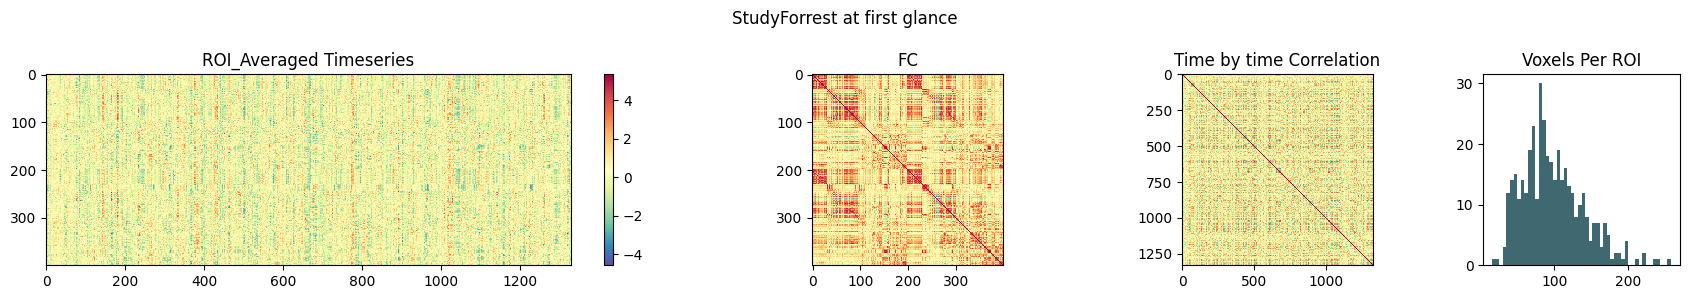

In [ ]:
# Visualizing the loaded data:
fig, axs = plt.subplots(1,4,figsize=(17,3),gridspec_kw={'width_ratios':[2,1,1,.6]})
fig.suptitle(Dataset+ ' at first glance')

im = axs[0].imshow(roi_averaged_data,aspect='auto',interpolation='none',cmap='Spectral_r')
axs[0].set_title("ROI_Averaged Timeseries")
fig.colorbar(im,ax=axs[0])

axs[1].imshow(np.corrcoef(roi_averaged_data),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
axs[1].set_title("FC")

axs[2].imshow(np.corrcoef(roi_averaged_data.T),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
axs[2].set_title("Time by time Correlation")

# Some descriptives about the data for an initial check
ROI_sizes = []
for i in range(1,401):
  ROI_sizes.append(get_sl_data(i, concat_all_whole_brain_data,atlas_resampled).shape[0])
_=axs[3].hist(ROI_sizes,bins=50,color=cscale[2])
axs[3].set_title("Voxels Per ROI")


fig.tight_layout()

### Load Stimulus Annotations

In [ ]:
stimuli_boundaries = []
if use_studyforrest:

  annotations_dict = np.load('/content/drive/My Drive/StudyForrest_Data/StudyForrest_annotations.npy',allow_pickle=True).item()
  stimuli_names = ['event', 'shot', 'mfcc']
  for stimuli_type in stimuli_names:
    concat_annotations = []
    for run in runs:
        concat_annotations.append(np.array(annotations_dict[run][stimuli_type]))

    concat_annotations = np.hstack(concat_annotations)

    if np.sum(concat_annotations) != int(np.sum(concat_annotations)): # check for continuous MFCC timeline
        cont_annot = np.array(concat_annotations)
        annotation_bounds = np.zeros_like(concat_annotations)
        annotation_bounds[concat_annotations>((1*np.std(cont_annot))+np.mean(cont_annot))] = 1
        concat_annotations = annotation_bounds
    else:
        concat_annotations = concat_annotations

    stimuli_boundaries.append(concat_annotations)

if use_camCAN:
  bold_offset = 4.5
  stimuli_names = ['event','time','cause','goal']
  # Constants
  TR = 2.47

  # Load the MATLAB .mat file
  mat_data = scipy.io.loadmat('/content/drive/My Drive/CamCAN/subjective_event_onsets.mat')
  event_onsets = mat_data['event_onsets']

  # Calculate event onsets in TR units
  event_onsets_subjective = np.floor((event_onsets + bold_offset) / TR)
  event_onsets_subjective = event_onsets_subjective.astype(int)
  # event_onsets_subjective = event_onsets_subjective + 2  # add HRF delay
  # Create event_boundaries_subj array
  event_boundaries_subj = np.zeros(192)
  event_boundaries_subj[event_onsets_subjective] = 1

  concat_annotations = event_boundaries_subj
  stimuli_boundaries.append(concat_annotations)

  shots_file_path = '/content/drive/My Drive/Bangbang_coding_sheet_FINAL1_Onsets.tsv'
  shots_file_data = np.genfromtxt(fname=shots_file_path, delimiter="\t", skip_header=1)[:,3] # time
  shots_file_data_processed =  np.floor((shots_file_data + bold_offset) / TR).astype(int)
  shots_file_data_processed = shots_file_data_processed[shots_file_data_processed>0]
  shots_file_data_processed = shots_file_data_processed[shots_file_data_processed<192]
  shot_boundaries_subj = np.zeros(192)
  shot_boundaries_subj[shots_file_data_processed] = 1
  stimuli_boundaries.append(shot_boundaries_subj)

  goals_file_data = np.genfromtxt(fname=shots_file_path, delimiter="\t", skip_header=1)[:,6] # 6 cause
  goals_file_data_processed =  np.floor((goals_file_data + bold_offset) / TR).astype(int)
  goals_file_data_processed = goals_file_data_processed[goals_file_data_processed>0]
  goal_boundaries_subj = np.zeros(192)
  goal_boundaries_subj[goals_file_data_processed[goals_file_data_processed<192]] = 1
  stimuli_boundaries.append(goal_boundaries_subj)

  charchar_file_data = np.genfromtxt(fname=shots_file_path, delimiter="\t", skip_header=1)[:,7] # goal
  charchar_file_data_processed =  np.floor((charchar_file_data + bold_offset) / TR).astype(int)
  charchar_file_data_processed = charchar_file_data_processed[charchar_file_data_processed>0]
  charchar_file_data_processed = charchar_file_data_processed[charchar_file_data_processed<192]
  charchar_boundaries_subj = np.zeros(192)
  charchar_boundaries_subj[charchar_file_data_processed] = 1
  stimuli_boundaries.append(charchar_boundaries_subj)

  # char_file_data = np.genfromtxt(fname=shots_file_path, delimiter="\t", skip_header=1)[:,0] # char
  # char_file_data_processed =  np.floor((char_file_data + bold_offset) / TR).astype(int)
  # char_file_data_processed = char_file_data_processed[char_file_data_processed>0]
  # char_file_data_processed = char_file_data_processed[char_file_data_processed<192]
  # char_boundaries_subj = np.zeros(192)
  # char_boundaries_subj[char_file_data_processed] = 1
  # stimuli_boundaries.append(char_boundaries_subj)


if use_djataset:
  dictionary = np.load('/content/drive/My Drive/Djamari/Experiment_Dj_event_boundaries.npy',allow_pickle=True).item()
  stimuli_names = [key for key in dictionary.keys()]
  list_from_dictionary = [dictionary[key] for key in dictionary.keys()]
  for stim_type in list_from_dictionary:
    stimuli_boundaries.append(stim_type)

########### Example ############
if use_yourData:
  dictionary = np.load('/your/path/stimuli_boundaries.npy',allow_pickle=True).item()
  stimuli_names = [key for key in dictionary.keys()]
  list_from_dictionary = [dictionary[key] for key in dictionary.keys()]
  for stim_type in list_from_dictionary:
    stimuli_boundaries.append(stim_type)

In [ ]:
annotation_bound_indices = [np.where(stimulus_boundaries!=0)[0] for stimulus_boundaries in stimuli_boundaries]

In [ ]:
for i in range(3):
  print(f'Number of {stimuli_names[i]} boundaries: {np.where(stimuli_boundaries[i]!=0)[0].shape[0]}')
print('Overlaps')
print(f'{stimuli_names[0]} - {stimuli_names[1]} overlap: {np.intersect1d(annotation_bound_indices[0],annotation_bound_indices[1]).shape[0]}')
print(f'{stimuli_names[1]} - {stimuli_names[2]} overlap: {np.intersect1d(annotation_bound_indices[1],annotation_bound_indices[2]).shape[0]}')
print(f'{stimuli_names[0]} - {stimuli_names[2]} overlap: {np.intersect1d(annotation_bound_indices[0],annotation_bound_indices[2]).shape[0]}')

Number of event boundaries: 65
Number of shot boundaries: 312
Number of mfcc boundaries: 139
Overlaps
event - shot overlap: 39
shot - mfcc overlap: 46
event - mfcc overlap: 17


## Global Scale

### Computing Correlation and Using the Dip Test for Bimodal Detection

In [ ]:
TbyT_corr = np.corrcoef(roi_averaged_data.T)
meta_TbyT_corr = np.corrcoef(TbyT_corr)

In [ ]:
data = roi_averaged_data

dips, dip_pvals = run_diptest(data)

bimodal_timepoint_indices = np.where(dip_pvals < 0.05)[0]
unimodal_timepoint_indices = np.where(dip_pvals > 0.05)[0]

bimodal_data = data[:, bimodal_timepoint_indices]
unimodal_data = data[:, unimodal_timepoint_indices]

template_mean, global_template = template_creation(bimodal_data)
template_timeseries, template_timeseries_projection = template_projection(template_mean, global_template, data)
global_template_timeseries_projection = template_timeseries_projection
global_template_timeseries = template_timeseries
temp_correlation_signs = np.sign(template_timeseries_projection)

indices_A = np.intersect1d(np.where(temp_correlation_signs>0)[0],bimodal_timepoint_indices)
indices_B = np.intersect1d(np.where(temp_correlation_signs<0)[0],bimodal_timepoint_indices)
indices_C = unimodal_timepoint_indices

sizes = [indices_A.shape[0], indices_B.shape[0] , indices_C.shape[0]]

# assign labels to the events
events = [(idx, 'TPS') for idx in indices_A] + \
         [(idx, 'DMS') for idx in indices_B] + \
         [(idx, 'Unimodal') for idx in indices_C]

# sort events by index
events.sort()

# extract event labels in order
event_sequence = [e[1] for e in events]

event_types = ['TPS', 'DMS', 'Unimodal']

-----------------

In [ ]:
# Anti-Correlated ROIs Ratio
print(sum((global_template>0).astype(int)) / sum((global_template<0).astype(int)))
print(sum((global_template>0).astype(int)) / global_template.shape[0])
print(sum((global_template<0).astype(int)) / global_template.shape[0])


2.3057851239669422
0.6975
0.3025


In [ ]:
# compute transitions
event_to_index = {event: i for i, event in enumerate(event_types)}
num_events = len(event_types)

transition_counts = np.zeros((num_events, num_events), dtype=int)

# transition counts
for i in range(len(event_sequence) - 1):
    from_idx = event_to_index[event_sequence[i]]
    to_idx = event_to_index[event_sequence[i + 1]]
    transition_counts[from_idx, to_idx] += 1


transition_counts_np = np.zeros((num_events, num_events), dtype=int)

# transition counts
for i in range(len(event_sequence) - 1):
    from_idx = event_to_index[event_sequence[i]]
    to_idx = event_to_index[event_sequence[i + 1]]
    transition_counts_np[from_idx, to_idx] += 1

# normalize
row_sums = transition_counts_np.sum(axis=1, keepdims=True)
transition_matrix_np = np.divide(transition_counts_np, row_sums, where=row_sums != 0)


# compute durations of successive same-state instances
durations = {event: [] for event in event_types}

# count consecutive occurrences
current_event = event_sequence[0]
start_idx = [idx for idx, e in events if e == current_event][0]  # Start index of first event

for i in range(1, len(events)):
    index, event = events[i]  # Extract correct index and event type

    if event == current_event:
        continue  # Continue counting the same event
    else:
        # Store duration of the previous event
        duration = index - start_idx
        durations[current_event].append(duration)

        # Update tracking variables
        current_event = event
        start_idx = index

# average durations
average_durations = {event: np.mean(durations[event]) if durations[event] else 0 for event in event_types}


durations_list = []
event_labels = []

for event, duration_list in durations.items():
    durations_list.extend(duration_list)
    event_labels.extend([event] * len(duration_list))


# plot_summary(num_events,event_types,event_labels,transition_matrix_np,sizes,durations_list)

### Visualizing Global Brain Activity

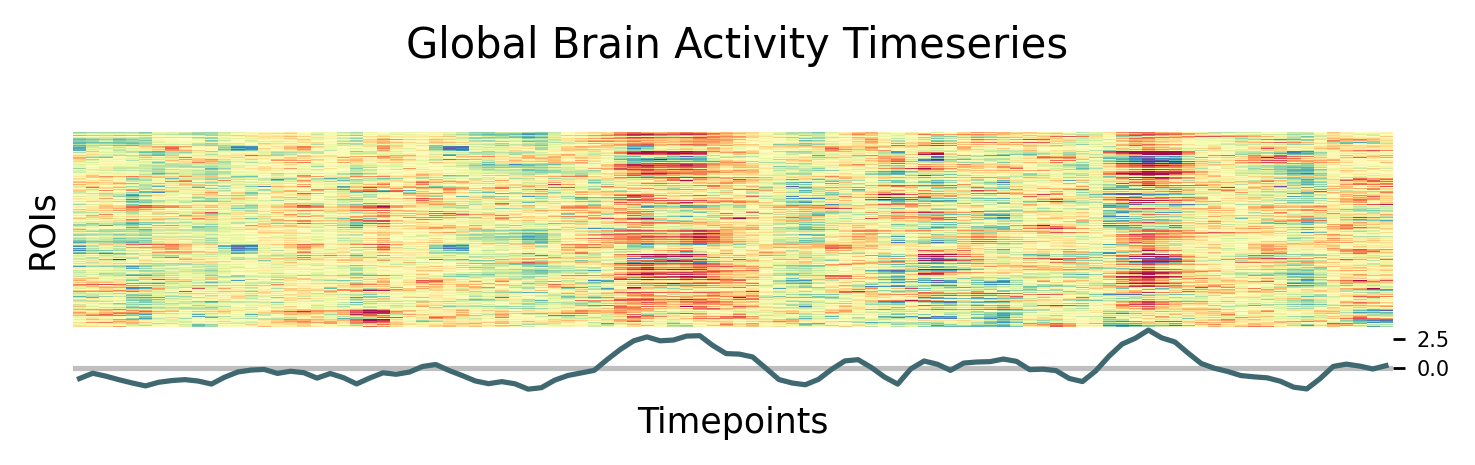

In [ ]:
fig = plot_data_with_template('Global Brain Activity Timeseries',roi_averaged_data,template_timeseries_projection,figsize=(6,2),imvmin=-3, imvmax=3,start=100,until=200,multicolor=False, scale=2)
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Global_Template_Timeseries',transparent=True,format='png')

### Project Global Template on to the Cortex

New NIfTI image saved


/tmp/ipython-input-4193239583.py:48: FutureWarning: The 'nearest' interpolation method will be deprecated in 0.13.0. To disable this warning, select either 'linear' or 'nearest_most_frequent'. If your image is a deterministic atlas 'nearest_most_frequent' is recommended. Otherwise, use 'linear'. See the documentation for more information.
  texture_left = surface.vol_to_surf(nifti_image, fsaverage.pial_left, interpolation='nearest', radius=3.0, n_samples=20)
/tmp/ipython-input-4193239583.py:49: FutureWarning: The 'nearest' interpolation method will be deprecated in 0.13.0. To disable this warning, select either 'linear' or 'nearest_most_frequent'. If your image is a deterministic atlas 'nearest_most_frequent' is recommended. Otherwise, use 'linear'. See the documentation for more information.
  texture_right = surface.vol_to_surf(nifti_image, fsaverage.pial_right, interpolation='nearest', radius=3.0, n_samples=20)
/tmp/ipython-input-4193239583.py:86: DeprecationWarning: The `darkness` 

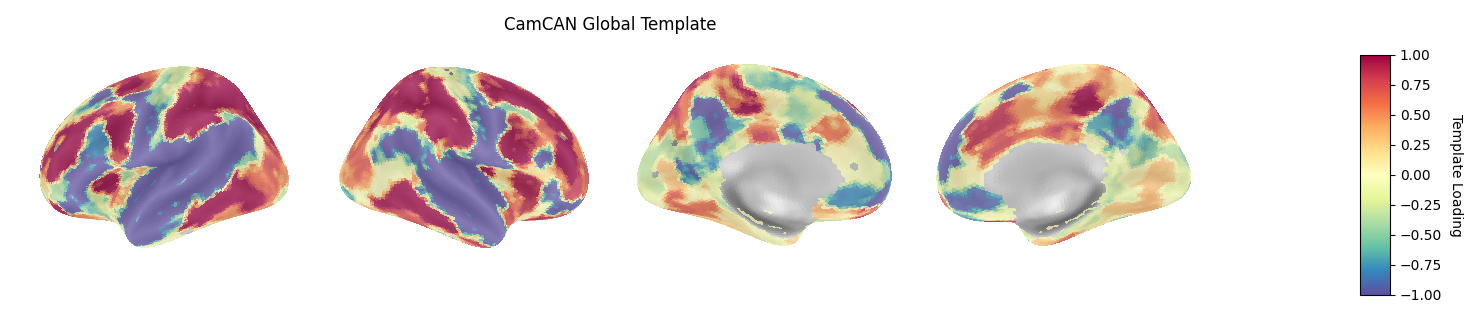

In [ ]:
data = zscore(global_template)

univariate_proportion_nii = roi_pattern_to_nifti(data,saving=save_figures,output_path='/content/drive/My Drive/Flipping/niftis/'+str(now).replace(' ','_').replace(':','_').split('.')[0]+"_"+Dataset+'_Global_Template')
texture_left, texture_right = nifti_to_surface(univariate_proportion_nii)
long_plot(texture_left,texture_right,title=Dataset+' Global Template',colorbarlabel='Template Loading',saving=save_figures,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)
# add state membership to colorbar

#### Correlation Between Yeo networks and the Global Template

In [ ]:
network_labels = np.array([ROI_label.split('_')[2] for ROI_label in schaefer_labels[1:]]).astype(str)
unique_network_labels = np.unique(network_labels)
network_indices = [[i for i, item in enumerate(network_labels) if item == network_label] for network_label in unique_network_labels]

In [ ]:
network_template_loadings = [np.mean(zscore(global_template)[network_index]) for network_index in network_indices]

In [ ]:
atlas_data = atlas_resampled.get_fdata()

network_template_correlations = []
for count, network_ROIs  in enumerate(network_indices):
  empty_volume = np.zeros_like(concat_all_whole_brain_data[:,:,:,0])
  for ROI_idx in network_ROIs:
    empty_volume[atlas_data == ROI_idx] = 1
  # print(np.corrcoef(univariate_proportion_nii.get_fdata().flatten(),empty_volume.flatten()))
  network_template_correlations.append(np.corrcoef(univariate_proportion_nii.get_fdata().flatten(),empty_volume.flatten())[0][1])

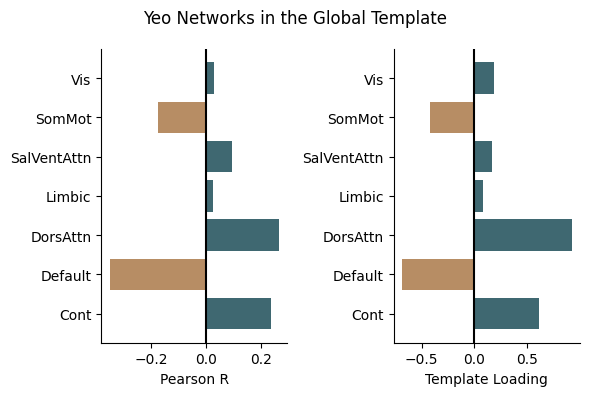

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(6,4),dpi=100)
fig.suptitle('Yeo Networks in the Global Template')
colors = [cscale[0] if val <= 0 else cscale[2] for val in network_template_correlations]
axs[0].barh(unique_network_labels,network_template_correlations,color=colors)
axs[0].set_xlabel('Pearson R')
axs[0].axvline(0,c='black')
axs[0].spines['top'].set_visible(False)  # Remove top border
axs[0].spines['right'].set_visible(False)  # Remove right border

network_template_loadings = [np.mean(zscore(global_template)[network_index]) for network_index in network_indices]
colors = [cscale[0] if val <= 0 else cscale[2] for val in network_template_loadings]
axs[1].barh(unique_network_labels,network_template_loadings,color=colors)
axs[1].set_xlabel('Template Loading')
axs[1].axvline(0,c='black')
axs[1].spines['top'].set_visible(False)  # Remove top border
axs[1].spines['right'].set_visible(False)  # Remove right border

fig.tight_layout()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Global_Template_in_Yeo_Networks',transparent=True,format='png')


In [ ]:
empty_volume = np.zeros_like(concat_all_whole_brain_data[:,:,:,0])
atlas_data = atlas_resampled.get_fdata()

for sl in trange(1,n_rois+1):

  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]

  try:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask
  except:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask

 28%|██▊       | 113/400 [00:14<00:30,  9.42it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 29%|██▉       | 116/400 [00:15<00:28, 10.04it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 30%|██▉       | 118/400 [00:15<00:27, 10.38it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of

### Global Template Explained Variance

In [ ]:
global_proportion_variance_explained_mse = proportion_variance_explained_mse(roi_averaged_data,global_template_timeseries)
print(f'Global Variance Explained by the Template is: {global_proportion_variance_explained_mse} !!!!!')

Global Variance Explained by the Template is: 0.2601994857951081 !!!!!


In [ ]:
unimean_reconstruction = np.tile(np.mean(roi_averaged_data,axis=0),(roi_averaged_data.shape[0],1))
unimean_proportion_variance_explained_mse = proportion_variance_explained_mse(roi_averaged_data,unimean_reconstruction)
print(f'Global Variance Explained by the Univariate Mean is: {unimean_proportion_variance_explained_mse} !!!!!')

Global Variance Explained by the Univariate Mean is: 0.17517003073788728 !!!!!


### Relation to Stimuli - Examining Event Boundaries and Global State Transitions

In [ ]:
all_stimuli_change_types_all_delays_p_values = []
all_stimuli_change_types_all_delays_differences = []
for stim_count, stim_name in tqdm(enumerate(stimuli_names)):

  n_permutations = 100000
  delays = np.arange(-5,6,1)

  change_types_all_delays_p_values = []
  change_types_all_delays_differences = []
  for change_count, (change_type, change_signifier) in enumerate(zip(['Default Mode\nState','Task Positive\nState'],[-1,1])):

    all_delays_shuffled_matches =[]
    all_delays_real_matches = []
    for window in delays:
      target_indices = np.where(np.sign(global_template_timeseries_projection)==change_signifier)[0]


      real_bounds = np.where(stimuli_boundaries[stim_count]>0)[0]+window
      real_match, expected_overlap, shuffled_matches, p_val = overlap_permutation_test_optimized(target_indices,real_bounds,n_permutations=n_permutations)
      all_delays_real_matches.append(real_match)
      all_delays_shuffled_matches.append(shuffled_matches)

    pvalues = [np.sum(shuffled_matches > real_matches)/ shuffled_matches.shape[0] for shuffled_matches , real_matches in zip(np.array(all_delays_shuffled_matches),np.array(all_delays_real_matches))]
    differences = [(real_matches - np.mean(shuffled_matches))/np.array(np.where(stimuli_boundaries[0]>0)[0]).shape[0]  for shuffled_matches , real_matches in zip(np.array(all_delays_shuffled_matches),np.array(all_delays_real_matches))]

    change_types_all_delays_p_values.append(pvalues)
    change_types_all_delays_differences.append(differences)

  all_stimuli_change_types_all_delays_p_values.append(change_types_all_delays_p_values)
  all_stimuli_change_types_all_delays_differences.append(change_types_all_delays_differences)

4it [02:34, 38.62s/it]


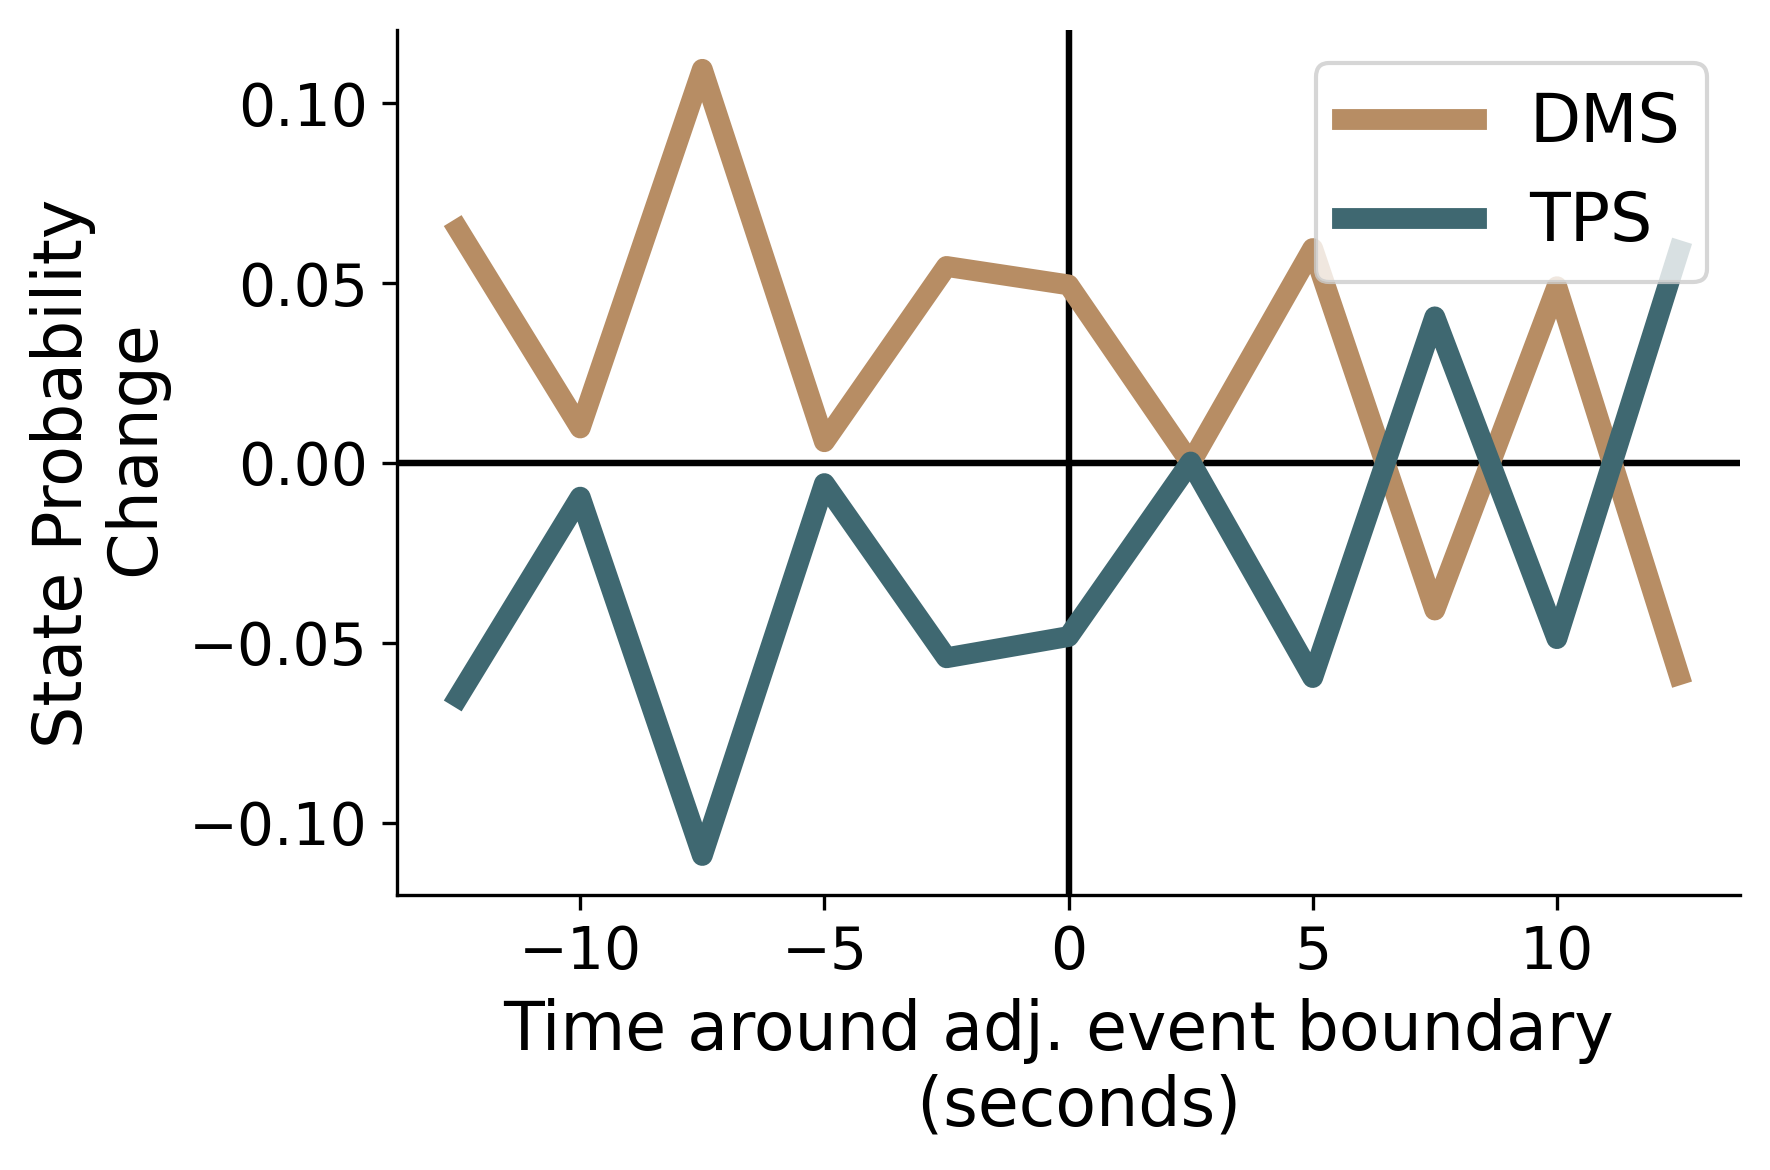

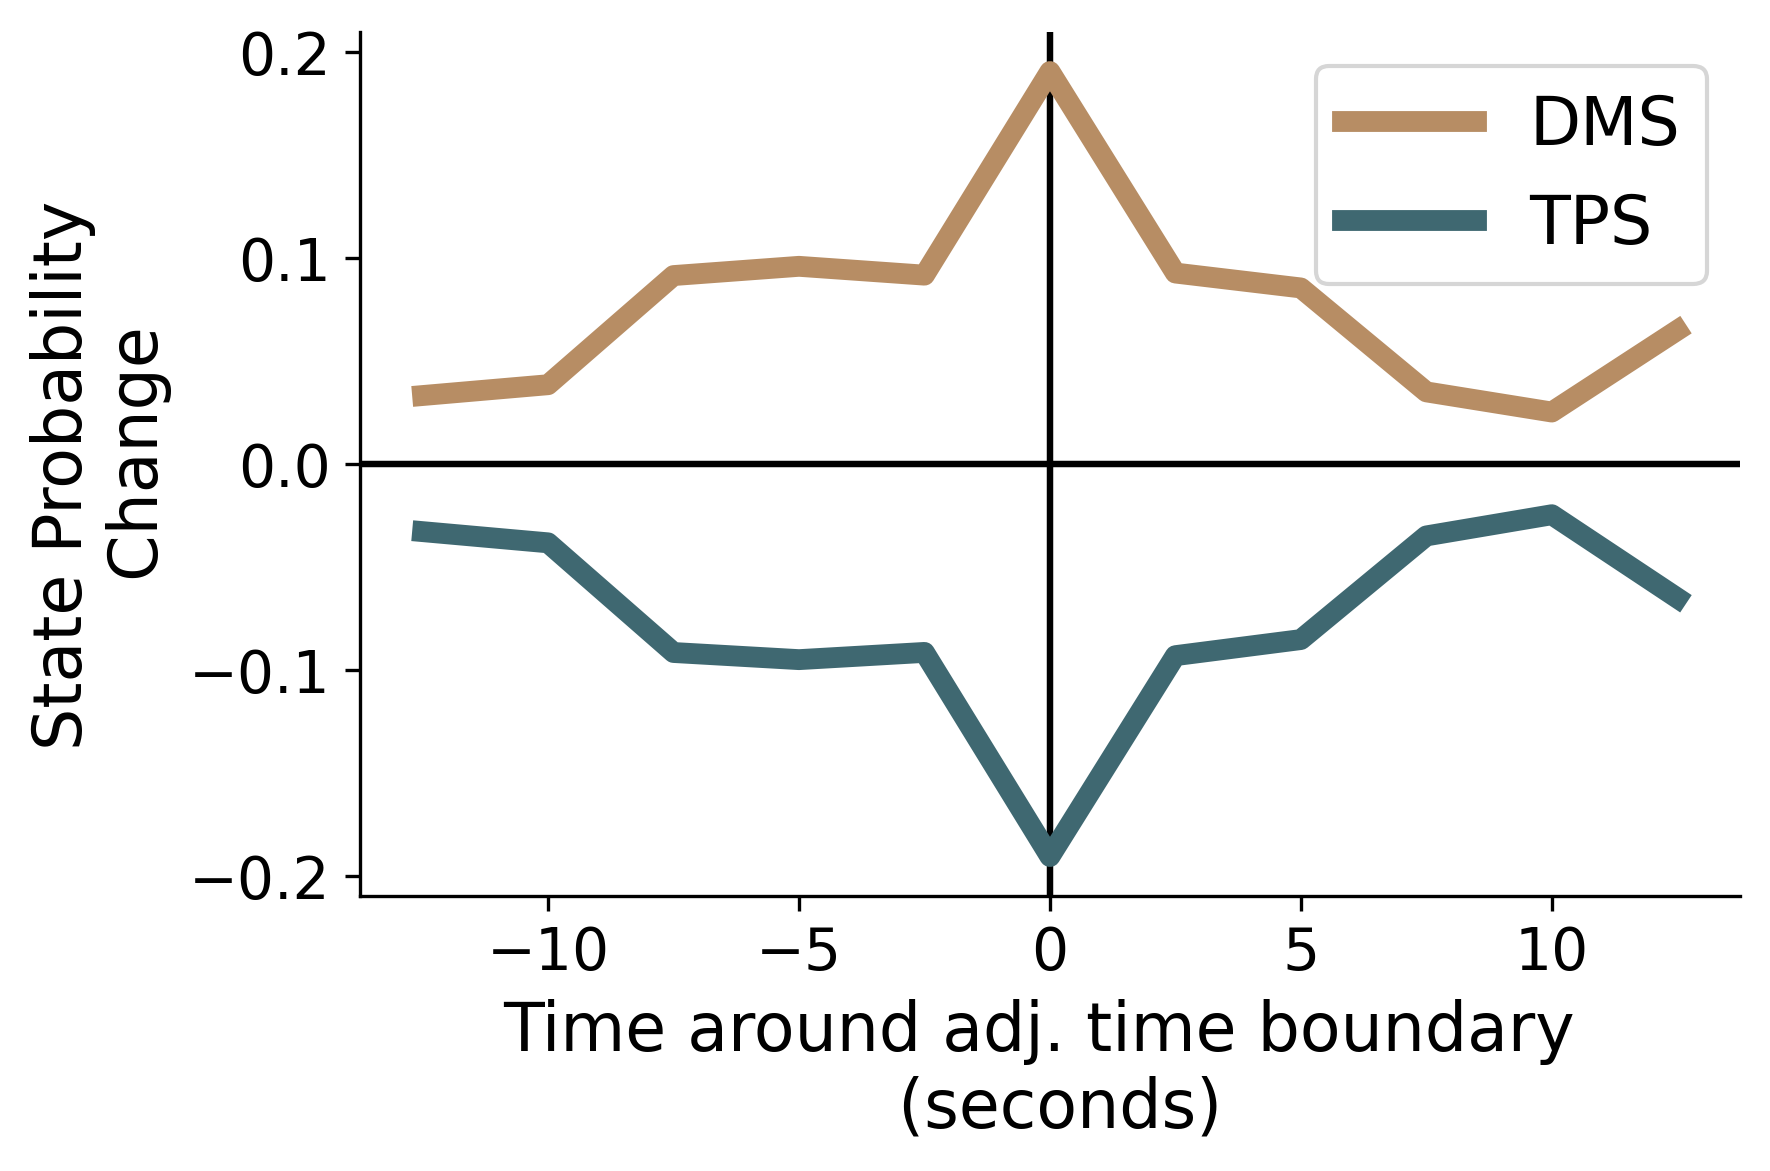

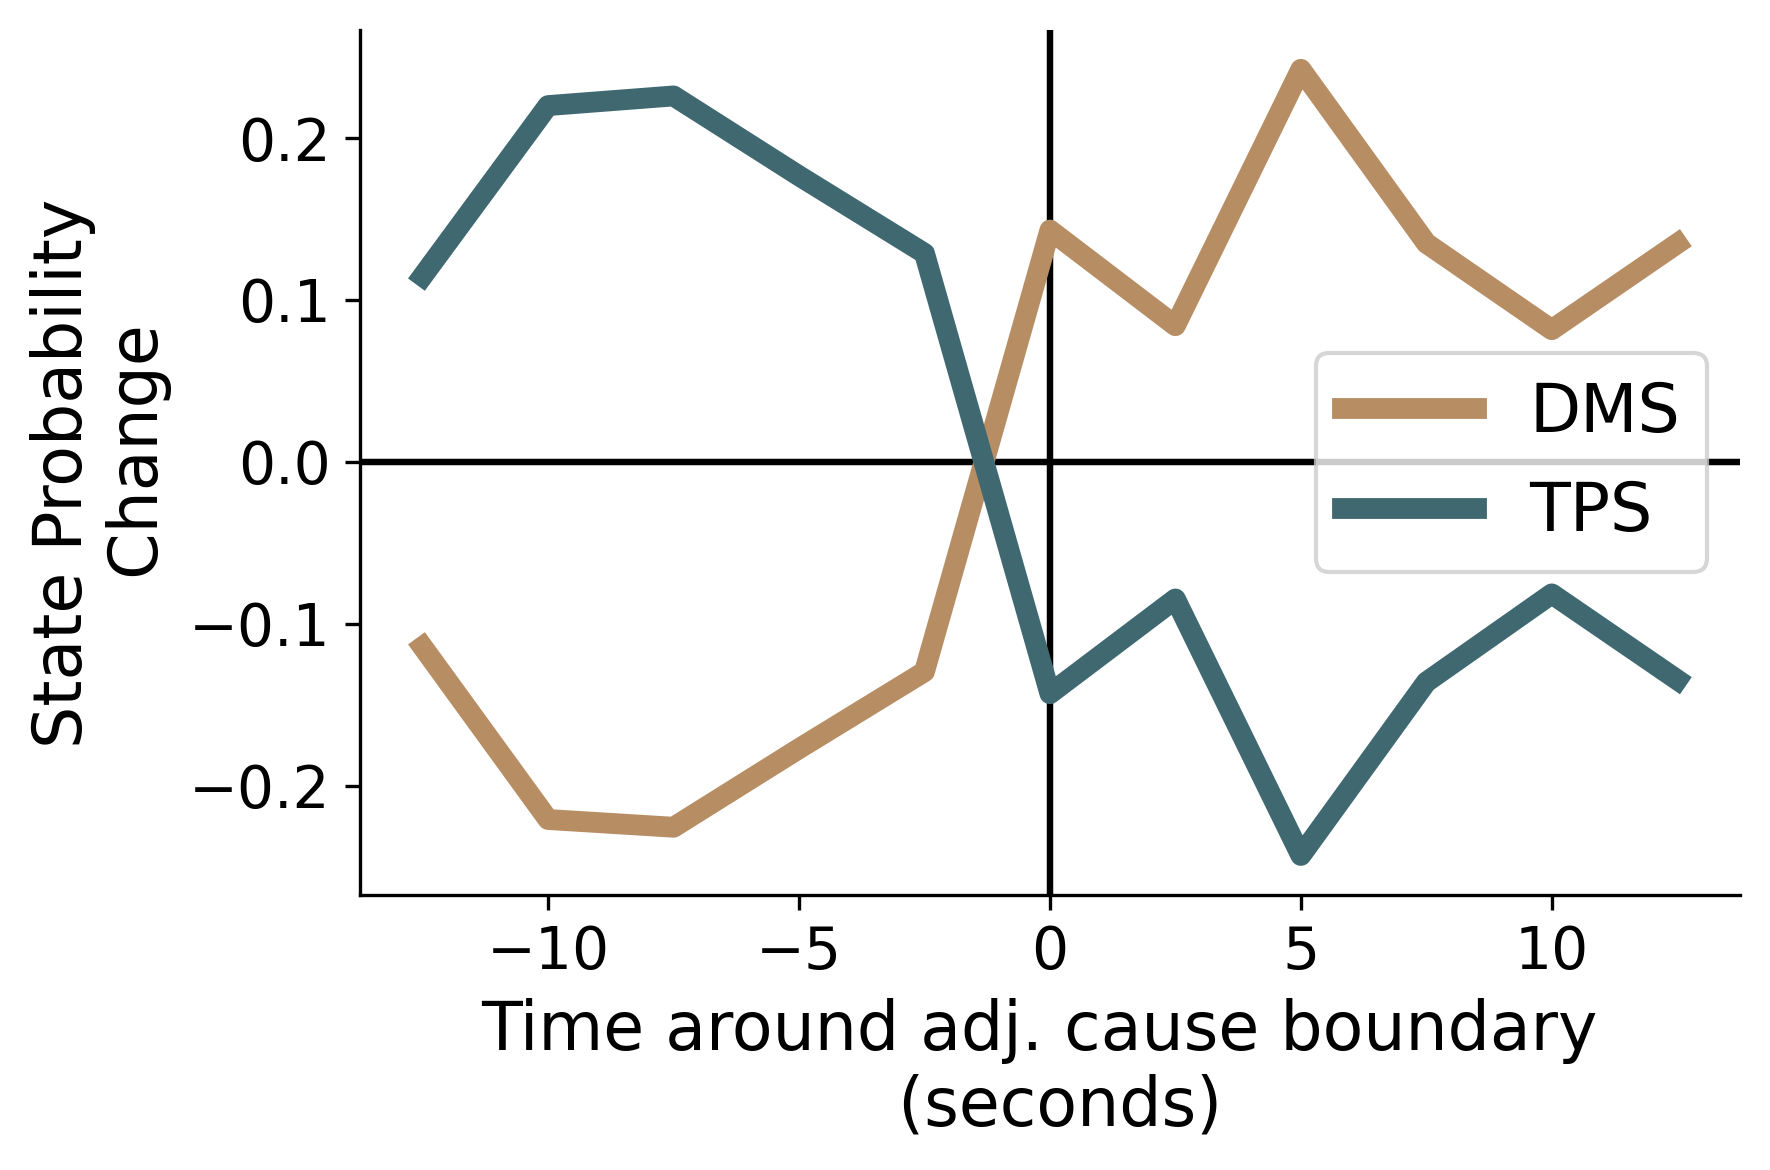

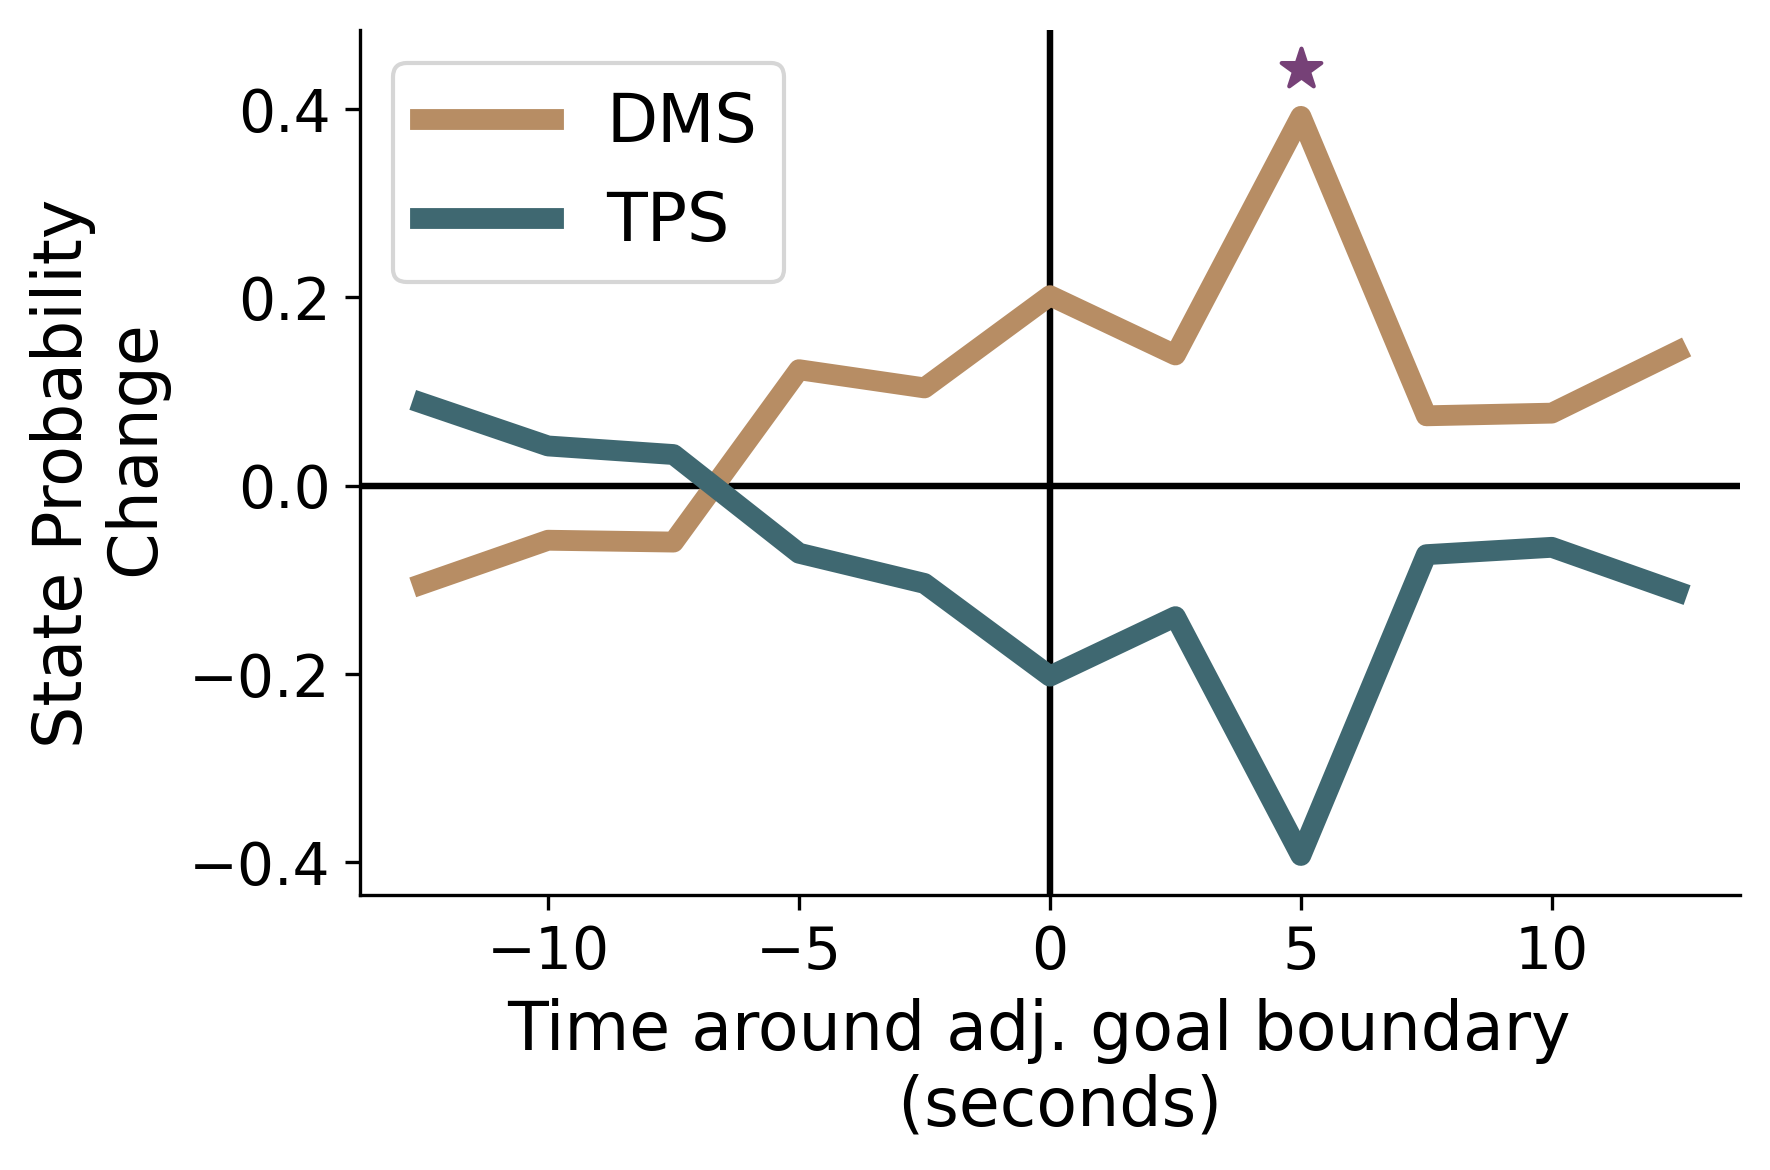

In [ ]:
for stim_count, stim_name in enumerate(stimuli_names):

  fig, axs = plt.subplots(1,figsize=(6,4),dpi=300)

  # fig.suptitle(Dataset+'\n  Global State Probability Around Event Boundaries',fontsize=16)

  for change_count, change_type in enumerate(['DMS', 'TPS']):

    pooled_p_values = all_stimuli_change_types_all_delays_p_values[stim_count][change_count]
    pooled_increases = all_stimuli_change_types_all_delays_differences[stim_count][change_count]

    fdr_corrected_ps_across_delays = stats.false_discovery_control(pooled_p_values)

    axs.plot(np.array(delays)*TR_in_seconds,pooled_increases,linewidth=5,zorder=0,color=cscale[change_count*2],label=change_type)

    axs.axhline(0.,color='black',zorder = -1)
    axs.set_xlabel('Time around adj. '+stim_name+' boundary \n (seconds)',fontsize=16)
    axs.set_ylabel('State Probability \n Change',fontsize=16)

    for count, p_value in enumerate(fdr_corrected_ps_across_delays):
      if p_value < .05:
        axs.scatter(np.array(delays)[count]*TR_in_seconds,np.max(pooled_increases)+0.05,marker='*',color=cscale[3],s=100)




    axs.spines[['top', 'right']].set_visible(False)
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.axvline(0,color='black',zorder = -1)
    axs.legend(fontsize=16)

  fig.tight_layout()

  if save_figures:
    fig.savefig(fig_save_dir+"_"+Dataset+'_'+stim_name+'_Global_Line_Plot',transparent=True,format='png')


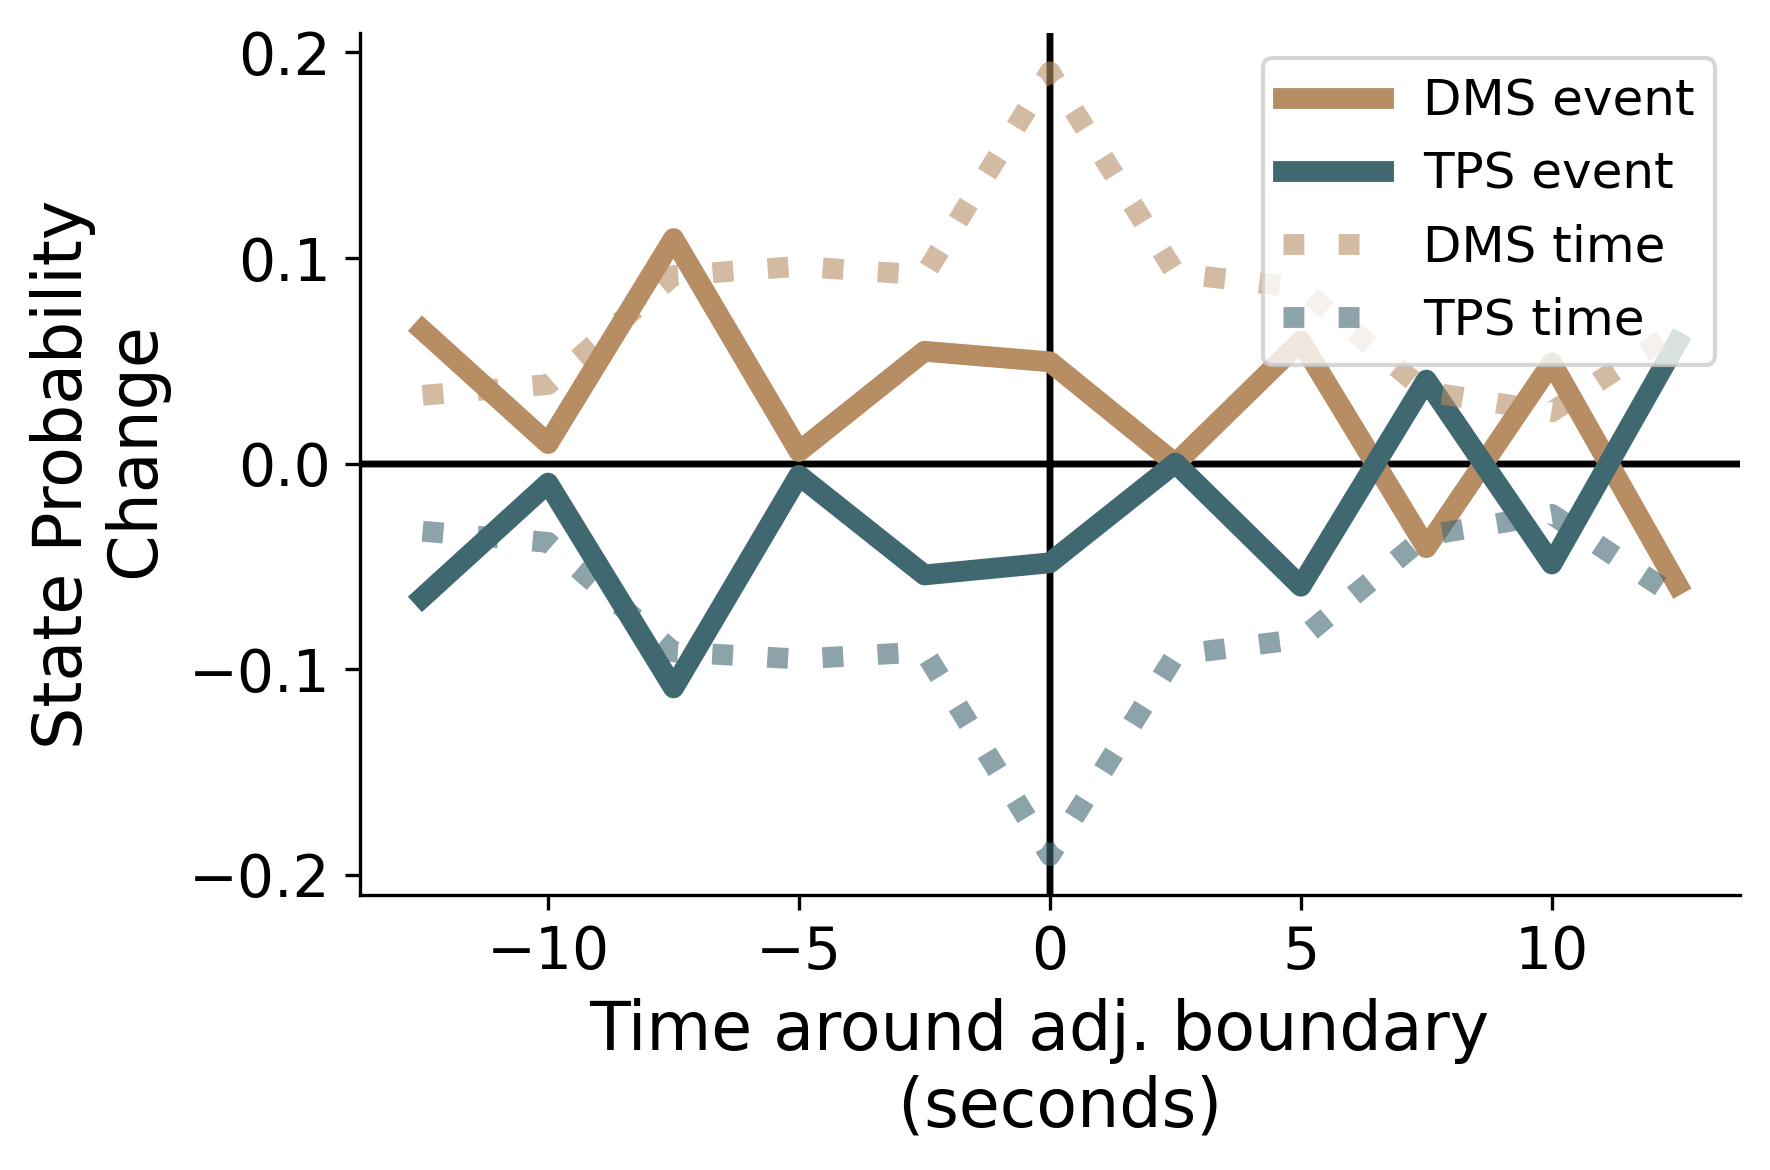

In [ ]:
fig, axs = plt.subplots(1,figsize=(6,4),dpi=300)
overlaid_stimuli_names = [stimuli_names[0],stimuli_names[1]]
overlaid_all_stimuli_change_types_all_delays_p_values = [all_stimuli_change_types_all_delays_p_values[0],all_stimuli_change_types_all_delays_p_values[1]]
overlaid_all_stimuli_change_types_all_delays_differences = [all_stimuli_change_types_all_delays_differences[0],all_stimuli_change_types_all_delays_differences[1]]
for stim_count, stim_name in enumerate(overlaid_stimuli_names):

  # fig.suptitle(Dataset+'\n  Global State Probability Around Event Boundaries',fontsize=16)

  for change_count, change_type in enumerate(['DMS', 'TPS']):

    pooled_p_values = overlaid_all_stimuli_change_types_all_delays_p_values[stim_count][change_count]
    pooled_increases = overlaid_all_stimuli_change_types_all_delays_differences[stim_count][change_count]

    fdr_corrected_ps_across_delays = stats.false_discovery_control(pooled_p_values)
    if stim_count==0:
      axs.plot(np.array(delays)*TR_in_seconds,pooled_increases,linewidth=5,zorder=0,color=cscale[change_count*2],label=change_type+' '+stim_name)
    else:
      axs.plot(np.array(delays)*TR_in_seconds,pooled_increases,linewidth=5,zorder=0,color=cscale[change_count*2],label=change_type+' '+stim_name,linestyle='dotted',alpha=0.6)

    axs.axhline(0.,color='black',zorder = -1)
    axs.set_xlabel('Time around adj. boundary \n (seconds)',fontsize=16)
    axs.set_ylabel('State Probability \n Change',fontsize=16)

    for count, p_value in enumerate(fdr_corrected_ps_across_delays):
      if p_value < .05:
        axs.scatter(np.array(delays)[count]*TR_in_seconds,np.max(pooled_increases)+0.05,marker='*',color=cscale[3],s=100)




    axs.spines[['top', 'right']].set_visible(False)
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.axvline(0,color='black',zorder = -1)
    axs.legend(fontsize=12,loc='upper right')

  fig.tight_layout()

  if save_figures:
    fig.savefig(fig_save_dir+"_"+Dataset+'_'+stim_name+'_OVERLAID_Global_Line_Plot',transparent=True,format='png')


### Produce Global Panel Figure

-3.9081045440462523 -3.9081045440462523


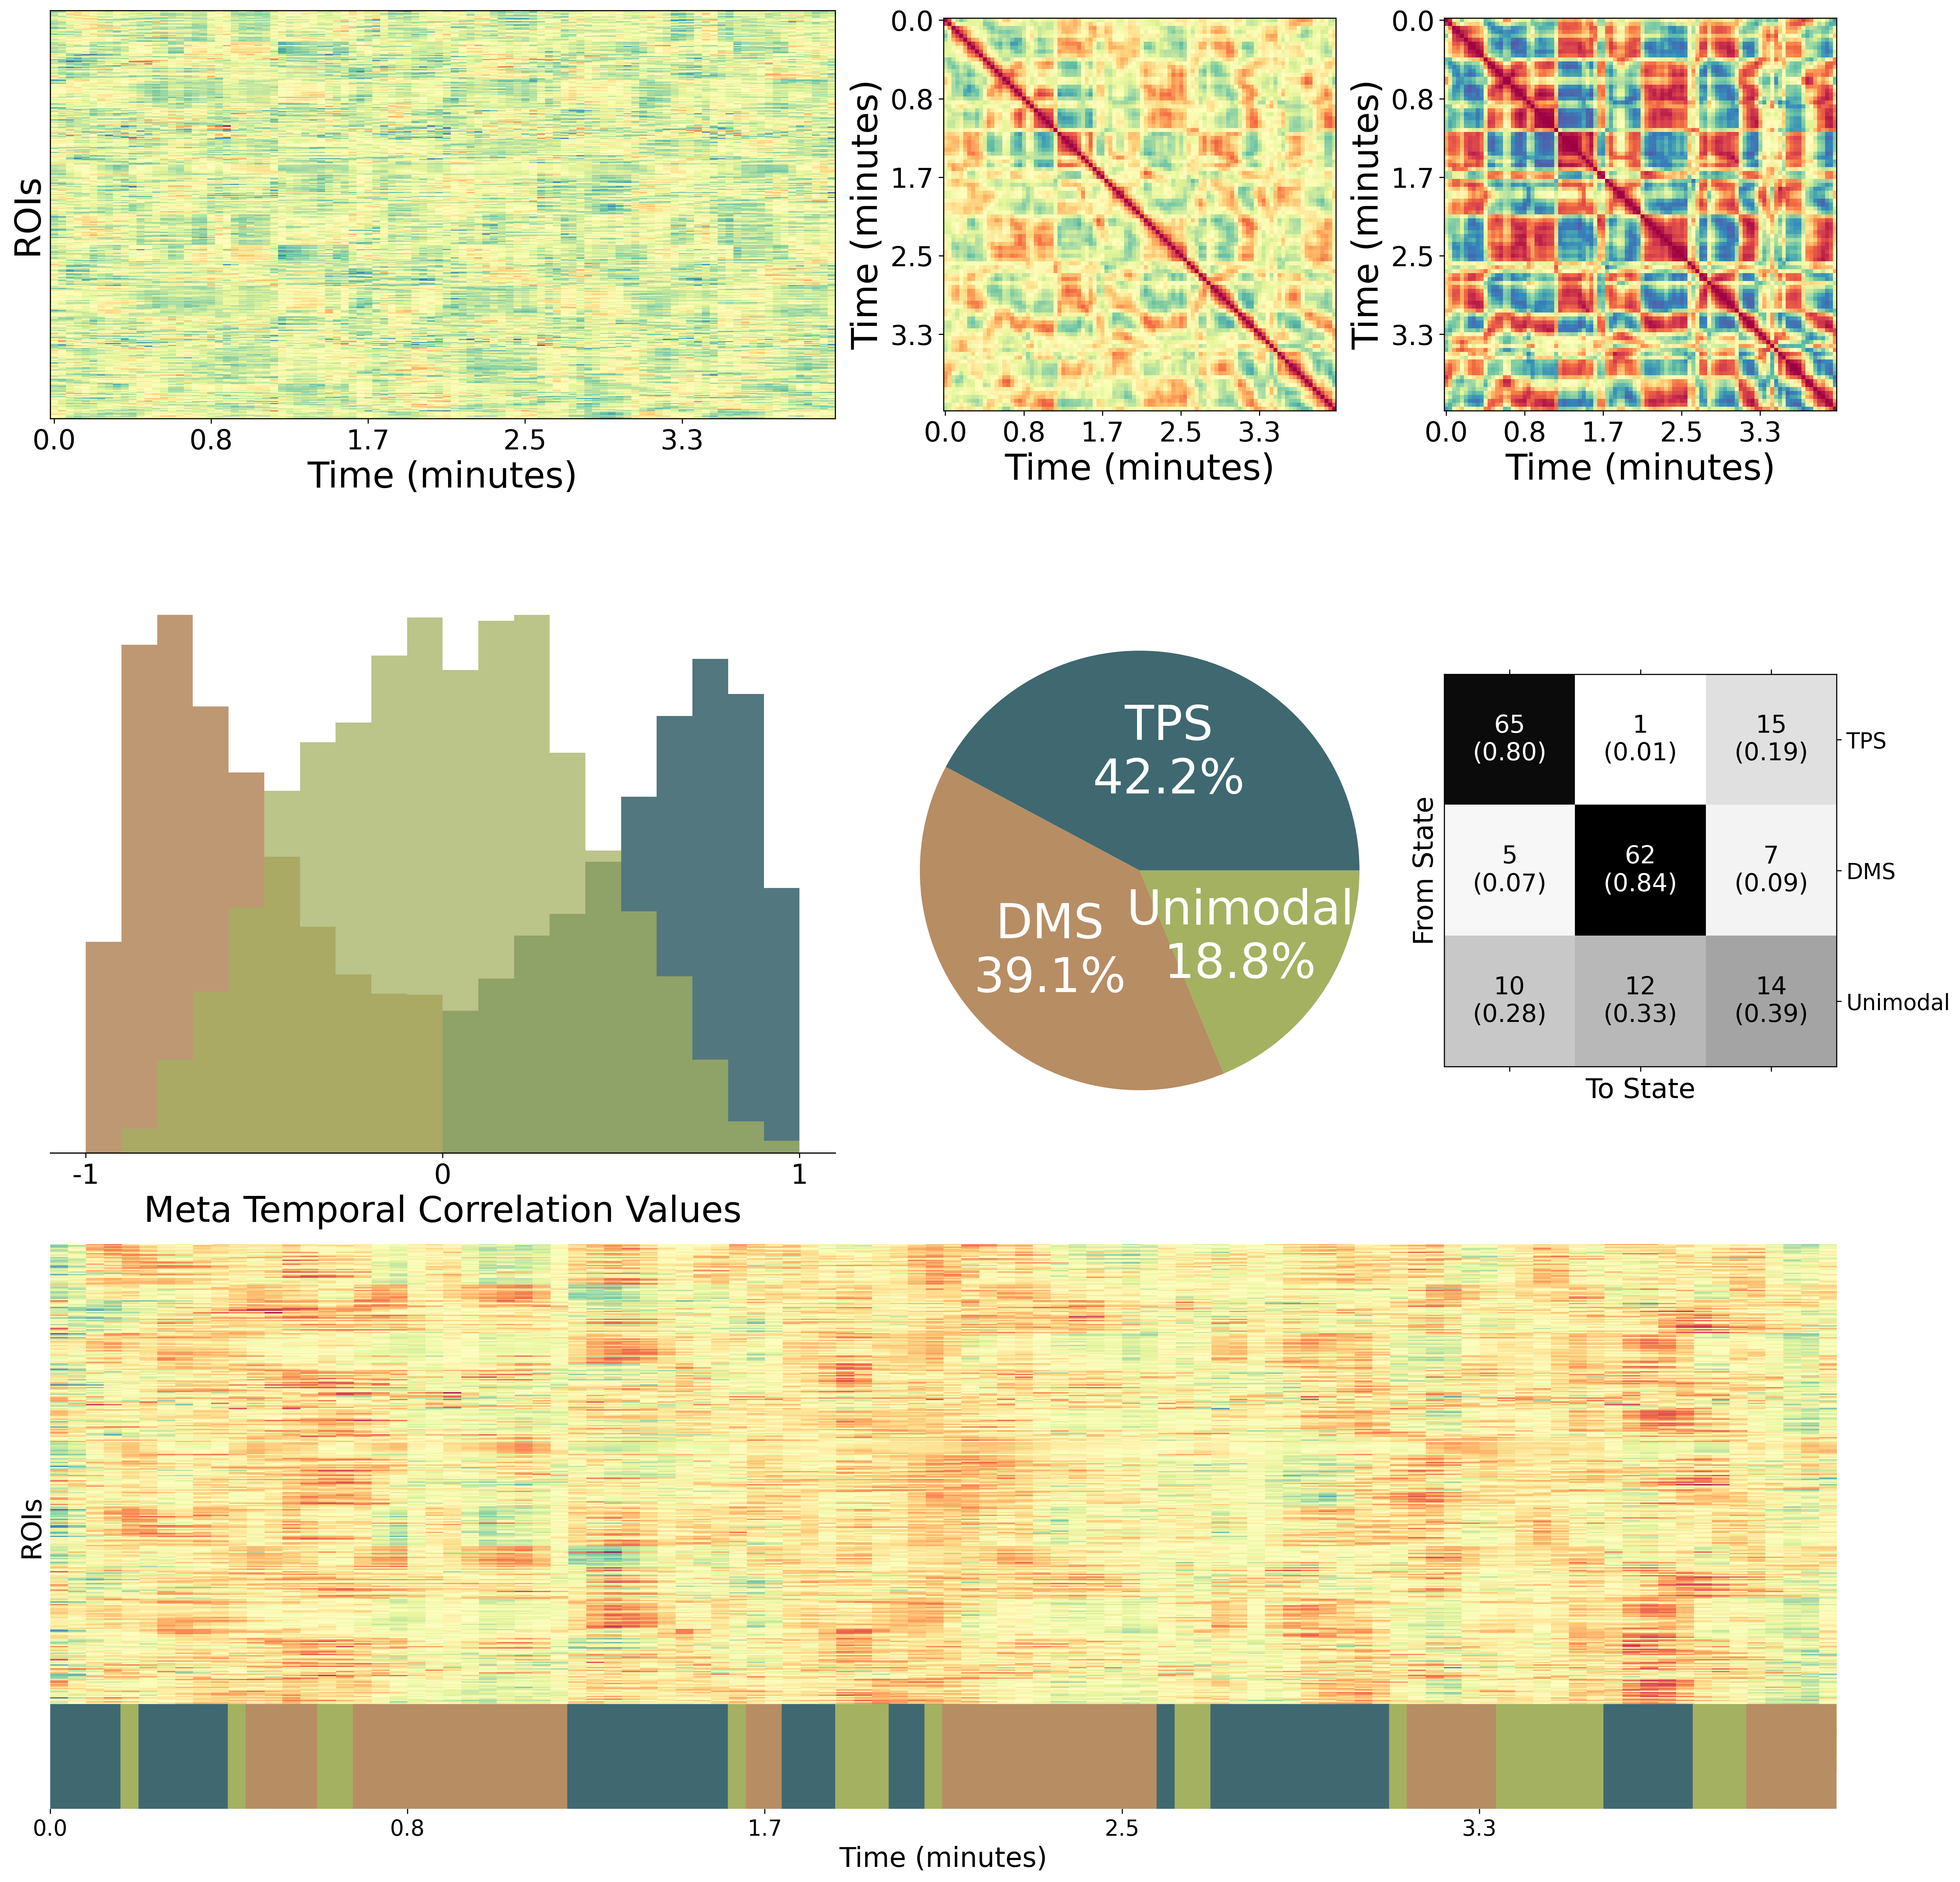

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

start=0
until=100
time_tick_fraction = 20
# Create figure with GridSpec
fig = plt.figure(figsize=(20, 20),dpi=300)
gs = gridspec.GridSpec(3, 3,width_ratios=[2,1,1],height_ratios=[1,1,1])

# Define the axes using GridSpec
axes = []
axes.append(fig.add_subplot(gs[0, 0]))                # Row 0, Col 0
axes.append(fig.add_subplot(gs[0, 1]))               # Row 0, Col 1
axes.append(fig.add_subplot(gs[0, 2]))               # Row 0, Col 2
axes.append(fig.add_subplot(gs[1, 0]))                # Row 1, Col 0
axes.append(fig.add_subplot(gs[1, 1]))                # Row 1, Col 1
axes.append(fig.add_subplot(gs[1, 2]))                # Row 1, Col 2
axes.append(fig.add_subplot(gs[2, :]))                # Row 2, Col 0
# axes.append(fig.add_subplot(gs[2, 2]))                # Row 2, Col 2

########################## TIMESERIES #######################
global_timeseries_colorbar_max = np.max(zscore(roi_averaged_data[:,start:until],axis=0))
global_timeseries_colorbar_min = np.min(zscore(roi_averaged_data[:,start:until],axis=0))
timeseries_plot = axes[0].imshow(zscore(roi_averaged_data[:,start:until],axis=0),aspect=.13,interpolation='none',cmap='Spectral_r')
# axes[0].set_title("ROI_Averaged Timeseries")
axes[0].set_xlabel('Time (minutes)',fontsize=26)
axes[0].set_ylabel('ROIs',fontsize=26)
duration = until - start
axes[0].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[0].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[0].get_xticks()[::time_tick_fraction]
axes[0].set_xticks(ticks)
axes[0].set_yticks([])

TIMESERIES_vmin, TIMESERIES_vmax = timeseries_plot.get_clim()
print(TIMESERIES_vmin,TIMESERIES_vmin)
# fig.colorbar(timeseries_plot)

########################## TbyT CORR MTX #####################
corr_mtx_plot = axes[1].imshow(np.corrcoef(roi_averaged_data[:,start:until].T),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
# axes[1].set_title("Time by time Correlation")
axes[1].set_xlabel('Time (minutes)',fontsize=26)
axes[1].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[1].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[1].get_xticks()[::time_tick_fraction]
axes[1].set_xticks(ticks)

axes[1].set_ylabel('Time (minutes)',fontsize=26)
axes[1].set_yticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[1].set_yticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[1].get_yticks()[::time_tick_fraction]
axes[1].set_yticks(ticks)
# fig.colorbar(corr_mtx_plot)
########################## META CORR MTX ################
meta_corr_mtx_plot = axes[2].imshow(np.corrcoef(np.corrcoef(roi_averaged_data[:,start:until].T)),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
# axes[2].set_title("meta \n Time by time Correlation")
axes[2].set_xlabel('Time (minutes)',fontsize=26)
axes[2].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[2].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[2].get_xticks()[::time_tick_fraction]
axes[2].set_xticks(ticks)

axes[2].set_ylabel('Time (minutes)',fontsize=26)
axes[2].set_yticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[2].set_yticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[2].get_yticks()[::time_tick_fraction]
axes[2].set_yticks(ticks)
# fig.colorbar(meta_corr_mtx_plot)
########################## HISTOGRAMS ########################


##################
ax = axes[3]
full_N, full_bin_edges = np.histogram(meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten(), bins = np.arange(-1,1.1,0.1))

# Now plot the negative and positive parts with the same bins
ax.hist(meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten()[meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten() < 0], bins=full_bin_edges, color=cscale[0], alpha=0.9)#, label='Negative Values')
ax.hist(meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten()[meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten() >= 0], bins=full_bin_edges, color=cscale[2], alpha=0.9)#, label='Positive Values')
#################

ax2 = ax.twinx()
N, bins, hist_patches = ax2.hist(meta_TbyT_corr[np.where(dip_pvals > 0.05)[0], :].flatten(), bins = np.arange(-1,1.1,0.1), alpha=0.75, color=cscale[1])

ax.spines[['left', 'right', 'top']].set_visible(False)
ax2.spines[['left', 'right', 'top']].set_visible(False)

ax.set_xlabel('Meta Temporal Correlation Values',fontsize=26)
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xticks([-1, 0, 1])
ax2.set_xticks([-1, 0, 1])

ax.set_xticklabels([-1, 0, 1],fontsize=20)
ax2.set_xticklabels([-1, 0, 1],fontsize=20)


########################## PIE ###########################
text_properties = {'color': 'white', 'fontsize': 35, 'fontweight': "regular"}

# Custom function to format labels inside the pie
def autopct_with_labels(pct, all_vals):
    total = sum(all_vals)
    absolute = int(round(pct * total / 100.0))  # Compute absolute count
    return f"{event_types[all_vals.index(absolute)]}\n{pct:.1f}%"


# Create a pie chart
wedges, texts, autotexts = axes[4].pie(
    sizes,
    colors=[cscale[2], cscale[0], cscale[1]],
    autopct=lambda pct: autopct_with_labels(pct, sizes),  # Labels + percentages inside
    textprops=text_properties,  # Customize text properties
    radius=1.4,
    pctdistance=.55
)

########################## TRANSITION MATRIX #######################
cax = axes[5].matshow(transition_matrix_np, cmap="Grays")

# annotate
for i in range(num_events):
    for j in range(num_events):
        count = transition_counts_np[i, j]
        prob = transition_matrix_np[i, j]
        if prob < 0.5:
          c = "black"
        else:
          c = "white"
        axes[5].text(j, i, f"{count}\n({prob:.2f})", ha='center', va='center', color=c,fontsize=18)#,rotation=60)

axes[5].set_xticks(range(num_events))
axes[5].set_yticks(range(num_events))
axes[5].set_xticklabels([])
axes[5].set_yticklabels(event_types,fontsize=16)#,rotation=-45)
axes[5].yaxis.tick_right()

axes[5].set_xlabel("To State",fontsize=20)
axes[5].set_ylabel("From State",fontsize=20)

########################## TIMESERIES WITH STATES ######################
axes[6].imshow(roi_averaged_data[:,start:until],
                         extent=[start, until, 0, roi_averaged_data.shape[0]],  # Match x-axis range
                         aspect='auto', alpha=0.95,
                         cmap='Spectral_r', interpolation="None")#, vmin=imvmin, vmax=imvmax)
axes[6].tick_params(top=False, bottom=True, labelbottom=True, labeltop=False)
axes[6].spines[['top', 'right', 'left']].set_visible(False)
axes[6].spines[['bottom']].set_visible(False)


axes[6].set_xlabel('Time (minutes)',fontsize=20)
axes[6].set_ylabel('ROIs',fontsize=20)
duration = until - start
axes[6].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[6].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=16,rotation=0)
ticks = axes[6].get_xticks()[::time_tick_fraction]
axes[6].set_xticks(ticks)
axes[6].set_yticks([])
# axes[6].set_title('Global Timeseries and State Progression')


categories = event_sequence[start:until]
# Define a color mapping for each unique string
color_mapping = {'DMS': cscale[0], 'TPS': cscale[2], 'Unimodal': cscale[1]}
# Convert category array into a list of (start, end, color) segments
bar_sections_dynamic = []
current_label = categories[0]
start_idx = 0
for i in range(1, len(categories)):
    if categories[i] != current_label:
        bar_sections_dynamic.append((start_idx, i, color_mapping[current_label]))
        start_idx = i
        current_label = categories[i]

# Add the final segment
bar_sections_dynamic.append((start_idx, len(categories), color_mapping[current_label]))

# Add a semi-transparent white background for the bar plot
axes[6].add_patch(patches.Rectangle((0, -50), 100, 40, color='white', alpha=0.6, zorder=1))

# Overlay semi-transparent event-style bar plot based on the string array
for bar_start, bar_end, color in bar_sections_dynamic:
    width = bar_end - bar_start
    rect = patches.Rectangle((bar_start, -50), width, 99, color=color, alpha=1, linewidth=1.5, zorder=2)
    axes[6].add_patch(rect)

axes[6].set_ylim(-30, roi_averaged_data.shape[0])

fig.tight_layout()

plt.show()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Global_Panel',transparent=True,format='png')


## Local Scale

### Local AntiCorrelation

In [ ]:

all_sls_state_sizes = []
all_sls_state_means = []
all_sls_template_timeseries = []
all_sls_state_durations = []
all_sls_transition_mtxs = []

for sl in trange(1,n_rois+1):

    concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
    sl_TbyT_corr = np.corrcoef(concat_sl_data.T)
    meta_sl_TbyT_corr = np.corrcoef(sl_TbyT_corr)
    n_timepoints = len(meta_sl_TbyT_corr)
    sl_dips, sl_dip_pvals = [], []

    for i in range(n_timepoints):

      dip, pval = diptest.diptest(meta_sl_TbyT_corr[i,:].flatten())
      sl_dips.append(dip)
      sl_dip_pvals.append(pval)

    sl_dips, sl_dip_pvals = np.asarray(sl_dips), np.asarray(sl_dip_pvals)


    sl_bimodal_timepoint_indices = np.where(sl_dip_pvals < 0.05)[0]
    sl_template_data = concat_sl_data[:, sl_bimodal_timepoint_indices]

    sl_template_mean = np.mean(sl_template_data, axis=1)
    sl_template_data = sl_template_data - sl_template_mean[:,None]

    sl_template_correlations = np.corrcoef(concat_sl_data.T)
    sl_correlation_signs = np.sign(sl_template_correlations[:,0])


    unimodal_roi_bimodal_timepoint_indices = np.where(sl_dip_pvals < 0.05)[0]

    indices_A = np.intersect1d(np.where(sl_correlation_signs>0)[0],unimodal_roi_bimodal_timepoint_indices)
    indices_B = np.intersect1d(np.where(sl_correlation_signs<0)[0],unimodal_roi_bimodal_timepoint_indices)
    indices_C = np.where(sl_dip_pvals > 0.05)[0]

    sl_sizes = [indices_A.shape[0], indices_B.shape[0] , indices_C.shape[0]]
    all_sls_state_sizes.append(sl_sizes)

    A_mean = np.mean(concat_sl_data[:,indices_A])
    B_mean = np.mean(concat_sl_data[:,indices_B])
    C_mean = np.mean(concat_sl_data[:,indices_C])
    sl_means = [A_mean,B_mean,C_mean]
    all_sls_state_means.append(sl_means)


    sizes = [indices_A.shape[0], indices_B.shape[0] , indices_C.shape[0]]

    # assign labels to the events
    events = [(idx, 'Up State') for idx in indices_A] + \
            [(idx, 'Down State') for idx in indices_B] + \
            [(idx, 'Unimodal State') for idx in indices_C]

    # sort events by index
    events.sort()

    state_timeline = np.array([event[1] for event in events])

    condensed_state_timeline = np.array([state_timeline[i] for i in range(len(state_timeline)) if i == len(state_timeline)-1 or state_timeline[i] != state_timeline[i+1]])

    list_condensed_state_timeline = list(condensed_state_timeline)

    # extract event labels in order
    event_sequence = [e[1] for e in events]

    event_types = ['Up State', 'Down State', 'Unimodal State']

    # compute transitions
    event_to_index = {event: i for i, event in enumerate(event_types)}
    num_events = len(event_types)

    transition_counts = np.zeros((num_events, num_events), dtype=int)

    # transition counts
    for i in range(len(event_sequence) - 1):
        from_idx = event_to_index[event_sequence[i]]
        to_idx = event_to_index[event_sequence[i + 1]]
        transition_counts[from_idx, to_idx] += 1


    transition_counts_np = np.zeros((num_events, num_events), dtype=int)

    # transition counts
    for i in range(len(event_sequence) - 1):
        from_idx = event_to_index[event_sequence[i]]
        to_idx = event_to_index[event_sequence[i + 1]]
        transition_counts_np[from_idx, to_idx] += 1

    # normalize
    row_sums = transition_counts_np.sum(axis=1, keepdims=True)
    transition_matrix_np = np.divide(transition_counts_np, row_sums, where=row_sums != 0)
    all_sls_transition_mtxs.append(transition_counts_np)

    # compute durations of successive same-state instances
    durations = {event: [] for event in event_types}

    # count consecutive occurrences
    current_event = event_sequence[0]
    start_idx = [idx for idx, e in events if e == current_event][0]  # Start index of first event

    for i in range(1, len(events)):
        index, event = events[i]  # Extract correct index and event type

        if event == current_event:
            continue  # Continue counting the same event
        else:
            # Store duration of the previous event
            duration = index - start_idx
            durations[current_event].append(duration)

            # Update tracking variables
            current_event = event
            start_idx = index
    all_sls_state_durations.append(durations)

  7%|▋         | 29/400 [00:00<00:10, 35.67it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 29%|██▉       | 115/400 [00:02<00:06, 47.04it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
100%|██████████| 400/400 [00:18<00:00, 21.09it/s]


### Up Down Unimodal State Proportions

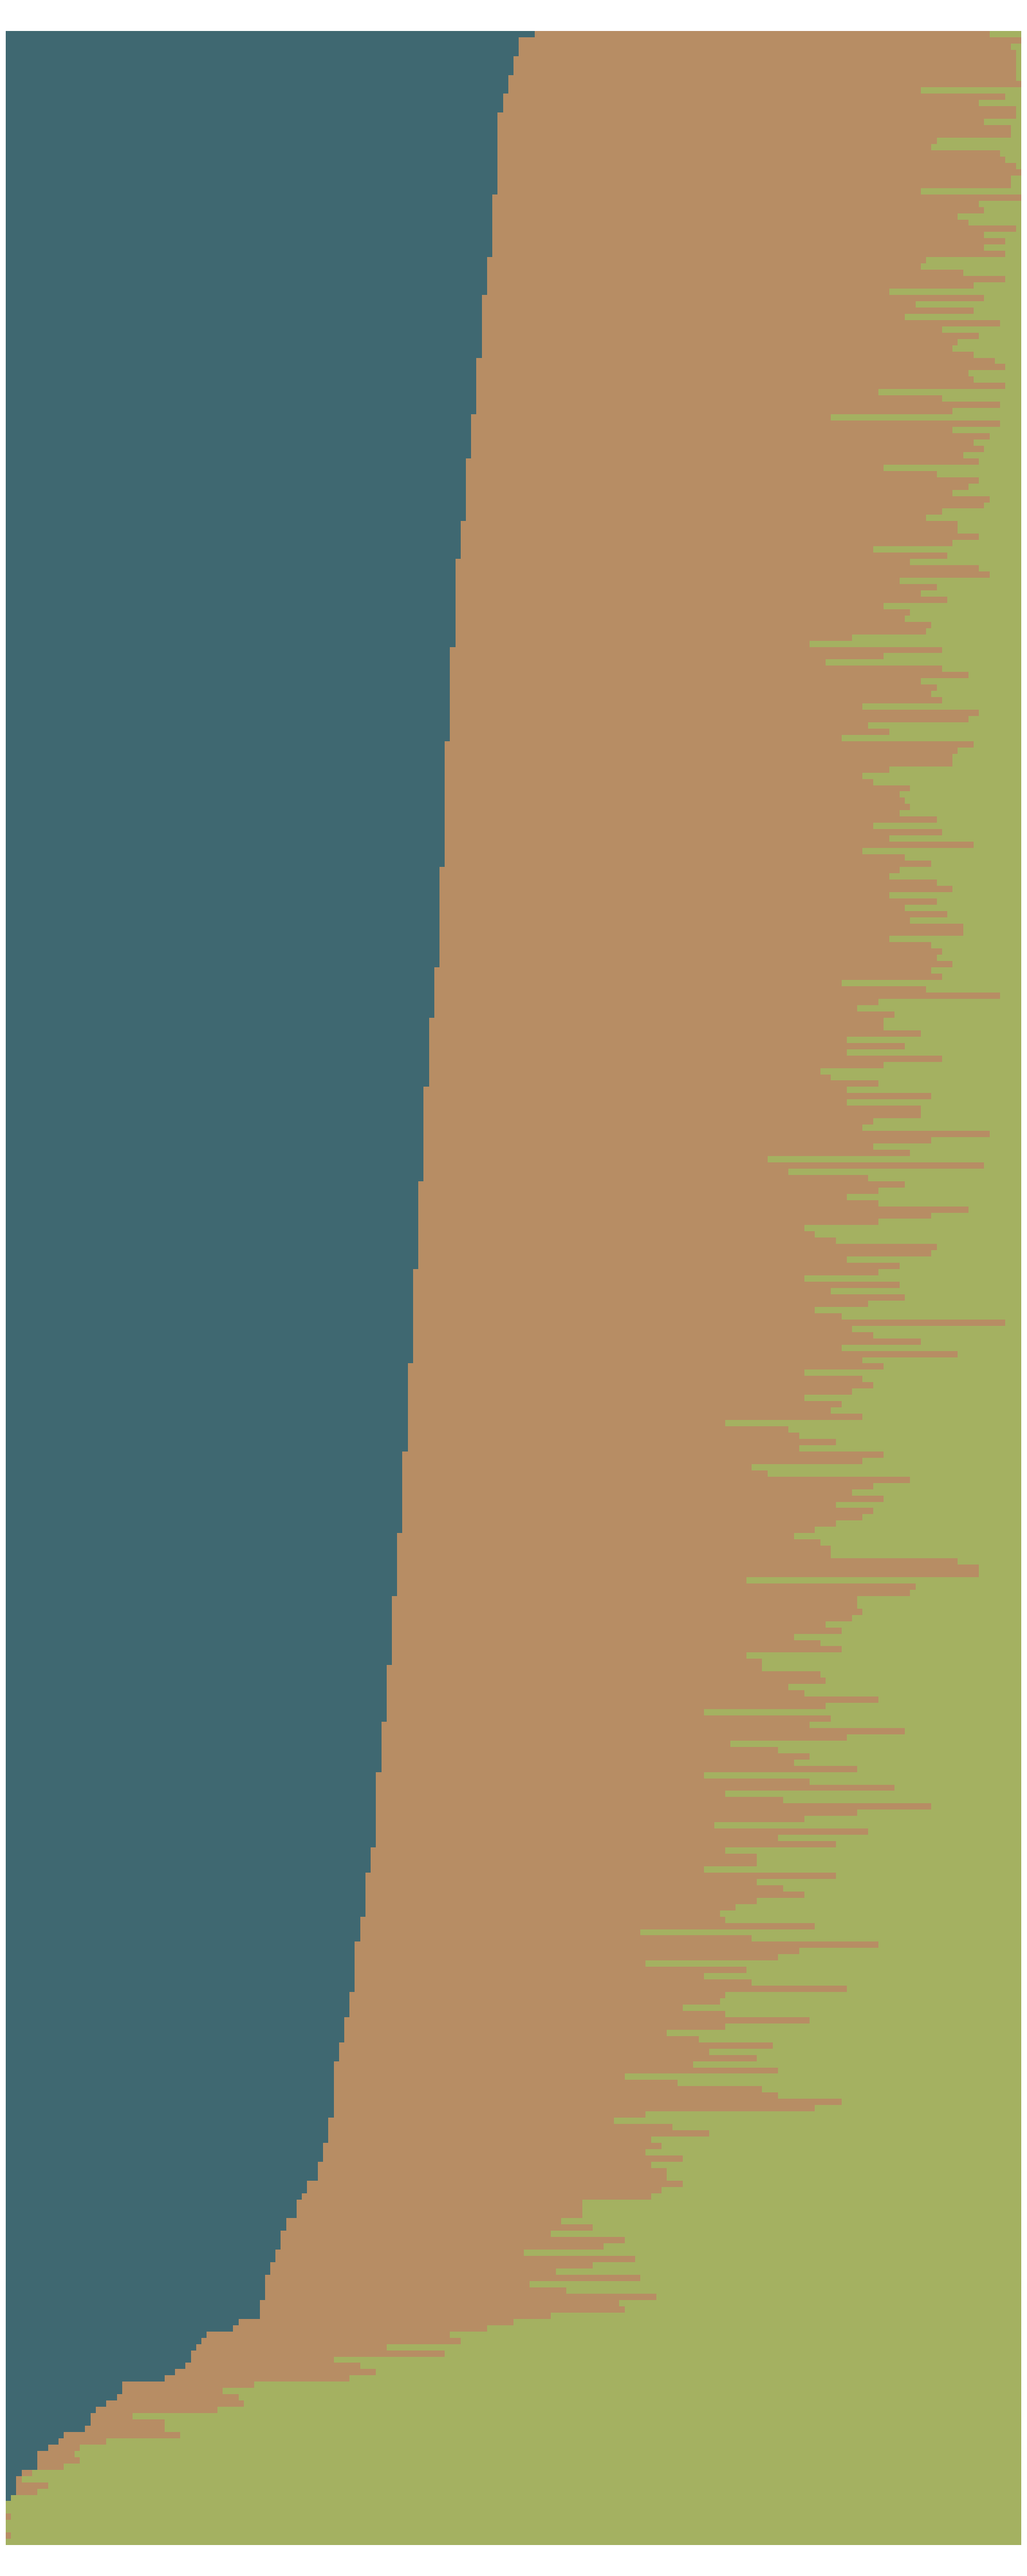

In [ ]:
colors=[cscale[2], cscale[0], cscale[1]]

data = np.array(all_sls_state_sizes)
# Normalize each row to sum to a constant width
normalized_data = data / data.sum(axis=1, keepdims=True)

sort_column = 0
sorted_indices = np.argsort(data[:, sort_column])

# Reorder data accordingly
sorted_data = data[sorted_indices]
normalized_sorted_data = sorted_data / sorted_data.sum(axis=1, keepdims=True)
# Create figure and axes with adjusted dimensions
fig, ax = plt.subplots(figsize=(18, 45))

# Plot stacked bars with improved spacing
for i, row in enumerate(normalized_sorted_data):
    left = 0
    for j, width in enumerate(row):
        ax.barh(i*.8, width, left=left, color=colors[j])
        left += width

# Adjust layout
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.spines['bottom'].set_visible(False)  # Remove top border
ax.spines['left'].set_visible(False)  # Remove right border
plt.margins(x=0.02, y=0.01)  # Reduce margins

# ax.set_ylabel('ROIs',fontsize=52,rotation=270)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Ensure layout fits well
plt.tight_layout()

if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Local_state_proportions',transparent=True,format='png')
plt.show()

### Visualizing Local Brain Activity

In [ ]:
ROI_template_timeseries = []
ROI_univariate_mean_timeseries = roi_averaged_data

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    ROI_template_timeseries.append(template_timeseries_projection)
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    ROI_template_timeseries.append(template_timeseries_projection)
    continue
ROI_template_timeseries = np.array(ROI_template_timeseries)

 28%|██▊       | 110/400 [00:02<00:05, 48.93it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 29%|██▉       | 115/400 [00:02<00:05, 48.88it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
 

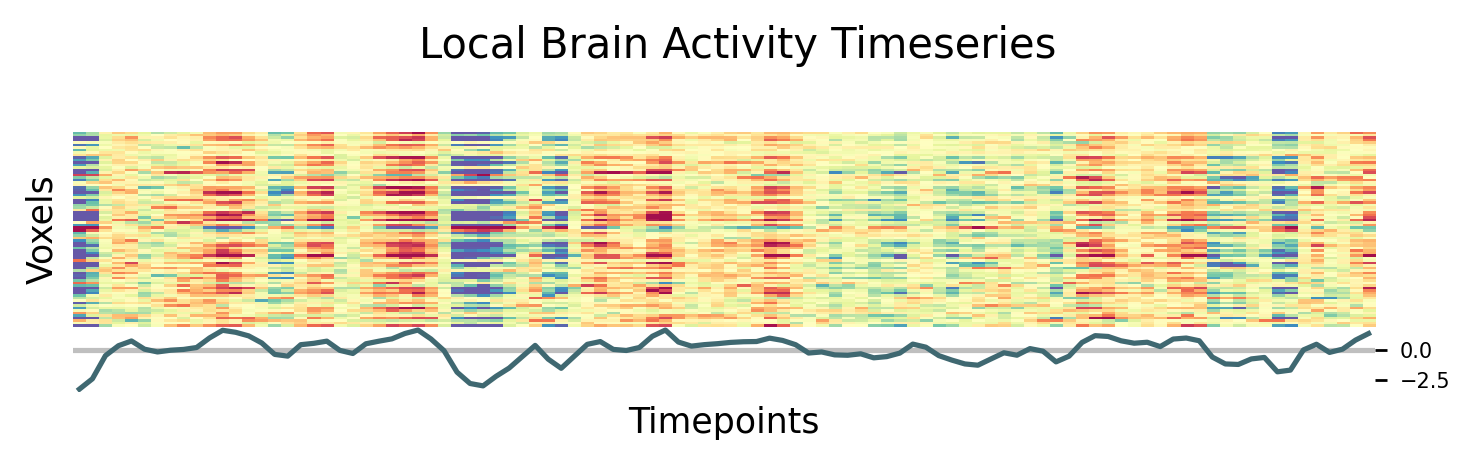

In [ ]:
roi_to_show = (global_template).argsort()[:10]
roi_to_show = roi_to_show[4]
local_roi_data =  get_sl_data(roi_to_show,concat_all_whole_brain_data,atlas_resampled)
sl_mask = np.sum(local_roi_data,axis=1)!=0
clean_local_roi_data = local_roi_data[sl_mask]

local_timeseries_colorbar_max = np.max(clean_local_roi_data)
local_timeseries_colorbar_min = np.min(clean_local_roi_data)
fig = plot_data_with_template('Local Brain Activity Timeseries',clean_local_roi_data,ROI_template_timeseries[roi_to_show],figsize=(6,2),imvmin=-3, imvmax=3,until=100,multicolor=False, scale=2,y_label='Voxels')
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Local_Template_Timeseries',transparent=True,format='png')

### Local Up/Down Voxel Proportions


In [ ]:

ROI_template_updown_proportions = []

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    if template.shape[0] != 0:
      ROI_template_updown_proportions.append([sum((template>0).astype(int)) / template.shape[0], sum((template<0).astype(int)) / template.shape[0]])
    else:
      ROI_template_updown_proportions.append([0.0001,0.0001])
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    if template.shape[0] != 0:
      ROI_template_updown_proportions.append([sum((template>0).astype(int)) / template.shape[0], sum((template<0).astype(int)) / template.shape[0]])
    else:
      ROI_template_updown_proportions.append([0.0001,0.0001])


 28%|██▊       | 113/400 [00:44<01:44,  2.75it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 29%|██▉       | 116/400 [00:46<02:07,  2.23it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 30%|███       | 121/400 [00:48<02:18,  2.02it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: Runti

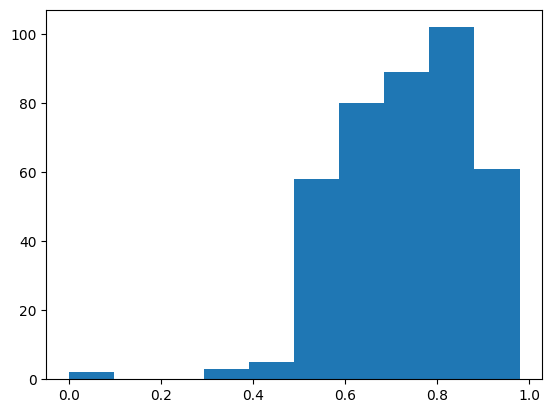

In [ ]:
_=plt.hist([ROI[0] for ROI in ROI_template_updown_proportions])

In [ ]:
# Up State
np.mean([ROI[0] for ROI in ROI_template_updown_proportions]), np.std([ROI[0] for ROI in ROI_template_updown_proportions])

(np.float64(0.7288157246839685), np.float64(0.14069390476985666))

In [ ]:
# Down State
np.mean([ROI[1] for ROI in ROI_template_updown_proportions]), np.std([ROI[1] for ROI in ROI_template_updown_proportions])

(np.float64(0.2661852753160315), np.float64(0.13221983672278217))

### Local Template Explained Variance

In [ ]:

ROI_unimeanreconstruction_exp_vars = []


for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]

  unimean_reconstruction = np.tile(np.mean(clean_concat_sl_data,axis=0),(clean_concat_sl_data.shape[0],1))
  unimean_proportion_variance_explained_mse = proportion_variance_explained_mse(clean_concat_sl_data,unimean_reconstruction)
  ROI_unimeanreconstruction_exp_vars.append(unimean_proportion_variance_explained_mse)

 24%|██▍       | 95/400 [00:00<00:00, 316.22it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered i

In [ ]:
print(f'Mean Var Explained by Local UniMean: {np.nanmean(ROI_unimeanreconstruction_exp_vars)} //// Std: {np.nanstd(ROI_unimeanreconstruction_exp_vars)}')

Mean Var Explained by Local UniMean: 0.27945999720503883 //// Std: 0.18618743575905225


In [ ]:

ROI_template_exp_vars = []

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
  ROI_template_exp_vars.append(proportion_variance_explained_mse(clean_concat_sl_data,template_timeseries))

print(f'Mean Var Explained by Local Templates: {np.nanmean(ROI_template_exp_vars)} //// Std: {np.nanstd(ROI_template_exp_vars)}')

 28%|██▊       | 113/400 [00:44<01:42,  2.80it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 30%|███       | 121/400 [00:46<01:31,  3.05it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipython-input-2458926046.py:56: RuntimeWarning: invalid value encountered in divide
  template_timeseries_p

Mean Var Explained by Local Templates: 0.44319964364552333 //// Std: 0.20333900044800915


In [ ]:
print(f'Mean Var Explained by Local Templates: {np.nanmean(ROI_template_exp_vars)} //// Std: {np.nanstd(ROI_template_exp_vars)}')

Mean Var Explained by Local Templates: 0.44319964364552333 //// Std: 0.20333900044800915


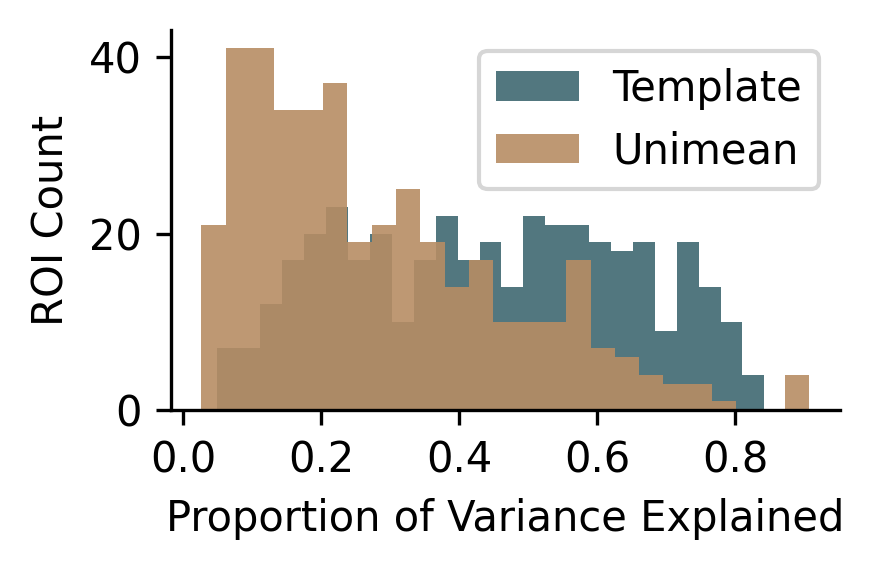

In [ ]:
fig, ax = plt.subplots(figsize=(3,2),dpi=300)
_=ax.hist(np.array(ROI_template_exp_vars),color=cscale[2],bins=25,label='Template',alpha=0.9)
_=ax.hist(ROI_unimeanreconstruction_exp_vars,label='Unimean',alpha=0.9,color=cscale[0],bins=25)
ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.set_ylabel('ROI Count')
ax.set_xlabel('Proportion of Variance Explained')
fig.tight_layout()
ax.legend()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Local_var_exp_mean_vs_template',transparent=True,format='png')


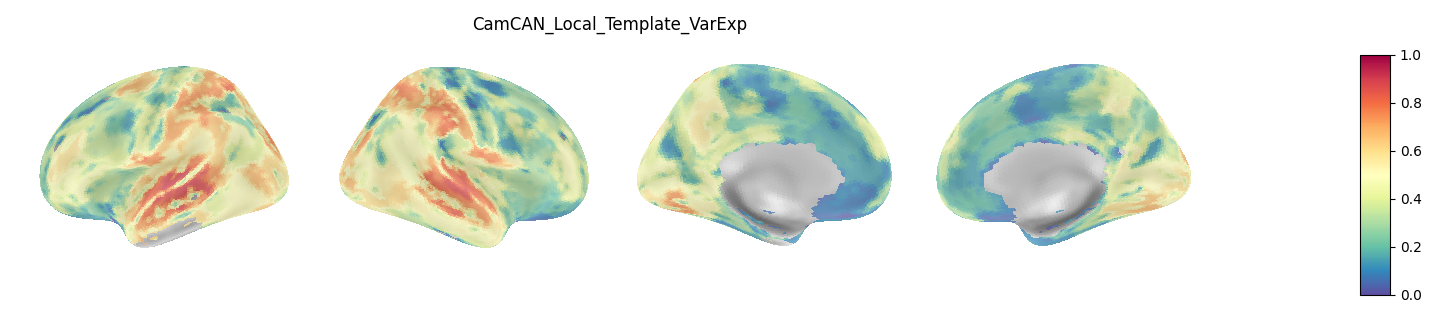

In [ ]:

data = ROI_template_exp_vars

local_temp_var_exp_nii = roi_pattern_to_nifti(data,saving=False,output_path='')
texture_left, texture_right = nifti_to_surface(local_temp_var_exp_nii)
long_plot(texture_left,texture_right,title=Dataset+'_Local_Template_VarExp',saving=save_figures,min_val=0,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)

In [ ]:
atlas_data = atlas_resampled.get_fdata()

network_template_correlations = []
for count, network_ROIs  in enumerate(network_indices):
  empty_volume = np.zeros_like(concat_all_whole_brain_data[:,:,:,0])
  for ROI_idx in network_ROIs:
    network_explained_vars = local_temp_var_exp_nii.get_fdata()[atlas_data == ROI_idx]
  # print(np.corrcoef(univariate_proportion_nii.get_fdata().flatten(),empty_volume.flatten()))
  network_template_correlations.append(np.nanmean(network_explained_vars))

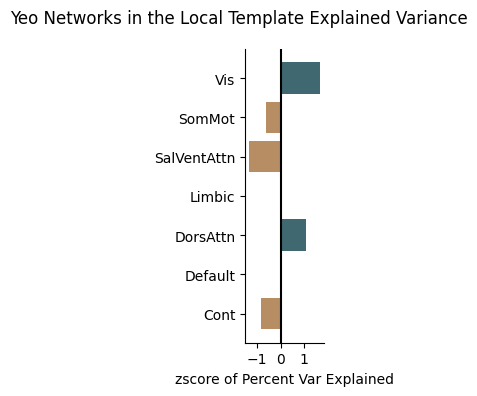

In [ ]:
fig, axs = plt.subplots(1,figsize=(2,4),dpi=100)
fig.suptitle('Yeo Networks in the Local Template Explained Variance')
colors = [cscale[0] if val <= 0 else cscale[2] for val in zscore(network_template_correlations)]
axs.barh(unique_network_labels,zscore(network_template_correlations),color=colors)
axs.set_xlabel('zscore of Percent Var Explained')
axs.axvline(0,c='black')
axs.spines['top'].set_visible(False)  # Remove top border
axs.spines['right'].set_visible(False)  # Remove right border

fig.tight_layout()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Yeo_Networks_Local_Template_Explained_Variance',transparent=True,format='png')


### Local Mean and States

In [ ]:
all_ROIs_up_down_differences = []

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    ROI_template_timeseries.append(template_timeseries_projection)
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)

  up_down_difference = np.mean(clean_concat_sl_data[:,template_timeseries_projection>0]) - np.mean(clean_concat_sl_data[:,template_timeseries_projection<0])
  all_ROIs_up_down_differences.append(up_down_difference)

 27%|██▋       | 108/400 [00:02<00:05, 48.97it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 28%|██▊       | 114/400 [00:02<00:05, 49.67it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
 

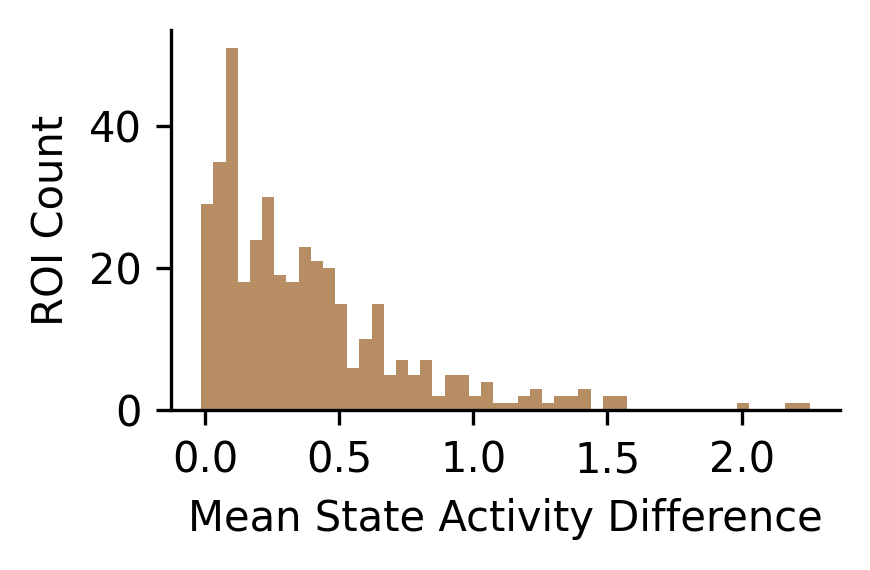

In [ ]:
fig, ax = plt.subplots(figsize=(3,2),dpi=300)
# ax.set_title('ROI Mean and Template Timeseries Correlations')
_=ax.hist(np.array(all_ROIs_up_down_differences),color=cscale[0],bins=50)

ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.set_ylabel('ROI Count')
ax.set_xlabel('Mean State Activity Difference')
fig.tight_layout()

if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Local_template_state_means',transparent=True,format='png')


#### Anticorrelated Voxel Timeseries

In [ ]:
sl = 123
concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
sl_mask = np.sum(concat_sl_data,axis=1)!=0
clean_concat_sl_data = concat_sl_data[sl_mask]


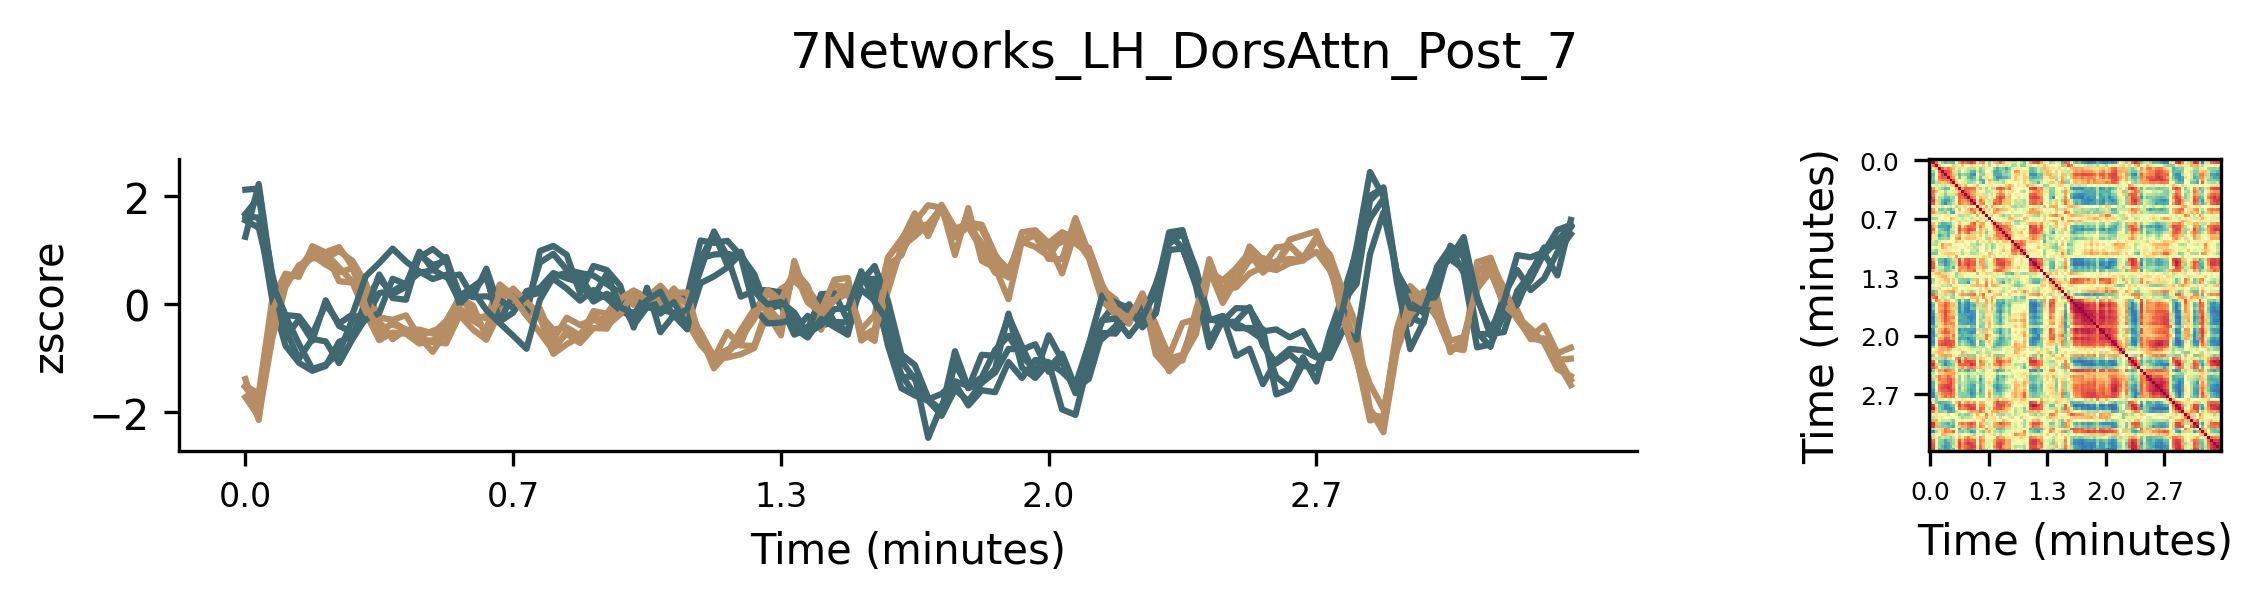

In [ ]:
sl = 75
start = 0
until = 100
time_tick_fraction = 20
duration = until - start

concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
sl_mask = np.sum(concat_sl_data,axis=1)!=0
clean_concat_sl_data = concat_sl_data[sl_mask]




try:
  template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
  template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
  ROI_template_timeseries.append(template_timeseries_projection)
except:
  template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
  template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)

sorted_temp_indices = np.argsort(template)

vox1 = sorted_temp_indices[:5]
vox2 = sorted_temp_indices[template.shape[0]-5:]

fig, ax = plt.subplots(1,2,figsize=(8,2),dpi=300,gridspec_kw={'width_ratios': [2.75,1]})
fig.suptitle(schaefer_labels[sl])


for vox11, vox22 in zip(vox1,vox2):
  ax[0].plot(clean_concat_sl_data[vox22,start:until],color=cscale[0])
  ax[0].plot(clean_concat_sl_data[vox11,start:until],color=cscale[2])

ax[0].spines['top'].set_visible(False)  # Remove top border
ax[0].spines['right'].set_visible(False)  # Remove right border
ax[0].set_ylabel('zscore')
ax[0].set_xlabel('Time (minutes)')
ax[0].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
ax[0].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=8,rotation=0)
ticks = ax[0].get_xticks()[::time_tick_fraction]
ax[0].set_xticks(ticks)




corr_mtx_plot = ax[1].imshow(np.corrcoef(clean_concat_sl_data[:,start:until].T),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
# axes[1].set_title("Time by time Correlation")
ax[1].set_xlabel('Time (minutes)',fontsize=10)
ax[1].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
ax[1].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=6,rotation=0)
ticks = ax[1].get_xticks()[::time_tick_fraction]
ax[1].set_xticks(ticks)

ax[1].set_ylabel('Time (minutes)',fontsize=10)
ax[1].set_yticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
ax[1].set_yticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=6,rotation=0)
ticks = ax[1].get_yticks()[::time_tick_fraction]
ax[1].set_yticks(ticks)


fig.tight_layout()

if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_'+schaefer_labels[sl]+'_example_anticorr_voxel_timeseries',transparent=True,format='png')


#### TTest

In [ ]:
np.mean(clean_concat_sl_data[:,template_timeseries_projection>0],axis=0).shape

(646,)

In [ ]:
all_ROIs_up_down_differences_ttest_results = []

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    ROI_template_timeseries.append(template_timeseries_projection)
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data)
    # continue
  # up_down_difference = np.mean(clean_concat_sl_data[:,template_timeseries_projection>0]) - np.mean(clean_concat_sl_data[:,template_timeseries_projection<0])

  up_mean = np.mean(clean_concat_sl_data[:,template_timeseries_projection>0],axis=0)
  down_mean = np.mean(clean_concat_sl_data[:,template_timeseries_projection<0],axis=0)

  # Two-sample t-test (Welch's t-test - assumes unequal variances)
  t_statistic, p_value = stats.ttest_ind(up_mean, down_mean, equal_var=False)

  all_ROIs_up_down_differences_ttest_results.append([t_statistic,p_value])


 28%|██▊       | 113/400 [01:36<05:24,  1.13s/it]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 29%|██▉       | 116/400 [01:39<04:12,  1.13it/s]/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 30%|███       | 121/400 [01:42<03:27,  1.34it/s]/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: Runti

In [ ]:
nonan_ttest_ps = np.nan_to_num([result[1] for result in all_ROIs_up_down_differences_ttest_results],nan=1)
fdr_corrected_ttest_ps = stats.false_discovery_control(nonan_ttest_ps)
mask = np.zeros(fdr_corrected_ttest_ps.shape)
significant_ROI_indices = np.where(fdr_corrected_ttest_ps<0.05)[0].astype(int)

In [ ]:
all_ROIs_up_down_differences_ttest_results = np.array(all_ROIs_up_down_differences_ttest_results)
significant_results = all_ROIs_up_down_differences_ttest_results[significant_ROI_indices]

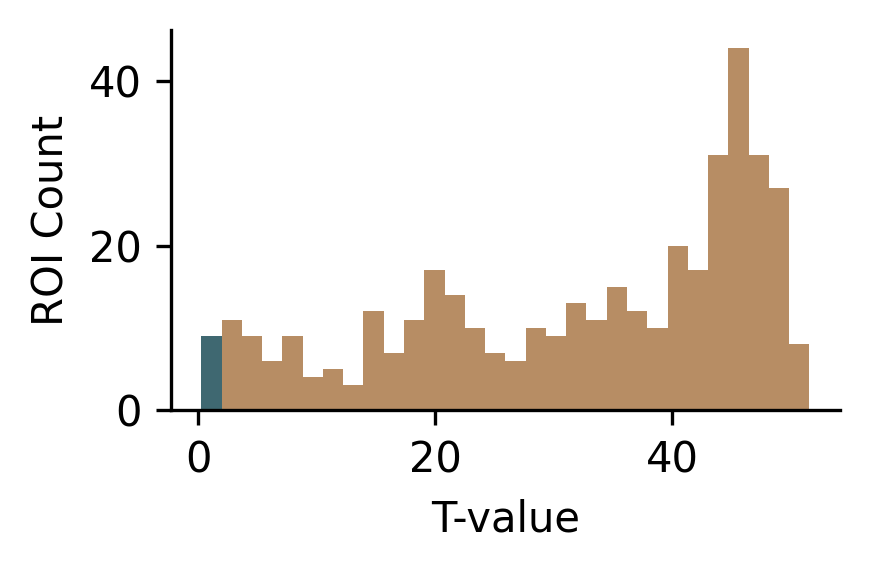

In [ ]:
all_t_values = all_ROIs_up_down_differences_ttest_results[:,0]
significant_t_values = significant_results[:,0]
bins = np.linspace(np.nanmin(all_t_values), np.nanmax(all_t_values), 31)

fig, ax = plt.subplots(figsize=(3,2),dpi=300)

_=ax.hist(all_t_values,color=cscale[2],alpha=1, bins=bins)
_=ax.hist(significant_t_values,color=cscale[0],alpha=1, bins=bins)

# ax.set_title(f'T-Values')
# ax.set_title('Mean Activity Difference Between Anti-correlated States')

ax.spines['top'].set_visible(False)  # Remove top border
ax.spines['right'].set_visible(False)  # Remove right border
ax.set_ylabel('ROI Count')
ax.set_xlabel('T-value')

fig.tight_layout()

if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_'+schaefer_labels[sl]+'_mean_diff_ttest',transparent=True,format='png')


### Project Local Templates on to the Cortex

In [ ]:
empty_volume = np.zeros_like(concat_all_whole_brain_data[:,:,:,0])
atlas_data = atlas_resampled.get_fdata()

for sl in trange(1,n_rois+1):

  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]

  try:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask
  except:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask

    continue

 28%|██▊       | 111/400 [00:02<00:05, 48.36it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
 29%|██▉       | 116/400 [00:02<00:05, 48.56it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, d

In [ ]:
local_template_map_nii = nib.Nifti1Image(empty_volume, affine=atlas_resampled.affine, header=atlas_resampled.header)
if save_figures:
  nib.save(local_template_map_nii, '/content/drive/My Drive/Flipping/niftis/'+str(now).replace(' ','_').replace(':','_').split('.')[0]+Dataset+'_Local_Templates')
print("New NIfTI image saved")

New NIfTI image saved


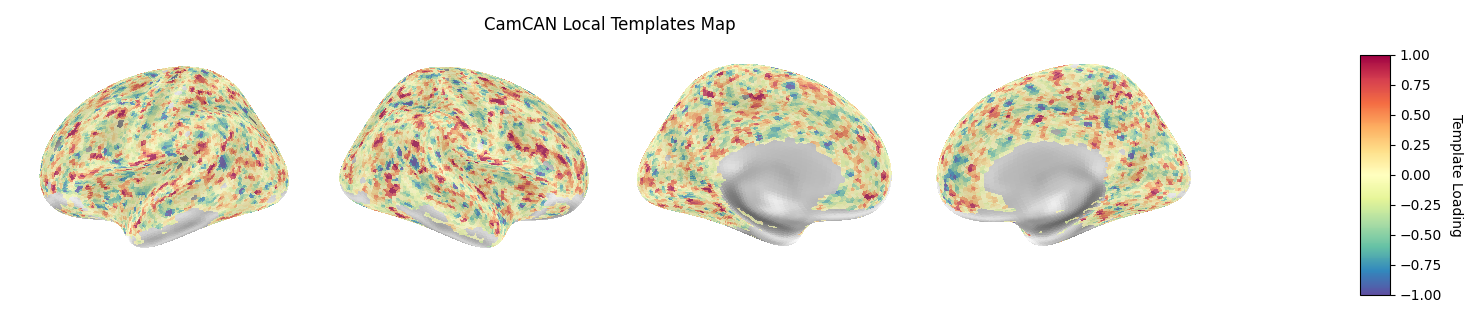

In [ ]:

texture_left, texture_right = nifti_to_surface(local_template_map_nii)
long_plot(texture_left,texture_right,title=Dataset+' Local Templates Map',colorbarlabel='Template Loading',saving=save_figures,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)


### Relation to Stimuli - Up State Probabilities

In [ ]:

all_ROIs_local_neural_state_indices = []
all_ROIs_local_template_timeseries = []
for sl in trange(1,n_rois+1,position=0,desc='Permuting for each ROI...'):
  data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)

  dips, dip_pvals = run_diptest(data)
  data = None
  bimodal_timepoint_indices = np.where(dip_pvals < 0.05)[0]
  unimodal_timepoint_indices = np.where(dip_pvals > 0.05)[0]

  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  cleaned_data = concat_sl_data[np.sum(concat_sl_data,axis=1)!=0.]
  concat_sl_data = None
  try:
    template_mean, template = template_creation(cleaned_data,with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, cleaned_data)
  except:
    try:
      template_mean, template = template_creation(cleaned_data,with_dip=False)
      template_timeseries, template_timeseries_projection = template_projection(template_mean, template, cleaned_data)
    except:
      print('exception, clean_data shape --> ',cleaned_data.shape)
      template = np.random.randn(cleaned_data.shape[0])*0.1
      template_timeseries_projection = np.random.randn(cleaned_data.shape[1])*0.1

  temp_correlation_signs = np.sign(template_timeseries_projection)

  indices_A = np.intersect1d(np.where(temp_correlation_signs>0)[0],bimodal_timepoint_indices)
  indices_B = np.intersect1d(np.where(temp_correlation_signs<0)[0],bimodal_timepoint_indices)
  indices_C = unimodal_timepoint_indices
  sl_state_bounds = [indices_A, indices_B, indices_C]
  all_ROIs_local_neural_state_indices.append(sl_state_bounds)
  all_ROIs_local_template_timeseries.append(template_timeseries_projection)

Permuting for each ROI...:  28%|██▊       | 111/400 [00:04<00:10, 27.23it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
Permuting for each ROI...:  28%|██▊       | 114/400 [00:04<00:10, 27.61it/s]/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Permuting for each ROI...:  29%|██▉       | 117/400 [00:04<00:10, 28.08it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/

In [ ]:
all_ROIs_up_state_indices = [np.where(np.sign(ROI_temp_timeseries)==1)[0] for ROI_temp_timeseries in all_ROIs_local_template_timeseries]

stimuli_delay_all_ROIs_local_neural_state_stim_utils = []
for stimuli_bounds, stimuli_name in zip(stimuli_boundaries, stimuli_names):
  n_permutations = 10000
  delays = [-3,-2,-1,0,1,2,3]
  delay_all_ROIs_local_neural_state_stim_utils =[]
  for delay in tqdm(delays,position=0):
    stimuli_indices = np.where(stimuli_bounds!=0)[0] + delay
    all_ROIs_up_state_stim_real_match = []
    all_ROIs_up_state_stim_expected_match = []
    all_ROIs_up_state_stim_p_vals = []
    all_ROIs_up_state_stim_shuffled_matches = []

    for ROI_up_indices in tqdm(all_ROIs_up_state_indices,position=0):
      real_match, expected_overlap, shuffled_matches, p_val = overlap_permutation_test_optimized(ROI_up_indices,stimuli_indices,n_permutations=n_permutations)
      all_ROIs_up_state_stim_real_match.append(real_match)
      all_ROIs_up_state_stim_expected_match.append(expected_overlap)
      all_ROIs_up_state_stim_p_vals.append(p_val)
      all_ROIs_up_state_stim_shuffled_matches.append(shuffled_matches)

    all_ROIs_up_state_stim_real_match = np.array(all_ROIs_up_state_stim_real_match) / np.array(stimuli_indices).shape[0]
    all_ROIs_up_state_stim_expected_match = np.array(all_ROIs_up_state_stim_expected_match) / np.array(stimuli_indices).shape[0]
    all_ROIs_up_state_stim_p_vals = np.array(all_ROIs_up_state_stim_p_vals)
    all_ROIs_up_state_stim_shuffled_matches = np.array(all_ROIs_up_state_stim_shuffled_matches) / np.array(stimuli_indices).shape[0]
    delay_all_ROIs_local_neural_state_stim_utils.append([all_ROIs_up_state_stim_shuffled_matches,all_ROIs_up_state_stim_real_match])
  stimuli_delay_all_ROIs_local_neural_state_stim_utils.append(delay_all_ROIs_local_neural_state_stim_utils)

100%|██████████| 7/7 [05:26<00:00, 46.58s/it]


In [ ]:

stimuli_all_delays_pooled_differences = []
stimuli_all_delays_pooled_ps = []
for delay_all_ROIs_local_neural_state_stim_utils, stimuli_name in zip(stimuli_delay_all_ROIs_local_neural_state_stim_utils, stimuli_names):

  all_delays_pooled_differences = []
  all_delays_pooled_ps = []
  for delay in range(len(delays)):

    real_mathes = delay_all_ROIs_local_neural_state_stim_utils[delay][1]
    permuted_mathes = delay_all_ROIs_local_neural_state_stim_utils[delay][0]

    all_ROIS_more = []
    all_ROIs_difference= []
    for ROIrealmean,ROIperms in zip(real_mathes, permuted_mathes):
      all_ROIS_more.append(np.sum(ROIperms>ROIrealmean)/n_permutations)
      all_ROIs_difference.append(ROIrealmean-np.mean(ROIperms))

    all_ROIS_more = np.array(all_ROIS_more)
    all_ROIs_difference = np.array(all_ROIs_difference)

    all_delays_pooled_differences.append(all_ROIs_difference)
    all_delays_pooled_ps.append(all_ROIS_more)

  stimuli_all_delays_pooled_differences.append(all_delays_pooled_differences)
  stimuli_all_delays_pooled_ps.append(all_delays_pooled_ps)

In [ ]:
all_stimuli_all_delays_map_arrays = []
for all_delays_pooled_ps,all_delays_pooled_differences in zip(stimuli_all_delays_pooled_ps,stimuli_all_delays_pooled_differences):
  all_delays_map_arrays = []
  for delay_pooled_ps, delay_pooled_diffs in zip(all_delays_pooled_ps,all_delays_pooled_differences):
    filtered_delay_pooled_diffs = delay_pooled_diffs
    fdr_pooled_ps = stats.false_discovery_control(delay_pooled_ps)
    filtered_delay_pooled_diffs[fdr_pooled_ps>0.05] = np.nan
    all_delays_map_arrays.append(filtered_delay_pooled_diffs)
  all_stimuli_all_delays_map_arrays.append(all_delays_map_arrays)

In [ ]:
print('Out of all ROIs (400)')
all_stimuli_percent_active_at_delays = []
for stimuli_name, all_delays_map_arrays in zip(stimuli_names,all_stimuli_all_delays_map_arrays):
  all_delays_map_arrays = np.nan_to_num(all_delays_map_arrays)
  all_active_rois = np.where(np.sum(all_delays_map_arrays,axis=1)>0)[0]
  percent_active_at_delays = [np.where(delays_map_arrays>0)[0].shape[0] / 400 for delays_map_arrays in all_delays_map_arrays]
  print(stimuli_name,': ',percent_active_at_delays)
  all_stimuli_percent_active_at_delays.append(percent_active_at_delays)

Out of all ROIs (400)
event :  [0.0, 0.0, 0.0, 0.0, 0.0025, 0.0, 0.0]
time :  [0.0, 0.0, 0.0, 0.025, 0.1175, 0.0075, 0.0]
cause :  [0.0725, 0.0075, 0.0, 0.03, 0.065, 0.0, 0.0]
goal :  [0.0, 0.0, 0.0, 0.0, 0.0175, 0.0, 0.0]


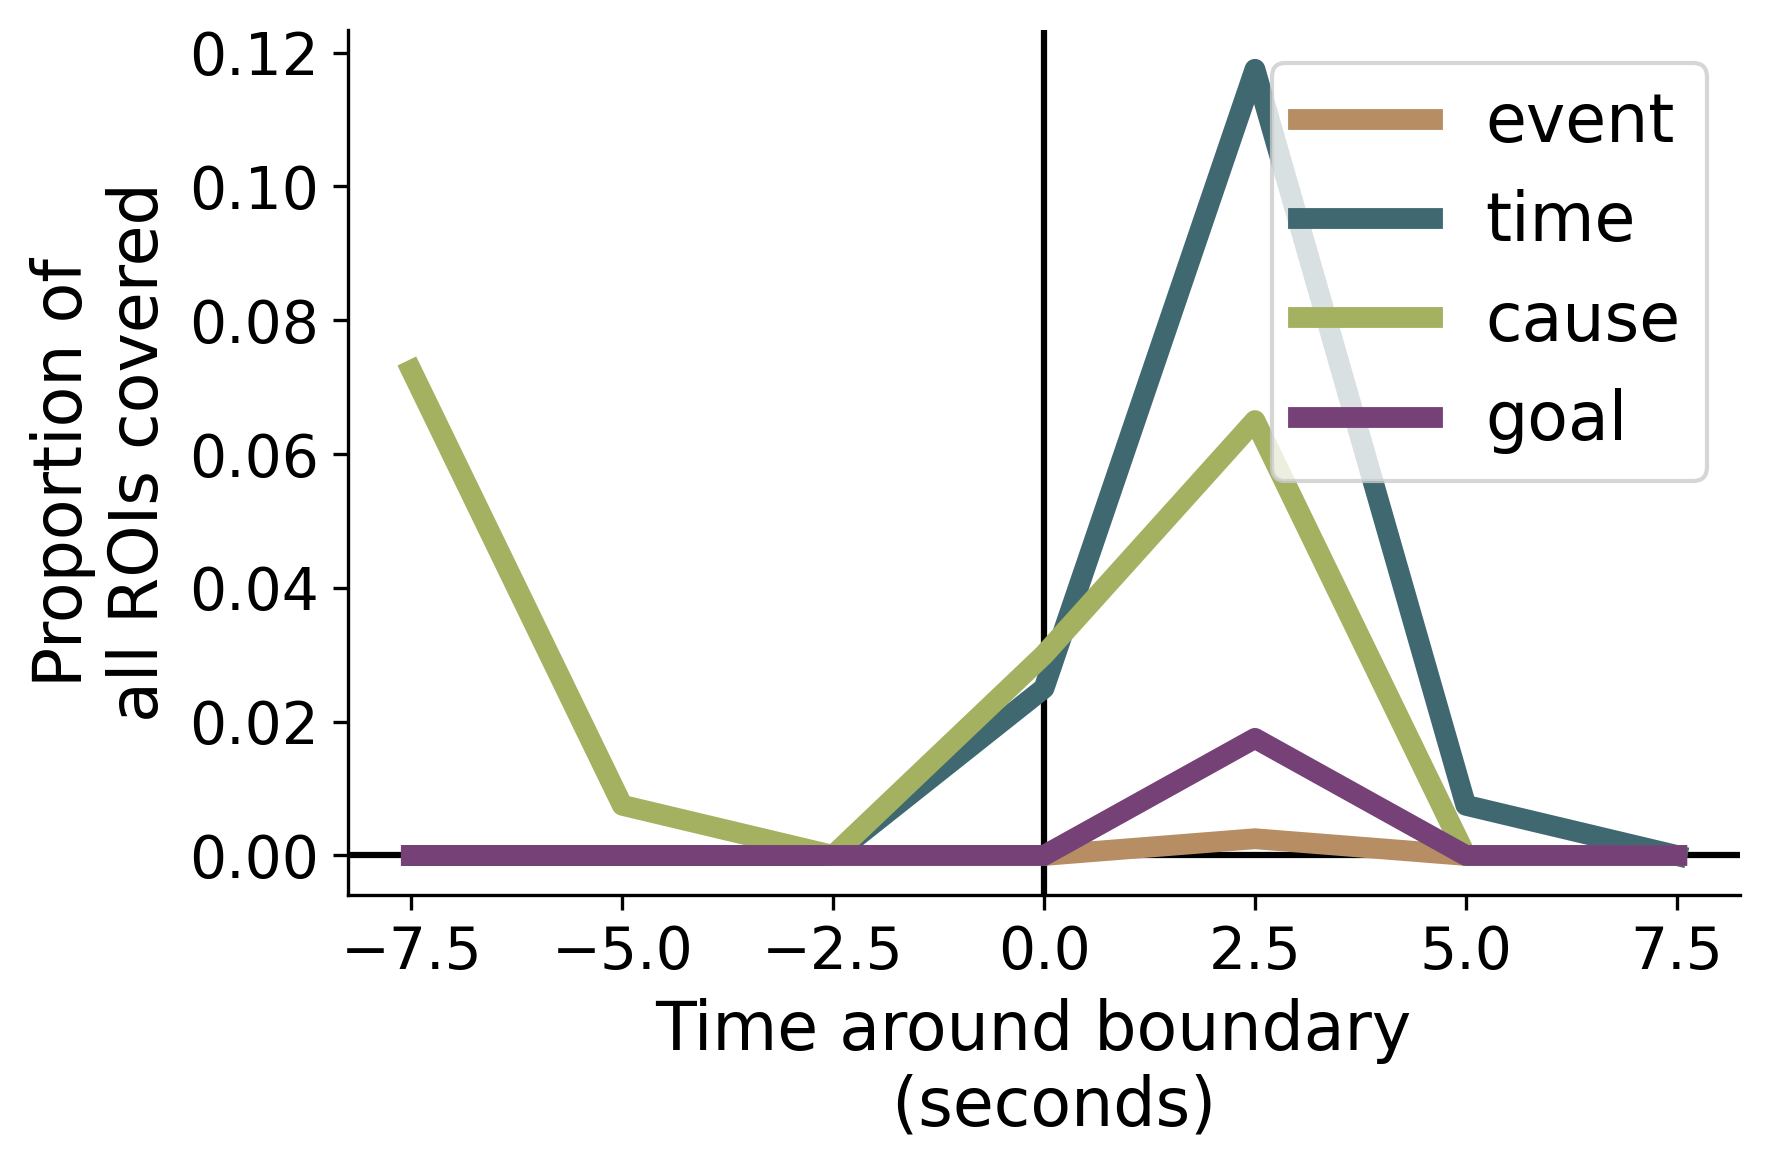

In [ ]:
fig, axs = plt.subplots(1,figsize=(6,4),dpi=300)
colors = np.array([0,2,1,3,4])

# fig.suptitle(Dataset+'\n  Global State Probability Around Event Boundaries',fontsize=16)
for stimuli_percent_active_at_delays, name,color in zip(all_stimuli_percent_active_at_delays,stimuli_names,colors):
  axs.plot(np.array(delays)*TR_in_seconds,np.array(stimuli_percent_active_at_delays),linewidth=5,zorder=0,color=cscale[color],label=name)

axs.axhline(0.,color='black',zorder = -1)
axs.set_xlabel('Time around boundary \n (seconds)',fontsize=16)
axs.set_ylabel('Proportion of \n all ROIs covered',fontsize=16)

axs.spines[['top', 'right']].set_visible(False)
axs.tick_params(axis='both', which='major', labelsize=14)
axs.axvline(0,color='black',zorder = -1)

axs.legend(fontsize=16)
fig.tight_layout()
if save_figures:
  fig.savefig(fig_save_dir+"_"+'stimuli_local_coverage.png', dpi=300, transparent=True, bbox_inches='tight')


New NIfTI image saved


/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:92: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:95: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)


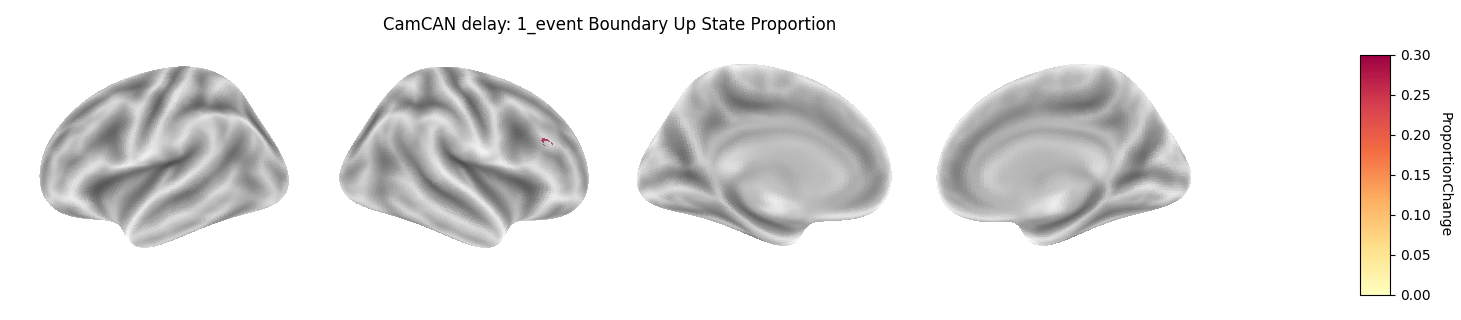

New NIfTI image saved


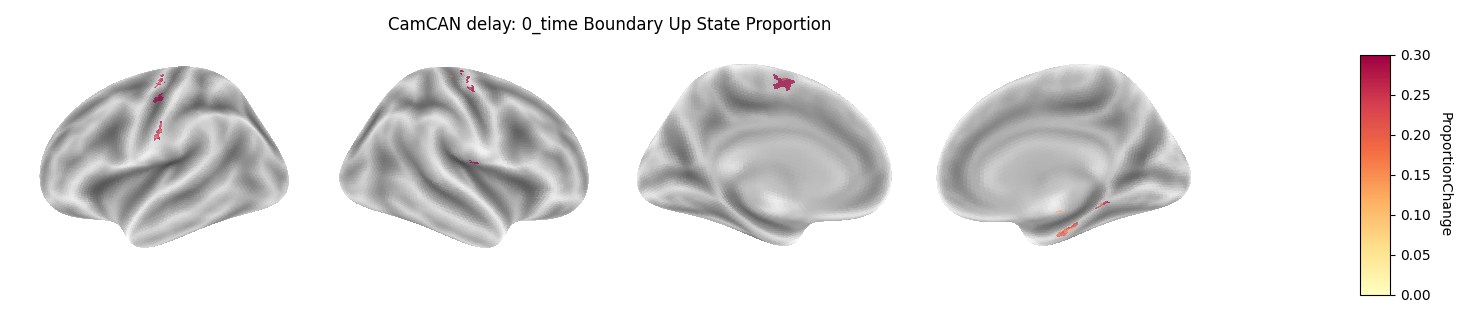

New NIfTI image saved


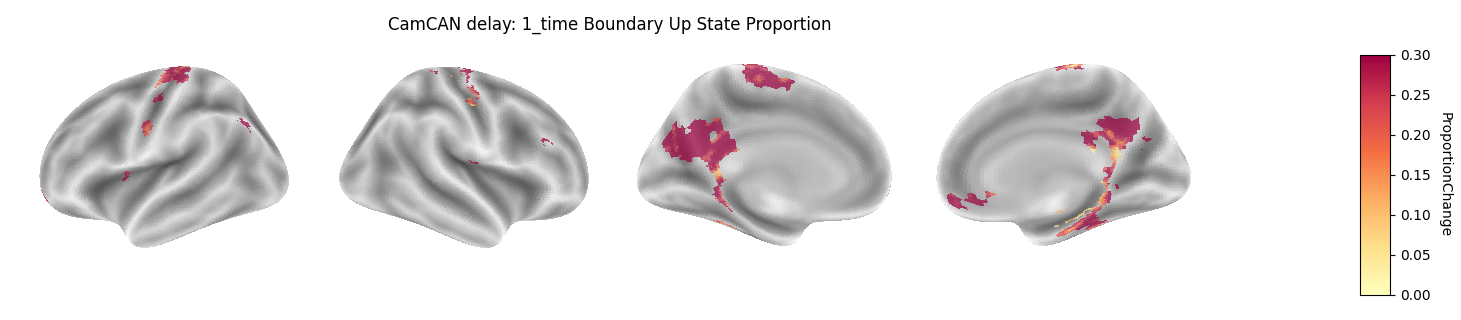

New NIfTI image saved


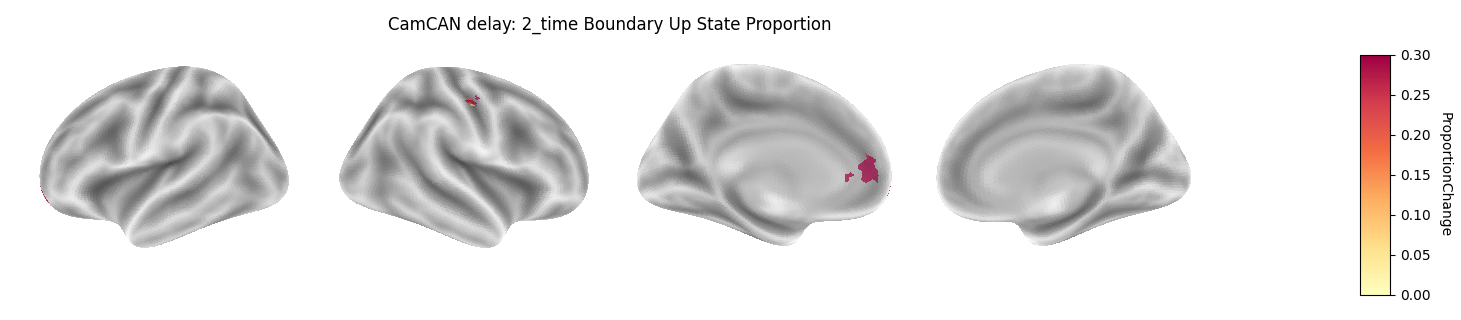

New NIfTI image saved


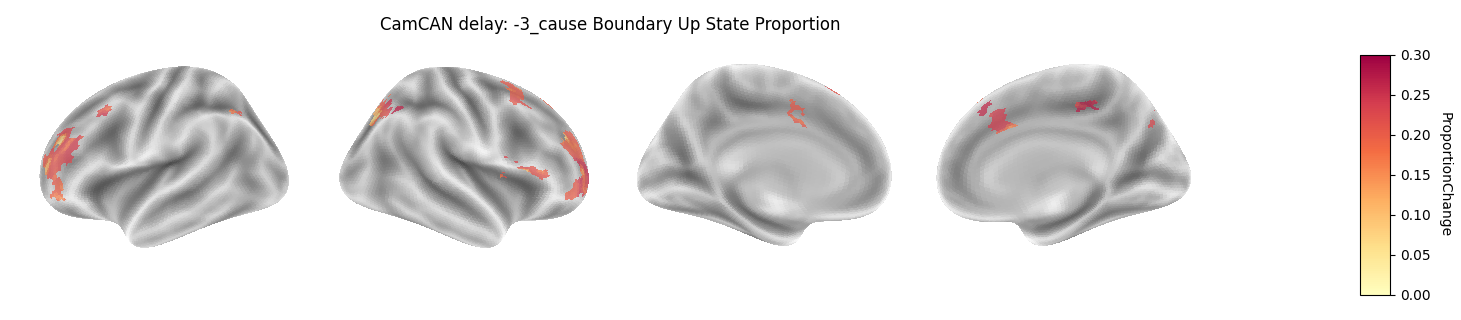

New NIfTI image saved


/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:92: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)
/usr/local/lib/python3.11/dist-packages/nilearn/plotting/img_plotting.py:95: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)


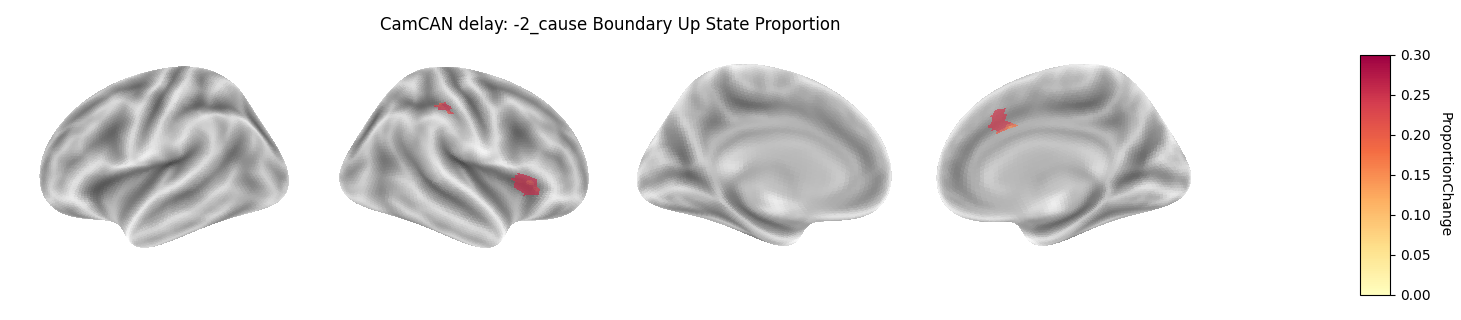

New NIfTI image saved


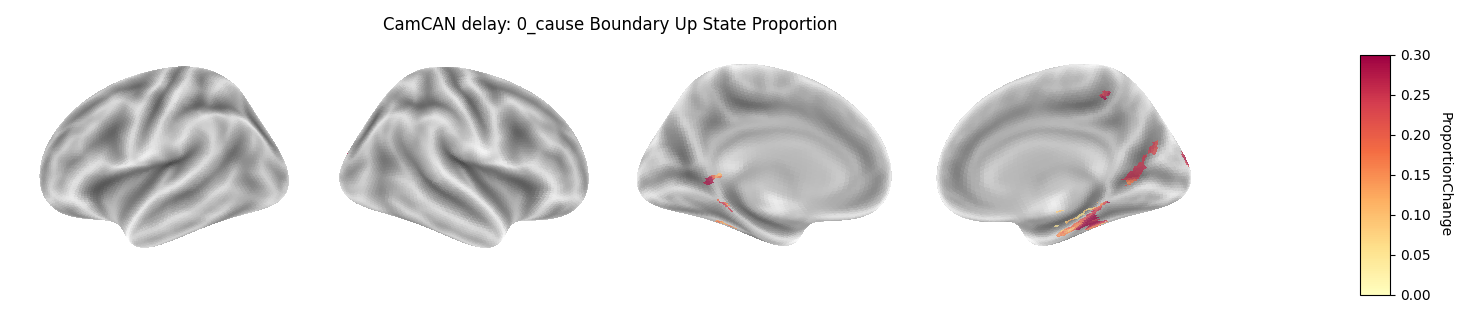

New NIfTI image saved


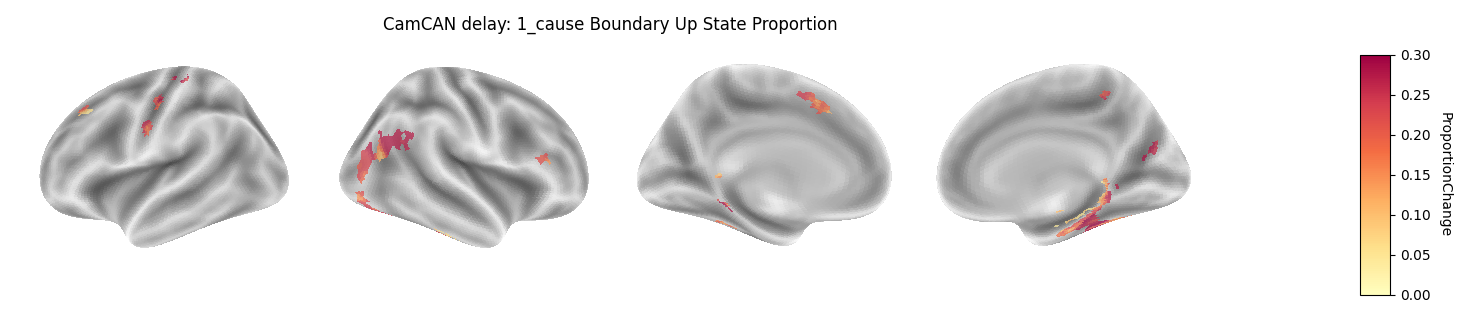

New NIfTI image saved


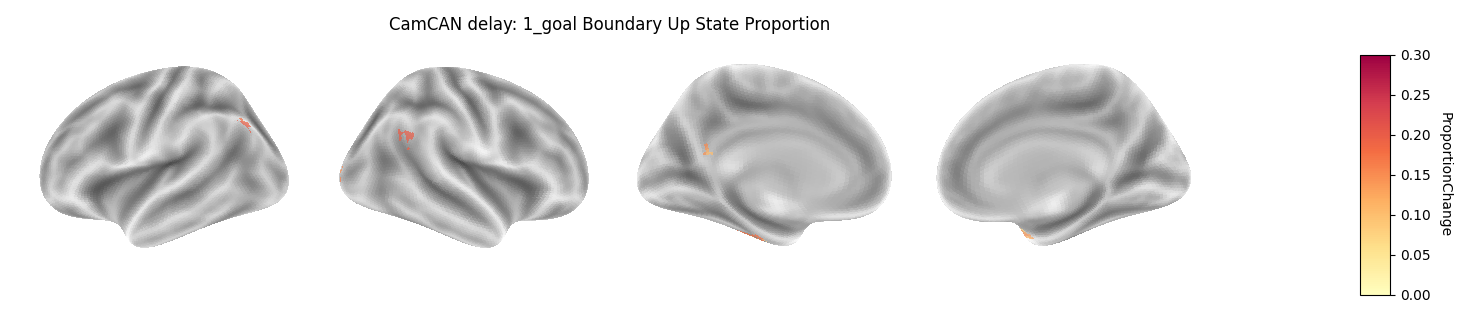

In [ ]:
import matplotlib.colors as colors
half_spectral_r_cmap = colors.LinearSegmentedColormap.from_list(
    'truncated_Spectral_r',
    plt.cm.Spectral_r(np.linspace(0.5, 1.0, 256))
)

for stimuli_name, all_delays_map_arrays in zip(stimuli_names,all_stimuli_all_delays_map_arrays):

  for delays_map_array,delay in zip(all_delays_map_arrays,delays):
    if np.nansum(delays_map_array) != 0:
      up_state_proportion_nii = roi_pattern_to_nifti(delays_map_array,saving=save_figures,output_path='/content/drive/My Drive/Flipping/niftis/'+str(now).replace(' ','_').replace(':','_').split('.')[0]+"_"+Dataset+'_delay:'+str(delay)+'_'+stimuli_name +'_Boundary_Up_State_Proportions')
      texture_left, texture_right = nifti_to_surface(up_state_proportion_nii)
      long_plot(texture_left,texture_right,title=Dataset+' delay: '+str(delay)+'_'+stimuli_name +' Boundary Up State Proportion',colorbarlabel='ProportionChange',saving=save_figures,min_val=0,max_val=0.3,views=['lateral', 'medial'],cmap=half_spectral_r_cmap,norm=None,show=True)


In [ ]:
for stimuli_name, all_delays_map_arrays in zip(stimuli_names,all_stimuli_all_delays_map_arrays):
  for delays_map_array,delay in zip(all_delays_map_arrays,delays):
    if np.nansum(delays_map_array) != 0:
      highest_areas = np.where(np.array(delays_map_array)>0)[0]
      print(stimuli_name, delay)
      print(np.unique(schaefer_labels[highest_areas]))

event 1
['7Networks_RH_Cont_PFCl_9']
spacesm -2
['7Networks_LH_Default_PFC_18']
spacesm -1
['7Networks_LH_Cont_Par_1' '7Networks_LH_Default_Par_3'
 '7Networks_LH_DorsAttn_FEF_2' '7Networks_LH_DorsAttn_Post_10'
 '7Networks_LH_DorsAttn_Post_3' '7Networks_LH_DorsAttn_Post_6'
 '7Networks_LH_SalVentAttn_FrOperIns_5' '7Networks_LH_SalVentAttn_Med_7'
 '7Networks_LH_Vis_14' '7Networks_LH_Vis_23' '7Networks_LH_Vis_30'
 '7Networks_RH_Cont_PFCl_13' '7Networks_RH_Default_PFCdPFCm_2'
 '7Networks_RH_DorsAttn_FEF_1' '7Networks_RH_DorsAttn_Post_18'
 '7Networks_RH_SalVentAttn_TempOccPar_6' '7Networks_RH_SomMot_27'
 '7Networks_RH_SomMot_36' '7Networks_RH_Vis_22' '7Networks_RH_Vis_27'
 '7Networks_RH_Vis_28' '7Networks_RH_Vis_3' '7Networks_RH_Vis_30']
spacesm 0
['7Networks_LH_Cont_PFCl_7' '7Networks_LH_Cont_PFCl_8'
 '7Networks_LH_Cont_Par_1' '7Networks_LH_Default_PFC_18'
 '7Networks_LH_Default_Par_3' '7Networks_LH_DorsAttn_FEF_2'
 '7Networks_LH_DorsAttn_FEF_3' '7Networks_LH_DorsAttn_FEF_4'
 '7Networks_LH_

## Across Scales

### Local and Global Template Correlations

In [ ]:
data = roi_averaged_data

dips, dip_pvals = run_diptest(data)

bimodal_timepoint_indices = np.where(dip_pvals < 0.05)[0]
unimodal_timepoint_indices = np.where(dip_pvals > 0.05)[0]

bimodal_data = data[:, bimodal_timepoint_indices]
unimodal_data = data[:, unimodal_timepoint_indices]

global_template_mean, global_template = template_creation(bimodal_data)
global_template_timeseries, global_template_timeseries_projection = template_projection(global_template_mean, global_template, data)


In [ ]:
# Local Templates

sl_template_patterns = []
sl_template_timsereries = []
sl_template_mean_correlations = []

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  cleaned_data = concat_sl_data[np.sum(concat_sl_data,axis=1)!=0]
  try:
    template_mean, template = template_creation(cleaned_data,with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, cleaned_data)
  except:
    print('exception, clean_data shape --> ',cleaned_data.shape)
    # template = np.random.randn(cleaned_data.shape[0])*0.1
    # template_timeseries_projection = np.random.randn(cleaned_data.shape[1])*0.1
    template_mean, template = template_creation(cleaned_data,with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, cleaned_data)
  sl_template_patterns.append(template)
  sl_template_timsereries.append(template_timeseries_projection)
  sl_template_mean_correlations.append(np.corrcoef(np.mean(cleaned_data,axis=0),template_timeseries_projection)[0][1])

  2%|▏         | 6/400 [00:00<00:07, 51.23it/s]

exception, clean_data shape -->  (82, 192)
exception, clean_data shape -->  (111, 192)
exception, clean_data shape -->  (86, 192)
exception, clean_data shape -->  (105, 192)
exception, clean_data shape -->  (130, 192)
exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (112, 192)
exception, clean_data shape -->  (83, 192)
exception, clean_data shape -->  (79, 192)
exception, clean_data shape -->  (74, 192)


  4%|▍         | 18/400 [00:00<00:07, 51.47it/s]

exception, clean_data shape -->  (41, 192)
exception, clean_data shape -->  (29, 192)
exception, clean_data shape -->  (60, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (47, 192)
exception, clean_data shape -->  (104, 192)
exception, clean_data shape -->  (116, 192)
exception, clean_data shape -->  (124, 192)
exception, clean_data shape -->  (33, 192)
exception, clean_data shape -->  (133, 192)
exception, clean_data shape -->  (66, 192)


  8%|▊         | 30/400 [00:00<00:07, 50.84it/s]

exception, clean_data shape -->  (119, 192)
exception, clean_data shape -->  (113, 192)
exception, clean_data shape -->  (116, 192)
exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (98, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (53, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (104, 192)


 10%|█         | 42/400 [00:00<00:07, 48.74it/s]

exception, clean_data shape -->  (27, 192)
exception, clean_data shape -->  (80, 192)
exception, clean_data shape -->  (47, 192)
exception, clean_data shape -->  (70, 192)
exception, clean_data shape -->  (22, 192)
exception, clean_data shape -->  (70, 192)
exception, clean_data shape -->  (52, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (53, 192)
exception, clean_data shape -->  (64, 192)
exception, clean_data shape -->  (35, 192)


 14%|█▎        | 54/400 [00:01<00:06, 50.57it/s]

exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (45, 192)
exception, clean_data shape -->  (76, 192)
exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (88, 192)
exception, clean_data shape -->  (50, 192)
exception, clean_data shape -->  (33, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (31, 192)
exception, clean_data shape -->  (40, 192)
exception, clean_data shape -->  (53, 192)


 16%|█▋        | 66/400 [00:01<00:06, 51.26it/s]

exception, clean_data shape -->  (77, 192)
exception, clean_data shape -->  (127, 192)
exception, clean_data shape -->  (82, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (103, 192)
exception, clean_data shape -->  (35, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (94, 192)
exception, clean_data shape -->  (52, 192)
exception, clean_data shape -->  (70, 192)


 18%|█▊        | 72/400 [00:01<00:06, 51.22it/s]

exception, clean_data shape -->  (62, 192)
exception, clean_data shape -->  (27, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (142, 192)
exception, clean_data shape -->  (127, 192)
exception, clean_data shape -->  (83, 192)
exception, clean_data shape -->  (33, 192)
exception, clean_data shape -->  (55, 192)
exception, clean_data shape -->  (68, 192)
exception, clean_data shape -->  (57, 192)
exception, clean_data shape -->  (70, 192)


 21%|██        | 84/400 [00:01<00:06, 52.29it/s]

exception, clean_data shape -->  (48, 192)
exception, clean_data shape -->  (68, 192)
exception, clean_data shape -->  (47, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (36, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (30, 192)
exception, clean_data shape -->  (85, 192)
exception, clean_data shape -->  (95, 192)


 24%|██▍       | 95/400 [00:01<00:06, 48.66it/s]

exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (120, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (60, 192)
exception, clean_data shape -->  (96, 192)
exception, clean_data shape -->  (83, 192)
exception, clean_data shape -->  (86, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (84, 192)
exception, clean_data shape -->  (72, 192)


 26%|██▋       | 106/400 [00:02<00:05, 49.49it/s]

exception, clean_data shape -->  (133, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (55, 192)
exception, clean_data shape -->  (74, 192)
exception, clean_data shape -->  (34, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (79, 192)
exception, clean_data shape -->  (89, 192)
exception, clean_data shape -->  (158, 192)
exception, clean_data shape -->  (115, 192)
exception, clean_data shape -->  (112, 192)


 28%|██▊       | 111/400 [00:02<00:05, 49.58it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2920: RuntimeWarning: invalid value encountered in divide
  return c / c
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 29%|██▉       | 117/400 [00:02<00:05, 50.40it/s]

exception, clean_data shape -->  (64, 192)
exception, clean_data shape -->  (99, 192)
exception, clean_data shape -->  (49, 192)
exception, clean_data shape -->  (73, 192)
exception, clean_data shape -->  (45, 192)
exception, clean_data shape -->  (19, 192)
exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (33, 192)
exception, clean_data shape -->  (29, 192)
exception, clean_data shape -->  (0, 192)


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-7-2458926046>:56: RuntimeWarning: invalid value encountered in divide
  template_timeseries_projection = template_timeseries_projection / (np.linalg.norm(template, ord=2)**2)
 32%|███▏      | 129/400 [00:02<00:05, 52.41it/s]

exception, clean_data shape -->  (10, 192)
exception, clean_data shape -->  (4, 192)
exception, clean_data shape -->  (0, 192)
exception, clean_data shape -->  (19, 192)
exception, clean_data shape -->  (129, 192)
exception, clean_data shape -->  (77, 192)
exception, clean_data shape -->  (20, 192)
exception, clean_data shape -->  (60, 192)
exception, clean_data shape -->  (32, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (81, 192)


 34%|███▍      | 135/400 [00:02<00:05, 51.87it/s]

exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (90, 192)
exception, clean_data shape -->  (79, 192)
exception, clean_data shape -->  (24, 192)
exception, clean_data shape -->  (88, 192)
exception, clean_data shape -->  (99, 192)
exception, clean_data shape -->  (134, 192)
exception, clean_data shape -->  (100, 192)
exception, clean_data shape -->  (142, 192)
exception, clean_data shape -->  (203, 192)


 37%|███▋      | 147/400 [00:02<00:05, 48.89it/s]

exception, clean_data shape -->  (53, 192)
exception, clean_data shape -->  (100, 192)
exception, clean_data shape -->  (50, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (73, 192)
exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (32, 192)
exception, clean_data shape -->  (130, 192)
exception, clean_data shape -->  (74, 192)
exception, clean_data shape -->  (56, 192)
exception, clean_data shape -->  (38, 192)


 40%|███▉      | 159/400 [00:03<00:04, 50.43it/s]

exception, clean_data shape -->  (143, 192)
exception, clean_data shape -->  (105, 192)
exception, clean_data shape -->  (132, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (62, 192)
exception, clean_data shape -->  (81, 192)
exception, clean_data shape -->  (60, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (76, 192)
exception, clean_data shape -->  (80, 192)
exception, clean_data shape -->  (128, 192)


 43%|████▎     | 171/400 [00:03<00:04, 51.20it/s]

exception, clean_data shape -->  (77, 192)
exception, clean_data shape -->  (72, 192)
exception, clean_data shape -->  (51, 192)
exception, clean_data shape -->  (90, 192)
exception, clean_data shape -->  (48, 192)
exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (124, 192)
exception, clean_data shape -->  (53, 192)
exception, clean_data shape -->  (70, 192)
exception, clean_data shape -->  (98, 192)
exception, clean_data shape -->  (63, 192)


 44%|████▍     | 177/400 [00:03<00:04, 51.11it/s]

exception, clean_data shape -->  (150, 192)
exception, clean_data shape -->  (126, 192)
exception, clean_data shape -->  (45, 192)
exception, clean_data shape -->  (126, 192)
exception, clean_data shape -->  (190, 192)
exception, clean_data shape -->  (96, 192)
exception, clean_data shape -->  (108, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (134, 192)
exception, clean_data shape -->  (48, 192)


 47%|████▋     | 188/400 [00:03<00:05, 36.17it/s]

exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (114, 192)
exception, clean_data shape -->  (74, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (90, 192)


 48%|████▊     | 193/400 [00:04<00:06, 32.85it/s]

exception, clean_data shape -->  (110, 192)
exception, clean_data shape -->  (37, 192)
exception, clean_data shape -->  (82, 192)
exception, clean_data shape -->  (58, 192)
exception, clean_data shape -->  (22, 192)
exception, clean_data shape -->  (64, 192)


 50%|█████     | 201/400 [00:04<00:06, 32.83it/s]

exception, clean_data shape -->  (108, 192)
exception, clean_data shape -->  (67, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (64, 192)
exception, clean_data shape -->  (40, 192)
exception, clean_data shape -->  (109, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (82, 192)


 51%|█████▏    | 205/400 [00:04<00:06, 29.47it/s]

exception, clean_data shape -->  (99, 192)
exception, clean_data shape -->  (104, 192)
exception, clean_data shape -->  (121, 192)
exception, clean_data shape -->  (144, 192)
exception, clean_data shape -->  (34, 192)


 52%|█████▏    | 209/400 [00:04<00:06, 28.81it/s]

exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (110, 192)
exception, clean_data shape -->  (22, 192)
exception, clean_data shape -->  (83, 192)


 54%|█████▍    | 216/400 [00:05<00:07, 24.62it/s]

exception, clean_data shape -->  (99, 192)
exception, clean_data shape -->  (21, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (156, 192)
exception, clean_data shape -->  (158, 192)
exception, clean_data shape -->  (32, 192)


 56%|█████▌    | 222/400 [00:05<00:07, 23.93it/s]

exception, clean_data shape -->  (82, 192)
exception, clean_data shape -->  (182, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (118, 192)


 57%|█████▋    | 229/400 [00:05<00:06, 27.93it/s]

exception, clean_data shape -->  (95, 192)
exception, clean_data shape -->  (85, 192)
exception, clean_data shape -->  (76, 192)
exception, clean_data shape -->  (113, 192)
exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (92, 192)
exception, clean_data shape -->  (61, 192)


 58%|█████▊    | 232/400 [00:05<00:07, 21.60it/s]

exception, clean_data shape -->  (82, 192)
exception, clean_data shape -->  (120, 192)


 59%|█████▉    | 235/400 [00:05<00:08, 19.45it/s]

exception, clean_data shape -->  (117, 192)
exception, clean_data shape -->  (41, 192)
exception, clean_data shape -->  (34, 192)
exception, clean_data shape -->  (33, 192)


 60%|██████    | 241/400 [00:06<00:08, 19.44it/s]

exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (34, 192)
exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (37, 192)


 61%|██████    | 244/400 [00:06<00:09, 16.97it/s]

exception, clean_data shape -->  (49, 192)
exception, clean_data shape -->  (40, 192)
exception, clean_data shape -->  (41, 192)


 62%|██████▏   | 246/400 [00:06<00:09, 16.98it/s]

exception, clean_data shape -->  (14, 192)
exception, clean_data shape -->  (111, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (63, 192)


 63%|██████▎   | 252/400 [00:06<00:07, 21.00it/s]

exception, clean_data shape -->  (43, 192)
exception, clean_data shape -->  (32, 192)
exception, clean_data shape -->  (29, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (63, 192)
exception, clean_data shape -->  (99, 192)


 64%|██████▍   | 255/400 [00:06<00:06, 21.46it/s]

exception, clean_data shape -->  (47, 192)
exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (39, 192)


 65%|██████▌   | 260/400 [00:07<00:07, 18.08it/s]

exception, clean_data shape -->  (56, 192)
exception, clean_data shape -->  (43, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (75, 192)


 67%|██████▋   | 267/400 [00:07<00:06, 20.74it/s]

exception, clean_data shape -->  (40, 192)
exception, clean_data shape -->  (31, 192)
exception, clean_data shape -->  (37, 192)
exception, clean_data shape -->  (53, 192)
exception, clean_data shape -->  (47, 192)


 68%|██████▊   | 270/400 [00:07<00:06, 21.42it/s]

exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (28, 192)
exception, clean_data shape -->  (136, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (87, 192)
exception, clean_data shape -->  (71, 192)


 69%|██████▉   | 277/400 [00:07<00:04, 24.84it/s]

exception, clean_data shape -->  (71, 192)
exception, clean_data shape -->  (32, 192)
exception, clean_data shape -->  (22, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (61, 192)


 71%|███████   | 284/400 [00:08<00:04, 26.35it/s]

exception, clean_data shape -->  (51, 192)
exception, clean_data shape -->  (89, 192)
exception, clean_data shape -->  (85, 192)
exception, clean_data shape -->  (55, 192)
exception, clean_data shape -->  (96, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (86, 192)


 73%|███████▎  | 291/400 [00:08<00:04, 27.08it/s]

exception, clean_data shape -->  (151, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (67, 192)
exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (91, 192)
exception, clean_data shape -->  (37, 192)


 74%|███████▍  | 298/400 [00:08<00:03, 26.38it/s]

exception, clean_data shape -->  (115, 192)
exception, clean_data shape -->  (67, 192)
exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (52, 192)
exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (79, 192)


 76%|███████▋  | 305/400 [00:09<00:03, 27.60it/s]

exception, clean_data shape -->  (50, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (77, 192)
exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (65, 192)
exception, clean_data shape -->  (83, 192)
exception, clean_data shape -->  (51, 192)


 79%|███████▉  | 315/400 [00:09<00:02, 35.81it/s]

exception, clean_data shape -->  (127, 192)
exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (81, 192)
exception, clean_data shape -->  (66, 192)
exception, clean_data shape -->  (155, 192)
exception, clean_data shape -->  (129, 192)
exception, clean_data shape -->  (99, 192)
exception, clean_data shape -->  (60, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (43, 192)
exception, clean_data shape -->  (45, 192)


 82%|████████▏ | 326/400 [00:09<00:01, 42.31it/s]

exception, clean_data shape -->  (84, 192)
exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (24, 192)
exception, clean_data shape -->  (52, 192)
exception, clean_data shape -->  (17, 192)
exception, clean_data shape -->  (14, 192)
exception, clean_data shape -->  (21, 192)
exception, clean_data shape -->  (20, 192)
exception, clean_data shape -->  (12, 192)
exception, clean_data shape -->  (4, 192)
exception, clean_data shape -->  (37, 192)


 84%|████████▍ | 338/400 [00:09<00:01, 47.78it/s]

exception, clean_data shape -->  (25, 192)
exception, clean_data shape -->  (76, 192)
exception, clean_data shape -->  (9, 192)
exception, clean_data shape -->  (31, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (28, 192)
exception, clean_data shape -->  (44, 192)
exception, clean_data shape -->  (79, 192)
exception, clean_data shape -->  (50, 192)


 87%|████████▋ | 349/400 [00:09<00:01, 49.09it/s]

exception, clean_data shape -->  (64, 192)
exception, clean_data shape -->  (59, 192)
exception, clean_data shape -->  (9, 192)
exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (168, 192)
exception, clean_data shape -->  (56, 192)
exception, clean_data shape -->  (143, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (77, 192)
exception, clean_data shape -->  (95, 192)
exception, clean_data shape -->  (78, 192)


 89%|████████▉ | 355/400 [00:10<00:00, 49.66it/s]

exception, clean_data shape -->  (100, 192)
exception, clean_data shape -->  (84, 192)
exception, clean_data shape -->  (110, 192)
exception, clean_data shape -->  (55, 192)
exception, clean_data shape -->  (124, 192)
exception, clean_data shape -->  (112, 192)
exception, clean_data shape -->  (81, 192)
exception, clean_data shape -->  (55, 192)
exception, clean_data shape -->  (18, 192)
exception, clean_data shape -->  (17, 192)
exception, clean_data shape -->  (109, 192)


 92%|█████████▏| 367/400 [00:10<00:00, 50.40it/s]

exception, clean_data shape -->  (95, 192)
exception, clean_data shape -->  (43, 192)
exception, clean_data shape -->  (121, 192)
exception, clean_data shape -->  (120, 192)
exception, clean_data shape -->  (57, 192)
exception, clean_data shape -->  (79, 192)
exception, clean_data shape -->  (87, 192)
exception, clean_data shape -->  (81, 192)
exception, clean_data shape -->  (93, 192)
exception, clean_data shape -->  (165, 192)


 95%|█████████▍| 379/400 [00:10<00:00, 48.52it/s]

exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (42, 192)
exception, clean_data shape -->  (47, 192)
exception, clean_data shape -->  (80, 192)
exception, clean_data shape -->  (69, 192)
exception, clean_data shape -->  (54, 192)
exception, clean_data shape -->  (75, 192)
exception, clean_data shape -->  (111, 192)
exception, clean_data shape -->  (186, 192)
exception, clean_data shape -->  (46, 192)
exception, clean_data shape -->  (139, 192)


 98%|█████████▊| 391/400 [00:10<00:00, 50.15it/s]

exception, clean_data shape -->  (146, 192)
exception, clean_data shape -->  (61, 192)
exception, clean_data shape -->  (26, 192)
exception, clean_data shape -->  (73, 192)
exception, clean_data shape -->  (78, 192)
exception, clean_data shape -->  (83, 192)
exception, clean_data shape -->  (98, 192)
exception, clean_data shape -->  (92, 192)
exception, clean_data shape -->  (93, 192)
exception, clean_data shape -->  (108, 192)
exception, clean_data shape -->  (91, 192)


100%|██████████| 400/400 [00:10<00:00, 36.58it/s]

exception, clean_data shape -->  (7, 192)
exception, clean_data shape -->  (30, 192)
exception, clean_data shape -->  (67, 192)
exception, clean_data shape -->  (50, 192)
exception, clean_data shape -->  (93, 192)
exception, clean_data shape -->  (68, 192)
exception, clean_data shape -->  (40, 192)
exception, clean_data shape -->  (64, 192)


In [ ]:
global_local_correlations = []

for template_timeseries in sl_template_timsereries:
  global_local_correlations.append(np.corrcoef(template_timeseries,global_template_timeseries_projection)[0][1])

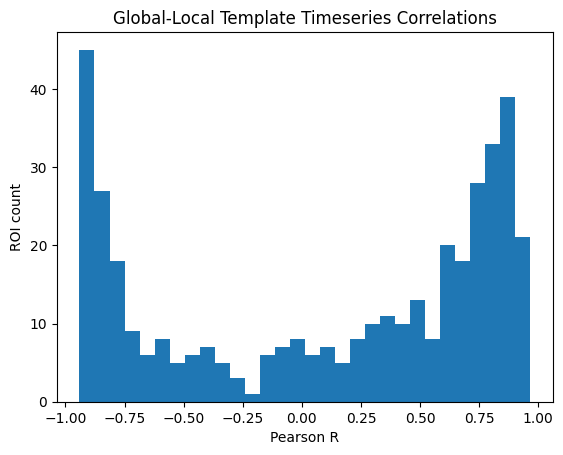

In [ ]:
plt.title('Global-Local Template Timeseries Correlations')
plt.xlabel('Pearson R')
plt.ylabel('ROI count')
_=plt.hist(global_local_correlations,bins=30)

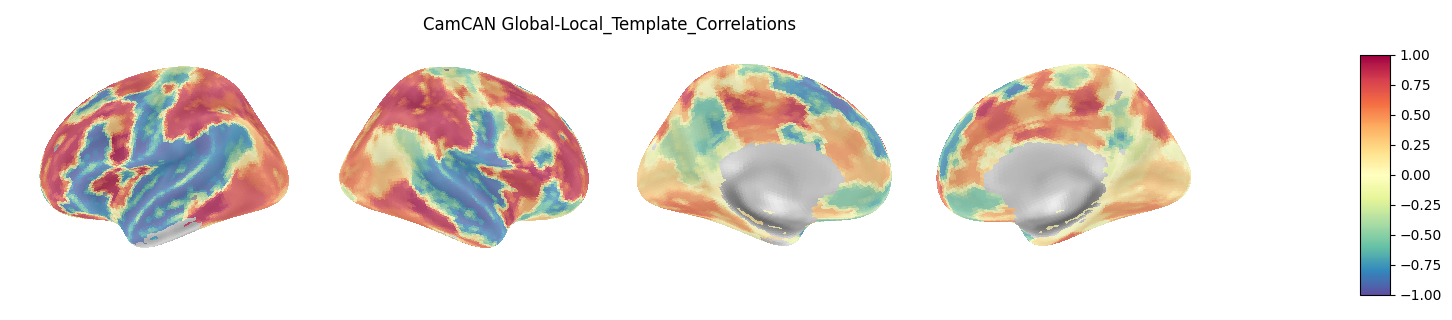

In [ ]:

data = global_local_correlations

univariate_proportion_nii = roi_pattern_to_nifti(data,saving=False,output_path='')
texture_left, texture_right = nifti_to_surface(univariate_proportion_nii)
long_plot(texture_left,texture_right,title=Dataset+' Global-Local_Template_Correlations',saving=save_figures,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)

### Global Local Boundary Overlap

In [ ]:
global_local_bound_relative_overlaps = []

global_change_indices = np.where(np.diff(np.sign(global_template_timeseries_projection))!=0)[0]

for sl_template in sl_template_timsereries:
  local_bounds = np.where(np.diff(np.sign(sl_template))!=0)[0]
  if local_bounds.shape[0] !=0:
    # OA, OR = compute_boundary_overlap_from_indices(local_bounds, global_change_indices, concat_all_whole_brain_data.shape[3])
    OA, OR = compute_boundary_overlap_from_indices(global_change_indices, local_bounds, concat_all_whole_brain_data.shape[3])
    global_local_bound_relative_overlaps.append(OA)
  else:
    global_local_bound_relative_overlaps.append(0)


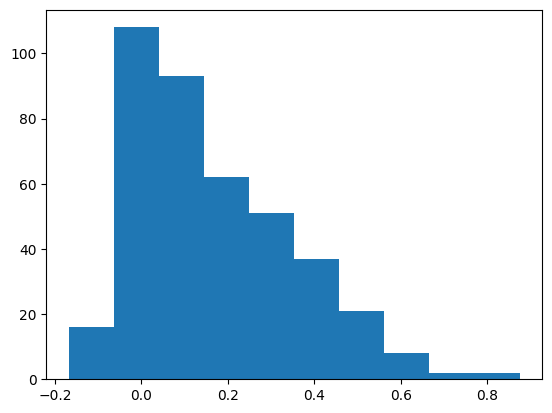

In [ ]:
_=plt.hist(global_local_bound_relative_overlaps)

New NIfTI image saved


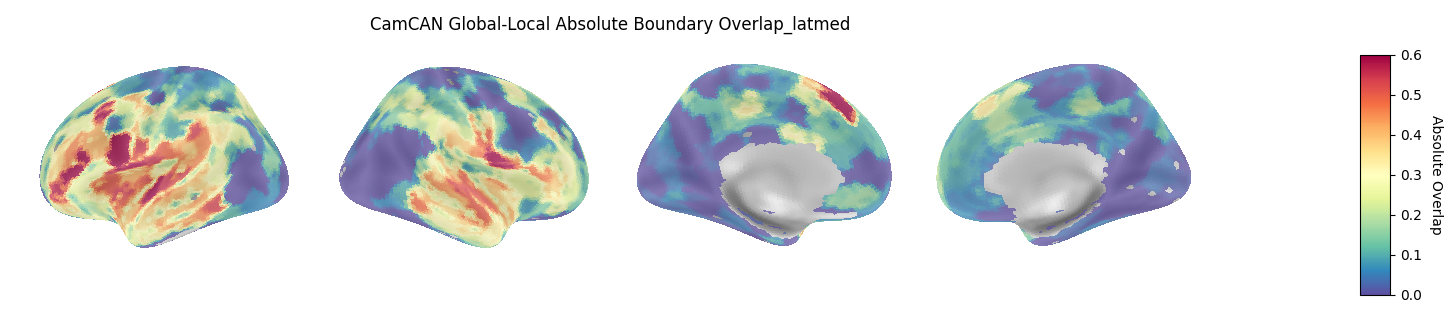

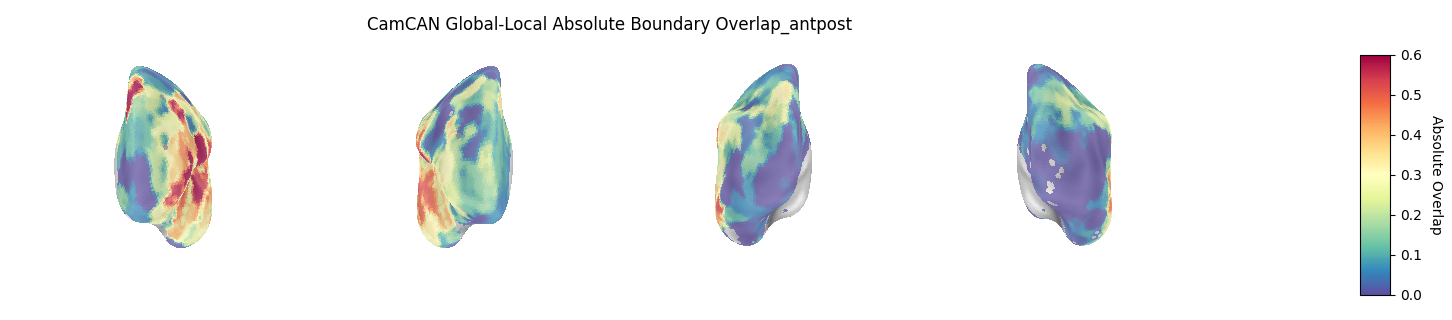

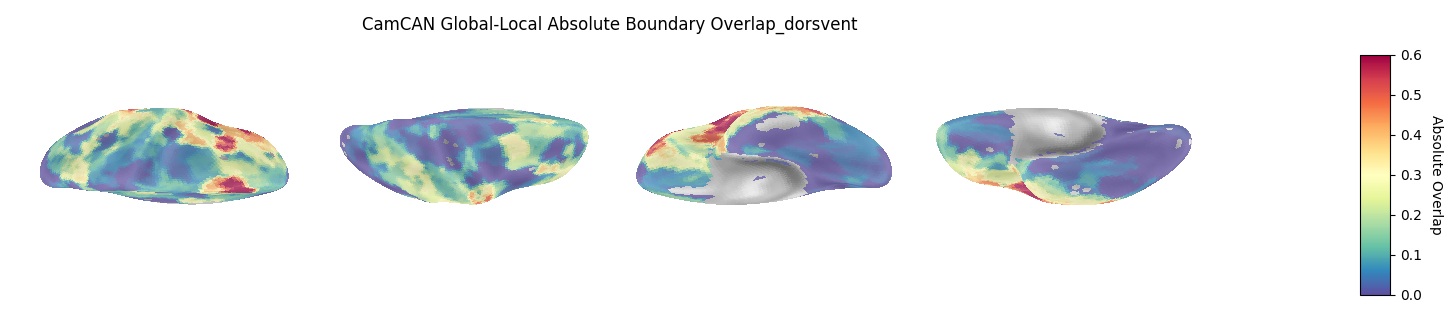

In [ ]:
data = global_local_bound_relative_overlaps

univariate_proportion_nii = roi_pattern_to_nifti(data,saving=True,output_path='/content/drive/My Drive/Flipping/niftis/'+Dataset+'_Global-Local_Absolute_Boundary_Overlap')
texture_left, texture_right = nifti_to_surface(univariate_proportion_nii)
long_plot(texture_left,texture_right,title=Dataset+' Global-Local Absolute Boundary Overlap_latmed',colorbarlabel='Absolute Overlap',saving=save_figures,min_val=0,max_val=.6,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)
long_plot(texture_left,texture_right,title=Dataset+' Global-Local Absolute Boundary Overlap_antpost',colorbarlabel='Absolute Overlap',saving=save_figures,min_val=0,max_val=.6,views=['anterior', 'posterior'],cmap='Spectral_r',norm=None,show=True)
long_plot(texture_left,texture_right,title=Dataset+' Global-Local Absolute Boundary Overlap_dorsvent',colorbarlabel='Absolute Overlap',saving=save_figures,min_val=0,max_val=.6,views=['dorsal', 'ventral'],cmap='Spectral_r',norm=None,show=True)


In [ ]:
OR_bigger_than = np.where(np.array(global_local_bound_relative_overlaps)>.4)[0]

schaefer_labels[OR_bigger_than]

array(['7Networks_LH_SomMot_1', '7Networks_LH_SomMot_2',
       '7Networks_LH_SomMot_4', '7Networks_LH_SomMot_6',
       '7Networks_LH_SomMot_7', '7Networks_LH_SomMot_8',
       '7Networks_LH_SomMot_9', '7Networks_LH_SomMot_10',
       '7Networks_LH_SomMot_11', '7Networks_LH_SomMot_12',
       '7Networks_LH_SomMot_16', '7Networks_LH_DorsAttn_FEF_1',
       '7Networks_LH_DorsAttn_PrCv_1',
       '7Networks_LH_SalVentAttn_ParOper_2',
       '7Networks_LH_SalVentAttn_ParOper_4',
       '7Networks_LH_SalVentAttn_FrOperIns_2',
       '7Networks_LH_SalVentAttn_FrOperIns_4',
       '7Networks_LH_SalVentAttn_FrOperIns_5',
       '7Networks_LH_SalVentAttn_FrOperIns_6',
       '7Networks_LH_SalVentAttn_FrOperIns_7',
       '7Networks_LH_SalVentAttn_FrOperIns_8',
       '7Networks_LH_SalVentAttn_FrOperIns_9',
       '7Networks_LH_Limbic_TempPole_7', '7Networks_LH_Cont_Par_5',
       '7Networks_LH_Cont_Temp_1', '7Networks_LH_Cont_PFCl_1',
       '7Networks_LH_Cont_PFCl_2', '7Networks_LH_Cont_PFCl_

In [ ]:
network_labels = np.array([ROI_label.split('_')[2] for ROI_label in schaefer_labels]).astype(str)
unique_network_labels = np.unique(network_labels)
network_indices = [[i for i, item in enumerate(network_labels) if item == network_label] for network_label in unique_network_labels]

In [ ]:
network_template_loadings = [np.mean(zscore(global_local_bound_relative_overlaps)[network_index]) for network_index in network_indices]

In [ ]:
atlas_data = atlas_resampled.get_fdata()

network_template_correlations = []
for count, network_ROIs  in enumerate(network_indices):
  empty_volume = np.zeros_like(concat_all_whole_brain_data[:,:,:,0])
  for ROI_idx in network_ROIs:
    empty_volume[atlas_data == ROI_idx] = 1
  network_template_correlations.append(np.corrcoef(univariate_proportion_nii.get_fdata().flatten(),empty_volume.flatten())[0][1])

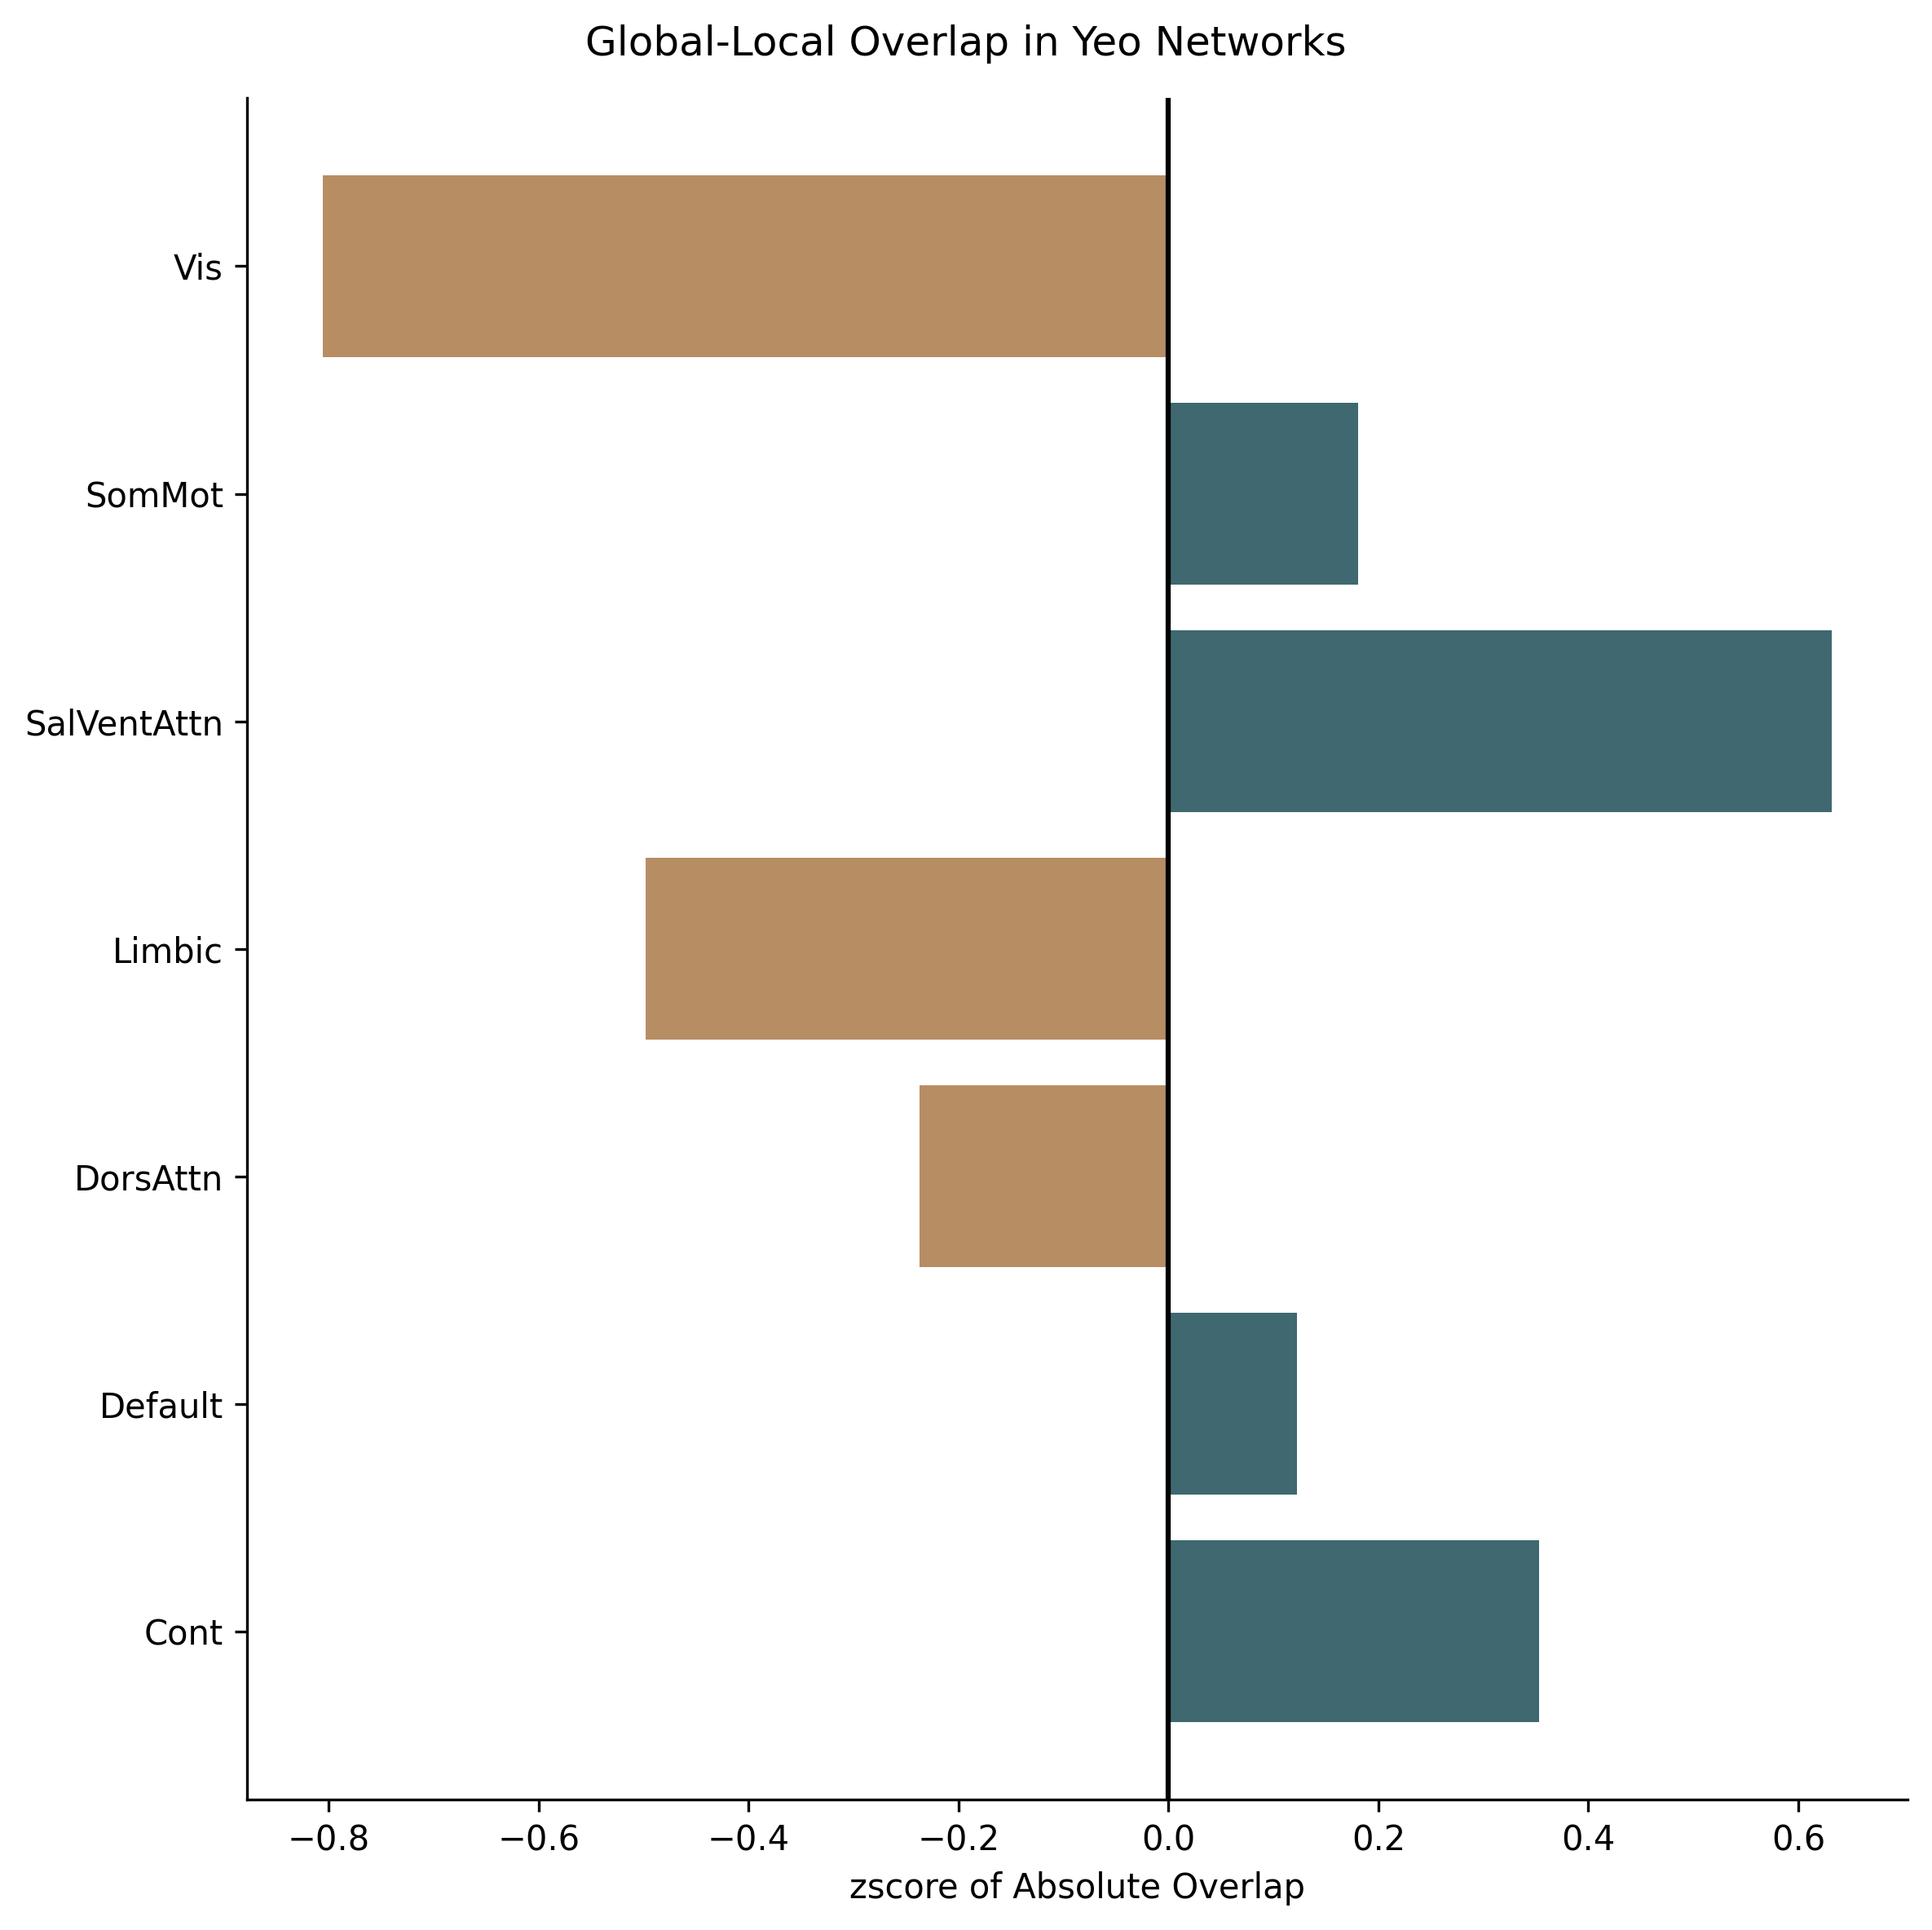

In [ ]:
fig, axs = plt.subplots(1,figsize=(8,8),dpi=300)
fig.suptitle('Global-Local Overlap in Yeo Networks')

global_local_AO_loadings = [np.mean(zscore(global_local_bound_relative_overlaps)[network_index]) for network_index in network_indices]
colors = [cscale[0] if val <= 0 else cscale[2] for val in global_local_AO_loadings]
axs.barh(unique_network_labels,global_local_AO_loadings,color=colors)
axs.set_xlabel('zscore of Absolute Overlap')
axs.axvline(0,c='black')
axs.spines['top'].set_visible(False)  # Remove top border
axs.spines['right'].set_visible(False)  # Remove right border

fig.tight_layout()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'_Global_Local_Overlap_in_Yeo_Networks',transparent=True,format='png')


## Appendix


### Voxel-wise Global Template

To verify our results across scales, we also created a voxel-wise whole brain template. The difference between this template and the global is not averaging activity

In [ ]:
# @title
# Grab whole brain data
wholebrain_data = concat_all_whole_brain_data.reshape(-1, concat_all_whole_brain_data.shape[-1])
total_voxels = wholebrain_data.shape[0]
# Get rid of all zero or nan data
wholebrain_voxel_indices = np.intersect1d(np.where(np.sum(np.isnan(wholebrain_data), axis=1) == 0)[0], np.where(np.sum(wholebrain_data, axis=1) != 0)[0])

wholebrain_data = wholebrain_data[wholebrain_voxel_indices, :]
print(f'Number of (non-zero non-nan) voxels is {len(wholebrain_data)} / {total_voxels}')

In [ ]:
# @title
TbyT_corr = np.corrcoef(wholebrain_data.T)
meta_TbyT_corr = np.corrcoef(TbyT_corr)

In [ ]:
# @title
data = wholebrain_data

dips, dip_pvals = run_diptest(data)

bimodal_timepoint_indices = np.where(dip_pvals < 0.05)[0]
unimodal_timepoint_indices = np.where(dip_pvals > 0.05)[0]

bimodal_data = data[:, bimodal_timepoint_indices]
unimodal_data = data[:, unimodal_timepoint_indices]

template_mean, template = template_creation(bimodal_data)
template_timeseries, template_timeseries_projection = template_projection(template_mean, template, data)
temp_correlation_signs = np.sign(template_timeseries_projection)

indices_A = np.intersect1d(np.where(temp_correlation_signs>0)[0],bimodal_timepoint_indices)
indices_B = np.intersect1d(np.where(temp_correlation_signs<0)[0],bimodal_timepoint_indices)
indices_C = unimodal_timepoint_indices

sizes = [indices_A.shape[0], indices_B.shape[0] , indices_C.shape[0]]

# assign labels to the events
events = [(idx, 'Task Positive\nState') for idx in indices_A] + \
         [(idx, 'Default Mode\nState') for idx in indices_B] + \
         [(idx, 'Unimodal\nState') for idx in indices_C]
# sort events by index
events.sort()

# extract event labels in order
event_sequence = [e[1] for e in events]

event_types = ['Task Positive\nState', 'Default Mode\nState', 'Unimodal\nState']

In [ ]:
# @title
# compute transitions
event_to_index = {event: i for i, event in enumerate(event_types)}
num_events = len(event_types)

transition_counts = np.zeros((num_events, num_events), dtype=int)

# transition counts
for i in range(len(event_sequence) - 1):
    from_idx = event_to_index[event_sequence[i]]
    to_idx = event_to_index[event_sequence[i + 1]]
    transition_counts[from_idx, to_idx] += 1


transition_counts_np = np.zeros((num_events, num_events), dtype=int)

# transition counts
for i in range(len(event_sequence) - 1):
    from_idx = event_to_index[event_sequence[i]]
    to_idx = event_to_index[event_sequence[i + 1]]
    transition_counts_np[from_idx, to_idx] += 1

# normalize
row_sums = transition_counts_np.sum(axis=1, keepdims=True)
transition_matrix_np = np.divide(transition_counts_np, row_sums, where=row_sums != 0)


# compute durations of successive same-state instances
durations = {event: [] for event in event_types}

# count consecutive occurrences
current_event = event_sequence[0]
start_idx = [idx for idx, e in events if e == current_event][0]  # Start index of first event

for i in range(1, len(events)):
    index, event = events[i]  # Extract correct index and event type

    if event == current_event:
        continue  # Continue counting the same event
    else:
        # Store duration of the previous event
        duration = index - start_idx
        durations[current_event].append(duration)

        # Update tracking variables
        current_event = event
        start_idx = index

# average durations
average_durations = {event: np.mean(durations[event]) if durations[event] else 0 for event in event_types}


durations_list = []
event_labels = []

for event, duration_list in durations.items():
    durations_list.extend(duration_list)
    event_labels.extend([event] * len(duration_list))


# plot_summary(num_events,event_types,event_labels,transition_matrix_np,sizes,durations_list)

In [ ]:
# @title
global_mean_at_states = []
for indices in [indices_A,indices_B,indices_C]:
  global_mean_at_states.append(np.mean(roi_averaged_data,axis=0)[indices])

In [ ]:
# @title
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

start=0
until=100
time_tick_fraction = 20
# Create figure with GridSpec
fig = plt.figure(figsize=(20, 20),dpi=300)
gs = gridspec.GridSpec(3, 3,width_ratios=[2,1,1],height_ratios=[1,1,1])

# Define the axes using GridSpec
axes = []
axes.append(fig.add_subplot(gs[0, 0]))                # Row 0, Col 0
axes.append(fig.add_subplot(gs[0, 1]))               # Row 0, Col 1
axes.append(fig.add_subplot(gs[0, 2]))               # Row 0, Col 2
axes.append(fig.add_subplot(gs[1, 0]))                # Row 1, Col 0
axes.append(fig.add_subplot(gs[1, 1]))                # Row 1, Col 1
axes.append(fig.add_subplot(gs[1, 2]))                # Row 1, Col 2
axes.append(fig.add_subplot(gs[2, :]))                # Row 2, Col 0
# axes.append(fig.add_subplot(gs[2, 2]))                # Row 2, Col 2

########################## TIMESERIES #######################
axes[0].imshow(wholebrain_data[:,start:until],aspect='auto',interpolation='none',cmap='Spectral_r')
# axes[0].set_title("ROI_Averaged Timeseries")
axes[0].set_xlabel('Time (minutes)',fontsize=26)
axes[0].set_ylabel('Voxels',fontsize=26)
duration = until - start
axes[0].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[0].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[0].get_xticks()[::time_tick_fraction]
axes[0].set_xticks(ticks)
axes[0].set_yticks([])
########################## TbyT CORR MTX #####################
axes[1].imshow(np.corrcoef(wholebrain_data[:,start:until].T),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
# axes[1].set_title("Time by time Correlation")
axes[1].set_xlabel('Time (minutes)',fontsize=26)
axes[1].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[1].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[1].get_xticks()[::time_tick_fraction]
axes[1].set_xticks(ticks)

axes[1].set_ylabel('Time (minutes)',fontsize=26)
axes[1].set_yticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[1].set_yticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[1].get_yticks()[::time_tick_fraction]
axes[1].set_yticks(ticks)
########################## META CORR MTX ################
axes[2].imshow(np.corrcoef(np.corrcoef(wholebrain_data[:,start:until].T)),aspect='equal',interpolation='none',cmap='Spectral_r',vmin=-1,vmax=1)
# axes[2].set_title("meta \n Time by time Correlation")
axes[2].set_xlabel('Time (minutes)',fontsize=26)
axes[2].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[2].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[2].get_xticks()[::time_tick_fraction]
axes[2].set_xticks(ticks)

axes[2].set_ylabel('Time (minutes)',fontsize=26)
axes[2].set_yticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[2].set_yticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=20,rotation=0)
ticks = axes[2].get_yticks()[::time_tick_fraction]
axes[2].set_yticks(ticks)

########################## HISTOGRAMS ########################
ax = axes[3]
N, bins, hist_patches = ax.hist(meta_TbyT_corr[np.where(dip_pvals < 0.05)[0], :].flatten(), bins = np.arange(-1,1.1,0.1), alpha=1.0, color=cscale[2])

ax2 = ax.twinx()
N, bins, hist_patches = ax2.hist(meta_TbyT_corr[np.where(dip_pvals > 0.05)[0], :].flatten(), bins = np.arange(-1,1.1,0.1), alpha=0.75, color=cscale[1])

ax.spines[['left', 'right', 'top']].set_visible(False)
ax2.spines[['left', 'right', 'top']].set_visible(False)

ax.set_xlabel('Meta Temporal Correlation Values',fontsize=26)
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xticks([-1, 0, 1])
ax2.set_xticks([-1, 0, 1])

ax.set_xticklabels([-1, 0, 1],fontsize=20)
ax2.set_xticklabels([-1, 0, 1],fontsize=20)
########################## PIE ###########################
text_properties = {'color': 'white', 'fontsize': 20, 'fontweight': "regular"}

# Custom function to format labels inside the pie
def autopct_with_labels(pct, all_vals):
    total = sum(all_vals)
    absolute = int(round(pct * total / 100.0))  # Compute absolute count
    return f"{event_types[all_vals.index(absolute)]}\n{pct:.1f}%"


# Create a pie chart
wedges, texts, autotexts = axes[4].pie(
    sizes,
    colors=[cscale[2], cscale[0], cscale[1]],
    autopct=lambda pct: autopct_with_labels(pct, sizes),  # Labels + percentages inside
    textprops=text_properties,  # Customize text properties
    radius=1.4,
    pctdistance=.55
)

########################## TRANSITION MATRIX #######################
cax = axes[5].matshow(transition_matrix_np, cmap="Grays")

# annotate
for i in range(num_events):
    for j in range(num_events):
        count = transition_counts_np[i, j]
        prob = transition_matrix_np[i, j]
        if prob < 0.5:
          c = "black"
        else:
          c = "white"
        axes[5].text(j, i, f"{count}\n({prob:.2f})", ha='center', va='center', color=c,fontsize=18)#,rotation=60)

axes[5].set_xticks(range(num_events))
axes[5].set_yticks(range(num_events))
axes[5].set_xticklabels([])
axes[5].set_yticklabels(event_types,fontsize=16)#,rotation=-45)
axes[5].yaxis.tick_right()

axes[5].set_xlabel("To State",fontsize=20)
axes[5].set_ylabel("From State",fontsize=20)

########################## TIMESERIES WITH STATES ######################
axes[6].imshow(wholebrain_data[:,start:until],
                         extent=[start, until, 0, roi_averaged_data.shape[0]],  # Match x-axis range
                         aspect='auto', alpha=0.95,
                         cmap='Spectral_r', interpolation="None")#, vmin=imvmin, vmax=imvmax)
axes[6].tick_params(top=False, bottom=True, labelbottom=True, labeltop=False)
axes[6].spines[['top', 'right', 'left']].set_visible(False)
axes[6].spines[['bottom']].set_visible(False)


axes[6].set_xlabel('Time (minutes)',fontsize=20)
axes[6].set_ylabel('Voxels',fontsize=20)
duration = until - start
axes[6].set_xticks(np.arange(len((np.linspace(0,duration-1,duration)*TR_in_seconds))))
axes[6].set_xticklabels(np.round(np.linspace(0,duration-1,duration)*TR_in_seconds/60,1), fontsize=16,rotation=0)
ticks = axes[6].get_xticks()[::time_tick_fraction]
axes[6].set_xticks(ticks)
axes[6].set_yticks([])
# axes[6].set_title('Global Timeseries and State Progression')

# Generate a placeholder array of strings (size 100) with 3 unique values
categories = event_sequence[start:until]
# Define a color mapping for each unique string
color_mapping = {'Default Mode\nState': cscale[2], 'Task Positive\nState': cscale[0], 'Unimodal\nState': cscale[1]}
# Convert category array into a list of (start, end, color) segments
bar_sections_dynamic = []
current_label = categories[0]
start_idx = 0
for i in range(1, len(categories)):
    if categories[i] != current_label:
        bar_sections_dynamic.append((start_idx, i, color_mapping[current_label]))
        start_idx = i
        current_label = categories[i]

# Add the final segment
bar_sections_dynamic.append((start_idx, len(categories), color_mapping[current_label]))

# Add a semi-transparent white background for the bar plot
axes[6].add_patch(patches.Rectangle((0, -50), 100, 40, color='white', alpha=0.6, zorder=1))

# Overlay semi-transparent event-style bar plot based on the string array
for bar_start, bar_end, color in bar_sections_dynamic:
    width = bar_end - bar_start
    rect = patches.Rectangle((bar_start, -50), width, 99, color=color, alpha=1, linewidth=1.5, zorder=2)
    axes[6].add_patch(rect)

# Adjust axes
# axes[6].set_xlim(0, 100)
axes[6].set_ylim(-30, roi_averaged_data.shape[0])  # Extend y-limits to fit the bar


fig.tight_layout()

plt.show()
if save_figures:
  fig.savefig(fig_save_dir+"_"+Dataset+'Voxelwise_Global_Panel',transparent=True,format='png')

In [ ]:
wholebrain_template_mean, wholebrain_template = template_creation(wholebrain_data,with_dip=True)

In [ ]:
wholebrain_template_nifti_array = np.zeros(concat_all_whole_brain_data.shape[:-1])

wholebrain_template_nifti_array = wholebrain_template_nifti_array.reshape(-1)
wholebrain_template_nifti_array[wholebrain_voxel_indices] = wholebrain_template

wholebrain_template_nifti_array = wholebrain_template_nifti_array.reshape(concat_all_whole_brain_data.shape[:-1])

nifti_image = nib.Nifti1Image(wholebrain_template_nifti_array, atlas_resampled.affine)
if save_figures:
  nib.save(nifti_image, '/content/drive/My Drive/Flipping/niftis/'+str(now).replace(' ','_').replace(':','_').split('.')[0]+"_"+Dataset+'_Voxelwise_Global_Template')
  print("New NIfTI image saved")

for count,color_range in enumerate([.005,.1,.5,1]):
  texture_left, texture_right = nifti_to_surface(nifti_image)
  long_plot(texture_left,texture_right,title=Dataset+' Voxelwise Global Template range'+str(count),colorbarlabel='Template Loading',saving=save_figures,min_val=-color_range,max_val=color_range,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)


### Mesoscale organisation with Non-Hyperaligned data

To rule out the possibility that the mesoscale organisation we uncover is a byproduct of hyperalignment, we ran our pipeline with the Non-Hyperaligned group average data.

We see that the fine mesoscale map seen with hyperaligned data is still present in Non-Hyperaligned data, but the structure is coarser with bigger anticorrelated patches.

This indicates that our findings are not a byproduct of hyperalignment, but hyperalignment indeed let's us uncover finer organisational details.

####  CamCAN

In [ ]:
non_hyper_camcan_path = '/content/drive/My Drive/CamCAN/CamCAN_1group_s0w_ME_denoised_linda_selection_group_averaged_data.nii'
non_hyper_camcan_grp_avg_data = image.load_img(non_hyper_camcan_path)
non_hyper_concat_all_whole_brain_data = non_hyper_camcan_grp_avg_data.get_fdata()
print(non_hyper_concat_all_whole_brain_data.shape)

In [ ]:
empty_volume = np.zeros_like(non_hyper_concat_all_whole_brain_data[:,:,:,0])
atlas_data = atlas_resampled.get_fdata()

for sl in trange(1,n_rois+1):

  concat_sl_data = get_sl_data(sl,non_hyper_concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]

  try:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask
  except:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask

    continue

In [ ]:
non_hyper_local_template_map_nii = nib.Nifti1Image(empty_volume, affine=atlas_resampled.affine, header=atlas_resampled.header)
if save_figures:
  nib.save(non_hyper_local_template_map_nii, '/content/drive/My Drive/Flipping/niftis/CamCAN_Not-Hyperaligned_Local_Templates_Map')
  print("New NIfTI image saved")

In [ ]:

texture_left, texture_right = nifti_to_surface(non_hyper_local_template_map_nii)
long_plot(texture_left,texture_right,title='Not Hyperaligned Local Templates Map',colorbarlabel='Template Loading',saving=save_figures,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)


#### Narrattention Movie

In [ ]:
non_hyper_camcan_path = '/content/drive/My Drive/Djamari/wb_mean_Movie-Hyper-None.nii.gz'
non_hyper_camcan_grp_avg_data = image.load_img(non_hyper_camcan_path)
non_hyper_concat_all_whole_brain_data = non_hyper_camcan_grp_avg_data.get_fdata()
print(non_hyper_concat_all_whole_brain_data.shape)

In [ ]:
empty_volume = np.zeros_like(non_hyper_concat_all_whole_brain_data[:,:,:,0])
atlas_data = atlas_resampled.get_fdata()

for sl in trange(1,n_rois+1):

  concat_sl_data = get_sl_data(sl,non_hyper_concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]

  try:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask
  except:
    template_with_mask = np.zeros_like(concat_sl_data[:,0])
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_with_mask[sl_mask] = zscore(template)
    #place on 4d brain
    empty_volume[atlas_data == sl] = template_with_mask

    continue

In [ ]:
non_hyper_local_template_map_nii = nib.Nifti1Image(empty_volume, affine=atlas_resampled.affine, header=atlas_resampled.header)
if save_figures:
  nib.save(non_hyper_local_template_map_nii, '/content/drive/My Drive/Flipping/niftis/NarrattentionMovie_Not-Hyperaligned_Local_Templates_Map')
  print("New NIfTI image saved")

In [ ]:

texture_left, texture_right = nifti_to_surface(non_hyper_local_template_map_nii)
long_plot(texture_left,texture_right,title='Not Hyperaligned Local Templates Map',colorbarlabel='Template Loading',saving=save_figures,min_val=-1,max_val=1,views=['lateral', 'medial'],cmap='Spectral_r',norm=None,show=True)


### Colorbars for Figures

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def add_colorbar(
    fig,                    # Figure to add the colorbar to
    ax,                     # Axis to place the colorbar on
    cmap,                   # Colormap name or custom colormap
    orientation='horizontal',# 'horizontal' or 'vertical'
    bar_thickness=None,     # Thickness of colorbar (if None, uses default axis size)
    label_fontsize=10,      # Font size for colormap label
    show_ticks=True,        # Whether to show ticks
    tick_fontsize=8,        # Font size for tick labels
    tick_labels_fontsize=8, # Font size for tick labels
    tick_spacing=0.25,      # Spacing between ticks (as fraction of range)
    vmin=0,                 # Minimum value for colorbar
    vmax=1,                 # Maximum value for colorbar
    label=None,             # Optional custom label (uses cmap name if None)
    labelpad=5              # Padding between label and colorbar
):
    """
    Add a colorbar to a specified axis in a figure.

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to add the colorbar to
    ax : matplotlib.axes.Axes
        The axis to place the colorbar on
    cmap : str or list
        Colormap name or custom colormap as a list of colors
    orientation : str
        'horizontal' or 'vertical'
    bar_thickness : float or None
        Thickness of the colorbar. If None, uses default axis size.
    label_fontsize : int
        Font size for colormap label
    show_ticks : bool
        Whether to show ticks on colorbars
    tick_fontsize : int
        Size of the tick marks
    tick_labels_fontsize : int
        Font size for tick labels
    labelpad : int
        Padding between label and colorbar
    tick_spacing : float
        Spacing between ticks as fraction of range
    vmin, vmax : float
        Minimum and maximum values for the colorbar
    label : str or None
        Custom label for the colorbar. If None, uses the colormap name.

    Returns:
    --------
    cbar : matplotlib.colorbar.Colorbar
        The created colorbar
    """
    # Handle custom colormaps if provided as lists
    if isinstance(cmap, list):
        cmap_name = label or "custom_cmap"
        cmap = LinearSegmentedColormap.from_list(cmap_name, cmap)

    # Adjust the axis size if bar_thickness is specified
    if bar_thickness is not None:
        pos = ax.get_position()
        figsize = fig.get_size_inches()

        if orientation == 'horizontal':
            height_fraction = bar_thickness / figsize[1]
            new_pos = [pos.x0, pos.y0 + (pos.height - height_fraction)/2, pos.width, height_fraction]
        else:  # vertical
            width_fraction = bar_thickness / figsize[0]
            new_pos = [pos.x0 + (pos.width - width_fraction)/2, pos.y0, width_fraction, pos.height]

        ax.set_position(new_pos)

    # Create the colorbar
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=ax, orientation=orientation)

    # Configure ticks
    if show_ticks:
        tick_positions = np.arange(vmin, vmax + 1e-10, (vmax - vmin) * tick_spacing)
        cbar.set_ticks(tick_positions)
        # Set tick size
        cbar.ax.tick_params(length=tick_fontsize, width=tick_fontsize/10)
        # Set tick label size
        cbar.ax.tick_params(labelsize=tick_labels_fontsize)
    else:
        cbar.set_ticks([])

    # Add label
    if label is None:
        if isinstance(cmap, str):
            label = cmap
        elif hasattr(cmap, 'name'):
            label = cmap.name
        else:
            label = "Custom Colormap"

    if orientation == 'horizontal':
        cbar.ax.set_title(label, fontsize=label_fontsize, pad=labelpad)
    else:  # vertical
        cbar.ax.set_title(label, fontsize=label_fontsize, rotation=90, pad=labelpad)

    return cbar

In [ ]:
import matplotlib.colors as colors
half_spectral_r_cmap = colors.LinearSegmentedColormap.from_list(
    'truncated_Spectral_r',
    plt.cm.Spectral_r(np.linspace(0.5, 1.0, 256))
)
# Vertical colorbar example
fig2 = plt.figure(figsize=(10, 10))

# Side-by-side vertical colorbars
ax1 = fig2.add_subplot(1, 4, 1)
add_colorbar(fig2, ax1, 'Spectral_r', orientation='vertical',
             bar_thickness=2, vmin=-1, vmax=1,
             label='corrmtx', label_fontsize=0.5, labelpad=25,
             tick_labels_fontsize=34)

ax2 = fig2.add_subplot(1, 4, 2)
add_colorbar(fig2, ax2, 'Spectral_r', orientation='vertical',
             bar_thickness=2, vmin=global_timeseries_colorbar_min, vmax=global_timeseries_colorbar_max,
             tick_spacing=0.25, label='global', label_fontsize=0.5,
             tick_labels_fontsize=34, labelpad=25)

ax3 = fig2.add_subplot(1, 4, 3)
add_colorbar(fig2, ax3, half_spectral_r_cmap, orientation='vertical',
             bar_thickness=0.5, vmin=0, vmax=1,
             show_ticks=True, label='Half Spectral_r',
             tick_fontsize=10, label_fontsize=0.5, labelpad=25,
             tick_labels_fontsize=34)

ax4 = fig2.add_subplot(1, 4, 4)
add_colorbar(fig2, ax4, 'Spectral_r', orientation='vertical',
             bar_thickness=2, vmin=local_timeseries_colorbar_min, vmax=local_timeseries_colorbar_max,
             label='local', label_fontsize=0.5, labelpad=25,
             tick_labels_fontsize=34, tick_fontsize=6)

plt.tight_layout()
if save_figures:
  plt.savefig(fig_save_dir+"_"+'vertical_colorbars.png', dpi=300, transparent=True, bbox_inches='tight')


### Boundary Overlap Networks

In [ ]:
ROI_template_timeseries = []
ROI_univariate_mean_timeseries = roi_averaged_data

for sl in trange(1,n_rois+1):
  concat_sl_data = get_sl_data(sl,concat_all_whole_brain_data,atlas_resampled)
  sl_mask = np.sum(concat_sl_data,axis=1)!=0
  clean_concat_sl_data = concat_sl_data[sl_mask]
  try:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=True)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data,filter=False)
    ROI_template_timeseries.append(template_timeseries_projection)
  except:
    template_mean, template= template_creation(clean_concat_sl_data, with_dip=False)
    template_timeseries, template_timeseries_projection = template_projection(template_mean, template, clean_concat_sl_data,filter=False)
    ROI_template_timeseries.append(template_timeseries_projection)
    continue
ROI_template_timeseries = np.array(ROI_template_timeseries)

In [ ]:
n_rows = boundary_overlap_FC.shape[0]
half = n_rows // 2

# Generate interleaved indices
idx = np.empty(n_rows, dtype=int)
idx[0::2] = np.arange(half)      # even positions: 0, 2, 4 get 0, 1, 2
idx[1::2] = np.arange(half, n_rows)  # odd positions: 1, 3, 5 get 3, 4, 5

In [ ]:
OA_FC = np.zeros((len(ROI_template_timeseries),len(ROI_template_timeseries)))
OR_FC = np.zeros((len(ROI_template_timeseries),len(ROI_template_timeseries)))

for outer_count, sl_template in tqdm(enumerate(ROI_template_timeseries[idx])):
  local_bounds = np.where(np.diff(np.sign(sl_template))!=0)[0]
  OA_sl_to_other_sls = []
  OR_sl_to_other_sls = []
  for sl_template in ROI_template_timeseries[idx]:
    target_bounds = np.where(np.diff(np.sign(sl_template))!=0)[0]
    if target_bounds.shape[0] !=0:
      # OA, OR = compute_boundary_overlap_from_indices(local_bounds, global_change_indices, concat_all_whole_brain_data.shape[3])
      OA, OR = compute_boundary_overlap_from_indices(target_bounds, local_bounds, concat_all_whole_brain_data.shape[3])
      OA_sl_to_other_sls.append(OA)
      OR_sl_to_other_sls.append(OR)
    else:
      OA_sl_to_other_sls.append(0)
      OR_sl_to_other_sls.append(0)

  OA_FC[outer_count] = np.array(OA_sl_to_other_sls)
  OR_FC[outer_count] = np.array(OR_sl_to_other_sls)

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))#,dpi=300)
fig.suptitle(Dataset)

vmin=0
vmax=0.5

axs[0,0].set_title('Template Boundary OA')
img = axs[0,0].imshow(OA_FC,aspect='equal',interpolation='none',vmin=vmin,vmax=vmax,cmap='Spectral_r')

vmin=0
vmax=0.5
axs[0,1].set_title('Template Boundary OR')
img2 = axs[0,1].imshow(OR_FC,aspect='equal',interpolation='none',vmin=vmin,vmax=vmax,cmap='Spectral_r')

vmin=-1
vmax=1

axs[1,0].set_title('Template FC')
img3 = axs[1,0].imshow(np.corrcoef(np.array(ROI_template_timeseries[idx])),aspect='equal',interpolation='none',vmin=vmin,vmax=vmax,cmap='Spectral_r')



vmin=-1
vmax=1

axs[1,1].set_title('Mean FC')
img4 = axs[1,1].imshow(np.corrcoef(roi_averaged_data[idx]),aspect='equal',interpolation='none',vmin=vmin,vmax=vmax,cmap='Spectral_r')




fig.colorbar(img)
fig.colorbar(img2)
fig.colorbar(img3)
fig.colorbar(img4)

# For Reviewers

In [ ]:
# Validation: Test meta-correlation on surrogate data
def validate_meta_correlation(data, n_surrogates=100):
    """Test if meta-correlation captures meaningful structure beyond chance"""
    real_meta_corr = np.corrcoef(np.corrcoef(data.T))

    # Generate phase-randomized surrogates
    surrogate_bimodality = []
    for _ in range(n_surrogates):
        # Phase randomization preserves power spectrum
        fft_data = np.fft.fft(data, axis=1)
        random_phases = np.exp(1j * np.random.uniform(0, 2*np.pi, fft_data.shape))
        surrogate = np.real(np.fft.ifft(fft_data * random_phases, axis=1))

        # Compute meta-correlation bimodality
        surrogate_meta = np.corrcoef(np.corrcoef(surrogate.T))
        _, pvals = run_diptest(surrogate)
        surrogate_bimodality.append(np.mean(pvals < 0.05))

    # Real data bimodality
    _, real_pvals = run_diptest(data)
    real_bimodality = np.mean(real_pvals < 0.05)

    p_value = np.mean(surrogate_bimodality >= real_bimodality)
    return real_bimodality, surrogate_bimodality, p_value

# Run validation
real_bim, surr_bim, p_val = validate_meta_correlation(roi_averaged_data)
print(f"Real data bimodality: {real_bim:.3f}")
print(f"Surrogate mean: {np.mean(surr_bim):.3f} ± {np.std(surr_bim):.3f}")
print(f"p-value: {p_val:.4f}")

In [ ]:
import itertools

def template_creation_crossvalidated(data, n_folds=5, with_dip=True):
    """Create template using cross-validation to avoid circularity"""
    n_timepoints = data.shape[1]
    fold_size = n_timepoints // n_folds

    all_templates = []
    fold_bimodality = []

    for fold in range(n_folds):
        # Hold out test data
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size if fold < n_folds - 1 else n_timepoints
        test_idx = slice(test_start, test_end)

        train_mask = np.ones(n_timepoints, dtype=bool)
        train_mask[test_idx] = False

        # Create template on training data
        train_data = data[:, train_mask]

        # Get bimodality for this fold's training data
        if with_dip:
            _, train_pvals = run_diptest(train_data)
            fold_bimodality.append(np.mean(train_pvals < 0.05))

        template_mean, template = template_creation(train_data, with_dip=with_dip)
        all_templates.append(template)

    # Average templates across folds
    final_template = np.mean(all_templates, axis=0)

    # Compute stability across folds (pairwise correlations)
    template_correlations = []
    for t1, t2 in itertools.combinations(all_templates, 2):
        template_correlations.append(np.corrcoef(t1, t2)[0,1])

    template_stability = np.mean(template_correlations)

    # Test on held-out data
    held_out_projections = []
    for fold in range(n_folds):
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size if fold < n_folds - 1 else n_timepoints
        test_data = data[:, test_start:test_end]

        # Project fold template onto held-out data
        fold_template = all_templates[fold]
        _, projection = template_projection(template_mean, fold_template, test_data)
        held_out_projections.append(projection)

    return {
        'final_template': final_template,
        'template_stability': template_stability,
        'all_correlations': template_correlations,
        'fold_templates': all_templates,
        'fold_bimodality': fold_bimodality,
        'held_out_projections': held_out_projections
    }

# Run cross-validated template creation
print("Running cross-validated template creation...")
cv_results = template_creation_crossvalidated(roi_averaged_data, n_folds=5)

# Print results
print("\n=== Cross-Validation Results ===")
print(f"Template stability (mean correlation between folds): {cv_results['template_stability']:.3f}")
print(f"Individual fold correlations: {[f'{c:.3f}' for c in cv_results['all_correlations']]}")
print(f"Bimodality proportion per fold: {[f'{b:.3f}' for b in cv_results['fold_bimodality']]}")
print(f"Mean bimodality across folds: {np.mean(cv_results['fold_bimodality']):.3f} ± {np.std(cv_results['fold_bimodality']):.3f}")

# Compare with original non-CV template
original_template_mean, original_template = template_creation(roi_averaged_data, with_dip=True)
cv_vs_original_corr = np.corrcoef(cv_results['final_template'], original_template)[0,1]
print(f"\nCorrelation between CV template and original template: {cv_vs_original_corr:.3f}")

# Visualize template similarity across folds
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(6, 5))

# Plot 1: Template correlations heatmap
ax = axes[0, 0]
n_folds = len(cv_results['fold_templates'])
corr_matrix = np.zeros((n_folds, n_folds))
for i in range(n_folds):
    for j in range(n_folds):
        corr_matrix[i, j] = np.corrcoef(cv_results['fold_templates'][i],
                                        cv_results['fold_templates'][j])[0, 1]

im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=0.8, vmax=1.0)
ax.set_title('Template Similarity Across Folds')
ax.set_xlabel('Fold')
ax.set_ylabel('Fold')
plt.colorbar(im, ax=ax)

# Plot 2: Bimodality across folds
ax = axes[0, 1]
ax.bar(range(1, n_folds+1), cv_results['fold_bimodality'])
ax.axhline(y=np.mean(cv_results['fold_bimodality']), color='r', linestyle='--',
           label=f"Mean: {np.mean(cv_results['fold_bimodality']):.3f}")
ax.set_xlabel('Fold')
ax.set_ylabel('Proportion Bimodal')
ax.set_title('Bimodality Proportion by Fold')
ax.legend()

# Plot 3: Template patterns comparison
ax = axes[1, 0]
for i, template in enumerate(cv_results['fold_templates']):
    ax.plot(zscore(template), alpha=0.5, label=f'Fold {i+1}')
ax.plot(zscore(cv_results['final_template']), 'k-', linewidth=2, label='Mean Template')
ax.set_xlabel('ROI')
ax.set_ylabel('Template Loading (z-scored)')
ax.set_title('Template Patterns Across Folds')
ax.legend()

# Plot 4: Held-out projection distributions
ax = axes[1, 1]
all_projections = np.concatenate(cv_results['held_out_projections'])
ax.hist(all_projections, bins=50, alpha=0.7, density=True)
ax.set_xlabel('Template Projection Value')
ax.set_ylabel('Density')
ax.set_title('Distribution of Held-out Projections')
ax.axvline(x=0, color='k', linestyle='--')

plt.tight_layout()
plt.show()

# Additional validation: Check if bimodality is consistent in held-out data
print("\n=== Held-out Data Validation ===")
for i, projection in enumerate(cv_results['held_out_projections']):
    # Simple bimodality test on projections
    hist, edges = np.histogram(projection, bins=30)
    # Find the minimum between two peaks (simple approach)
    mid_point = len(hist) // 2
    left_peak = np.max(hist[:mid_point])
    right_peak = np.max(hist[mid_point:])
    valley = np.min(hist[mid_point-5:mid_point+5])

    bimodality_score = (left_peak + right_peak) / (2 * valley + 1)  # Simple bimodality metric
    print(f"Fold {i+1} held-out bimodality score: {bimodality_score:.2f}")